In [1]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from matplotlib.backends.backend_pdf import PdfPages
import re
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [118]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])

In [119]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [120]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

In [121]:
most_used_cards = get_most_used_cards(main_decks)

In [122]:
def most_winning_archetypes(show=False):
    first_place_decks.loc[first_place_decks["archetype"] == "rogue", "archetype"] = "mill"
    grouped_archetypes = first_place_decks.groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
#     sns.barplot(data=grouped_archetypes, x="archetype", y="rank")
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30)
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

In [123]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30)
    if show:
        plt.show()

In [10]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45)
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [11]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

(0.0,
 1.0,
 category   gruul  mono green
 archetype                   
 aggro        529         254,
 array([[529., 254.]]))

In [12]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

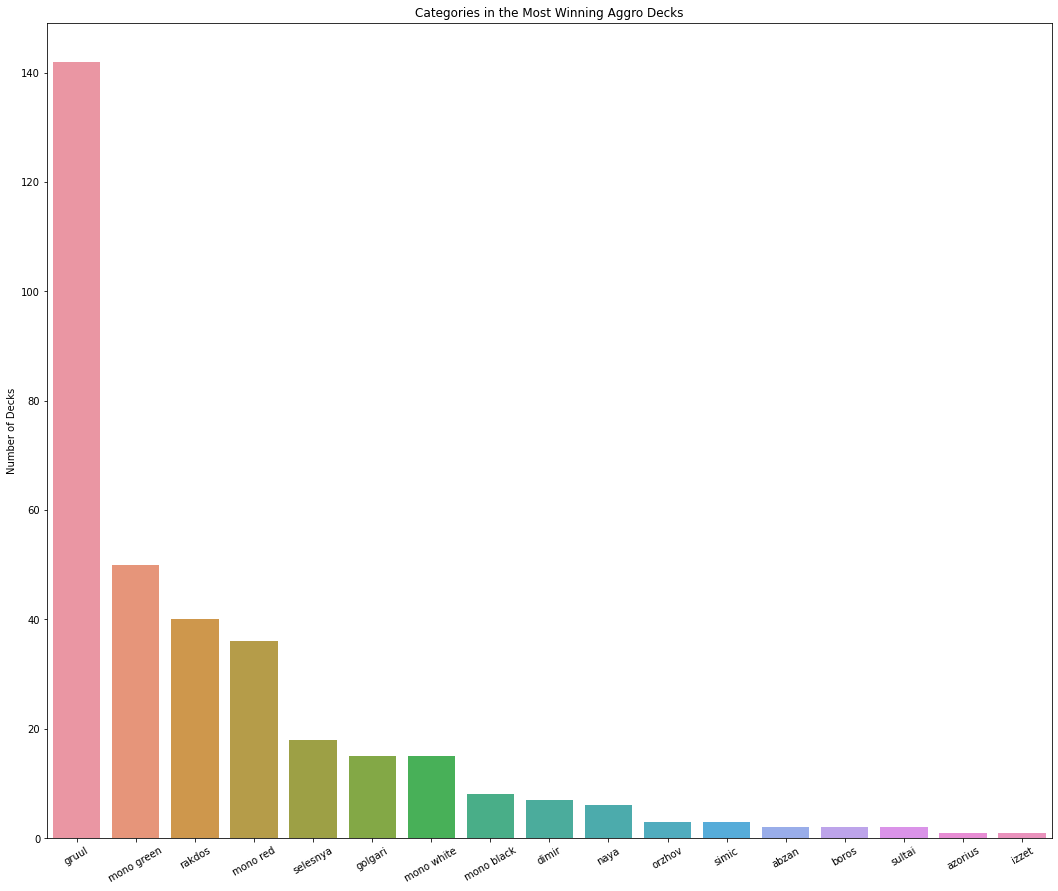

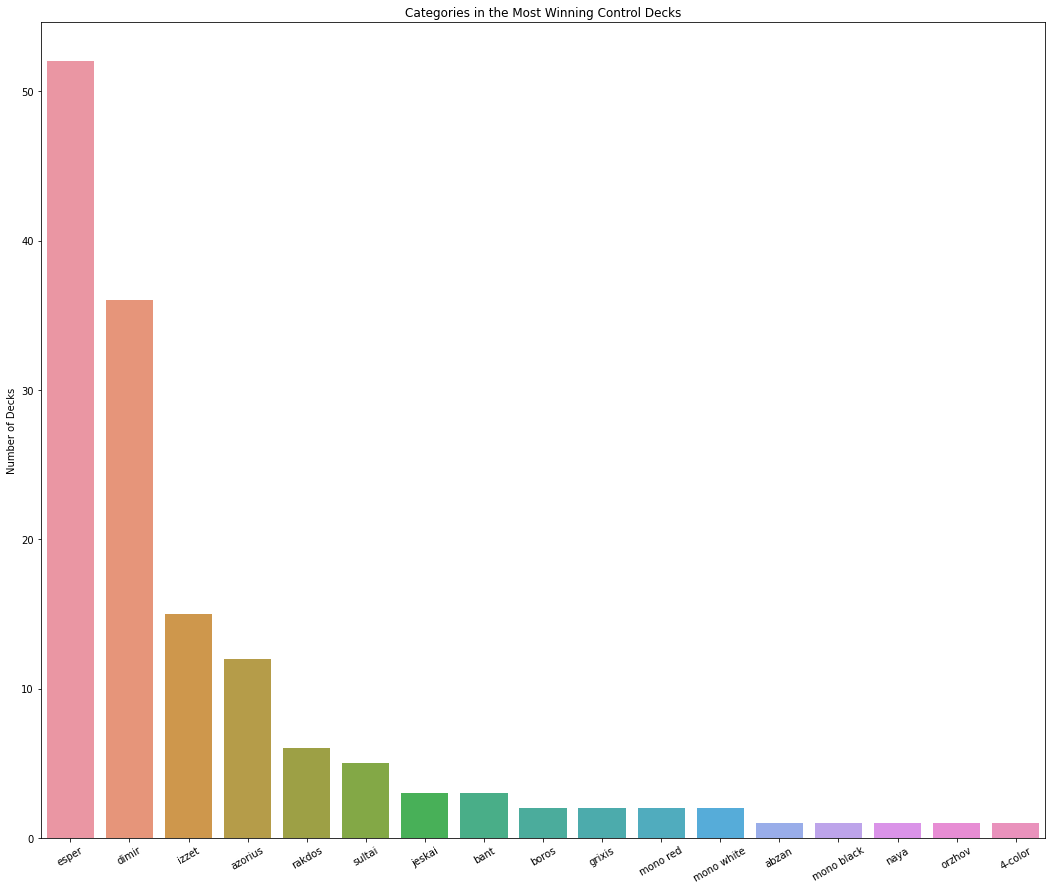

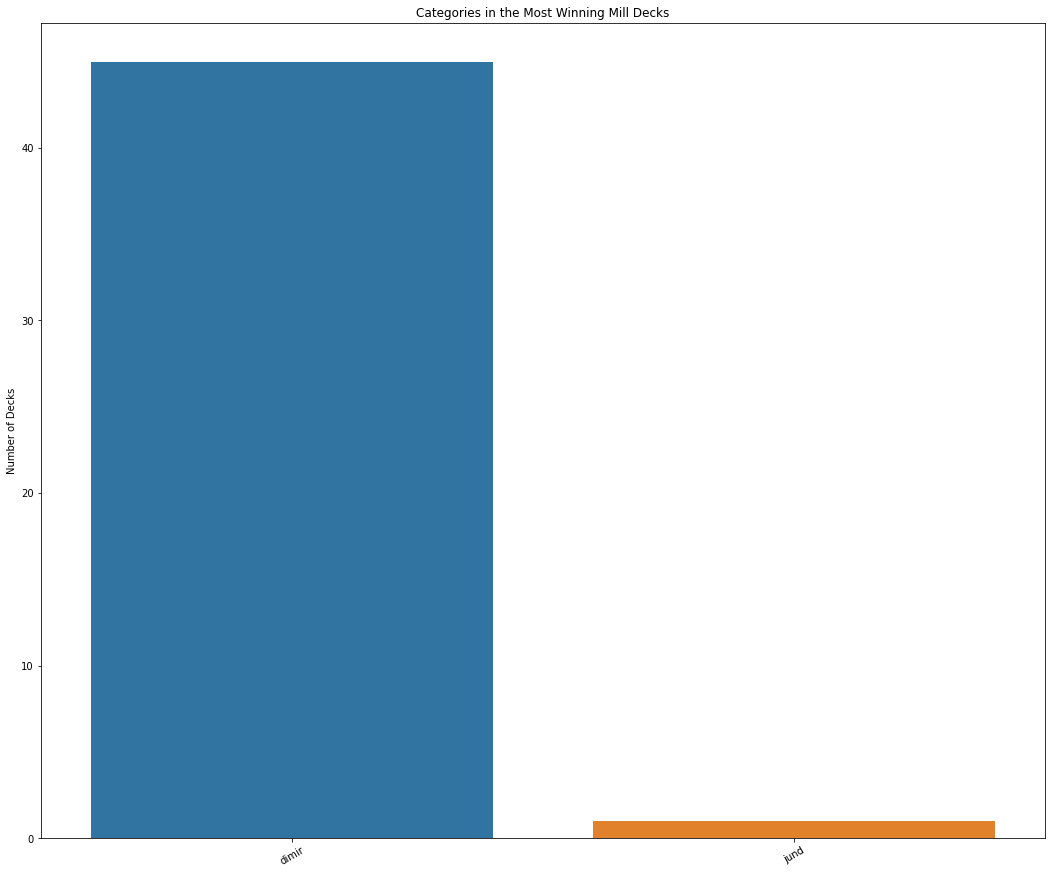

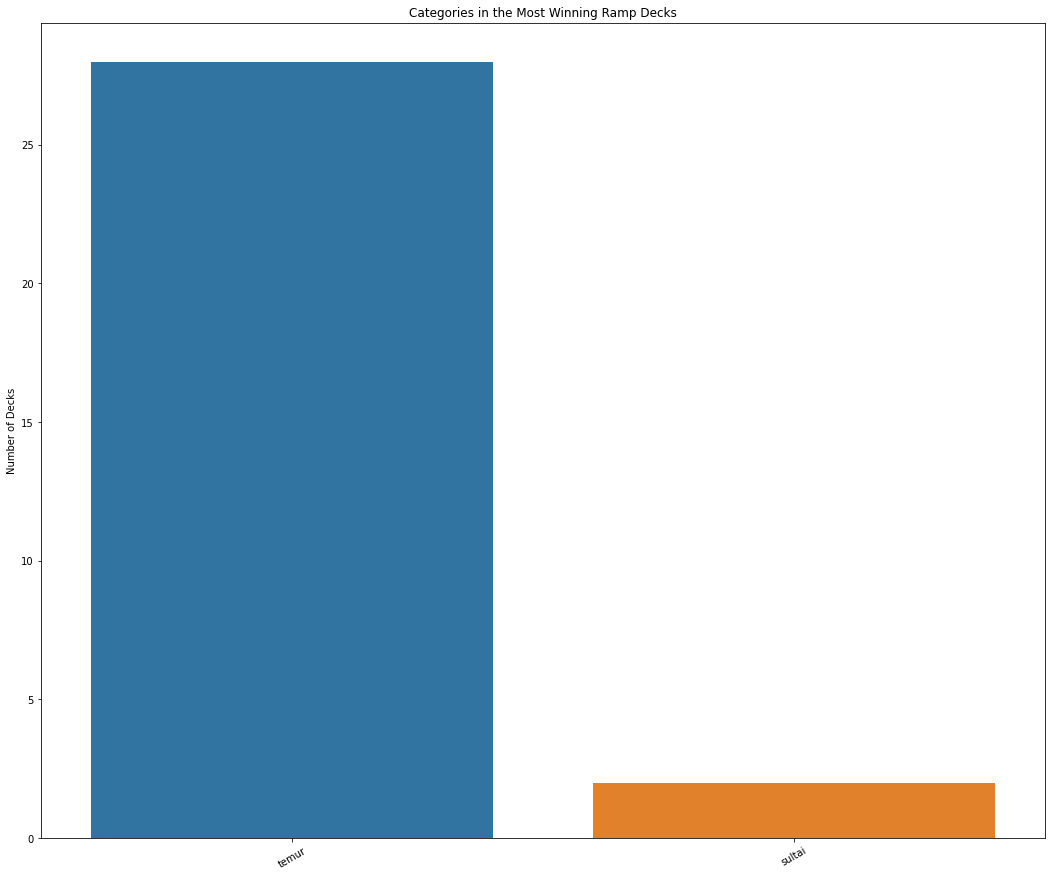

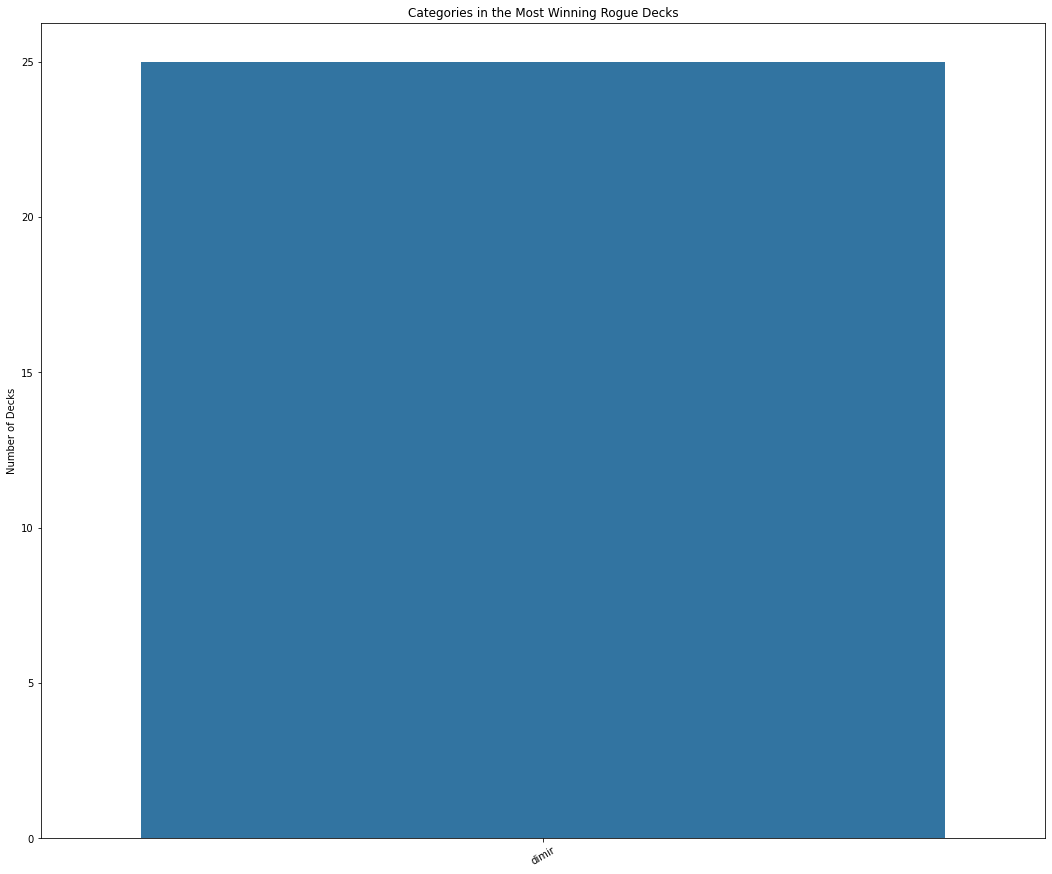

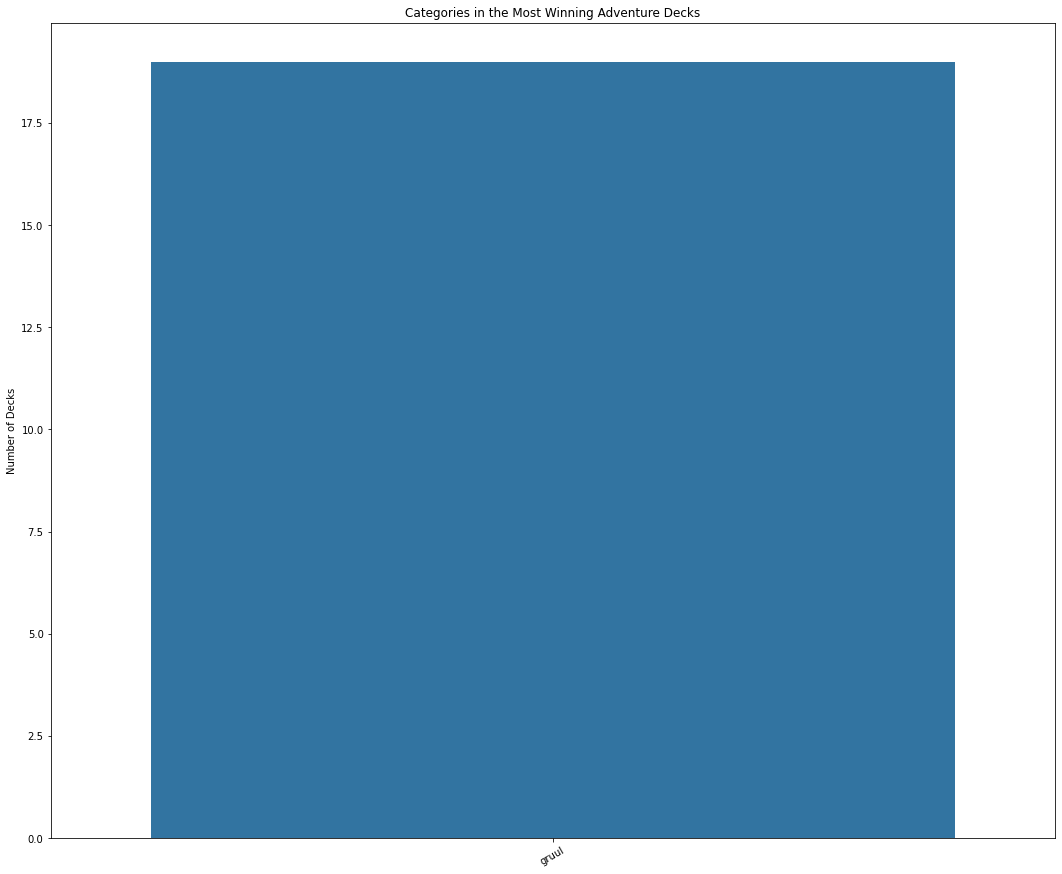

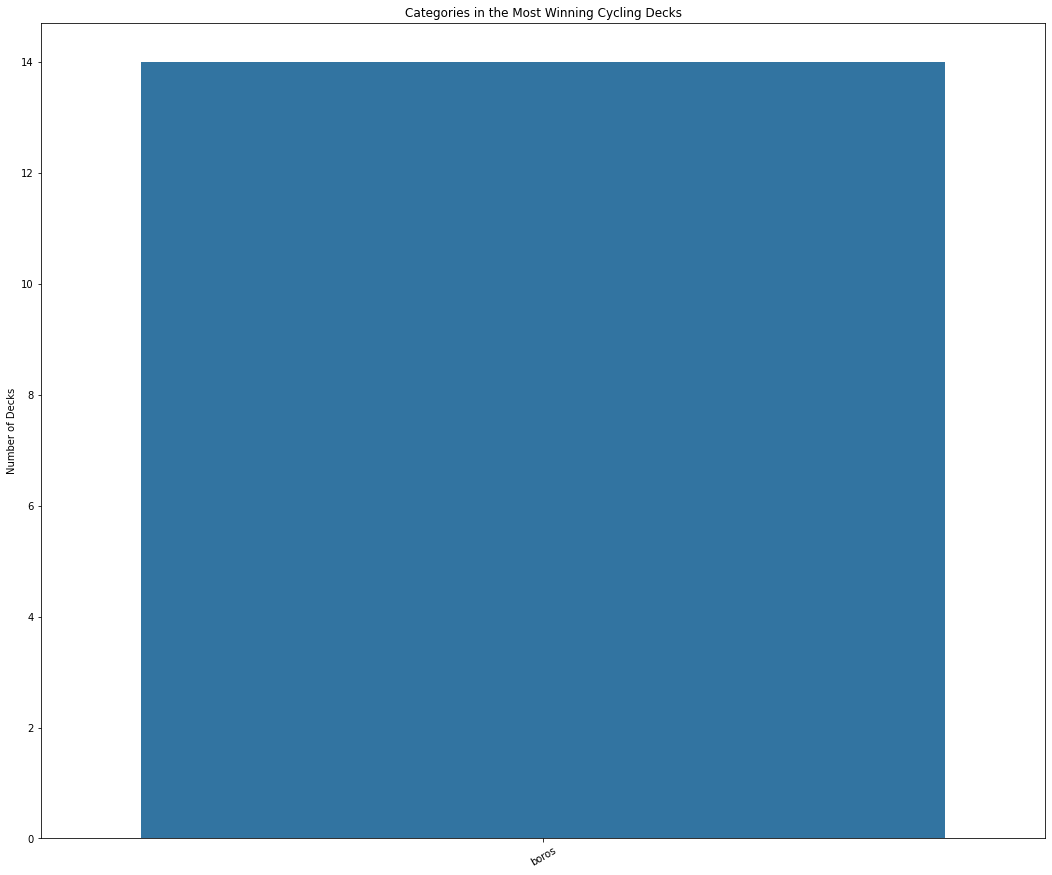

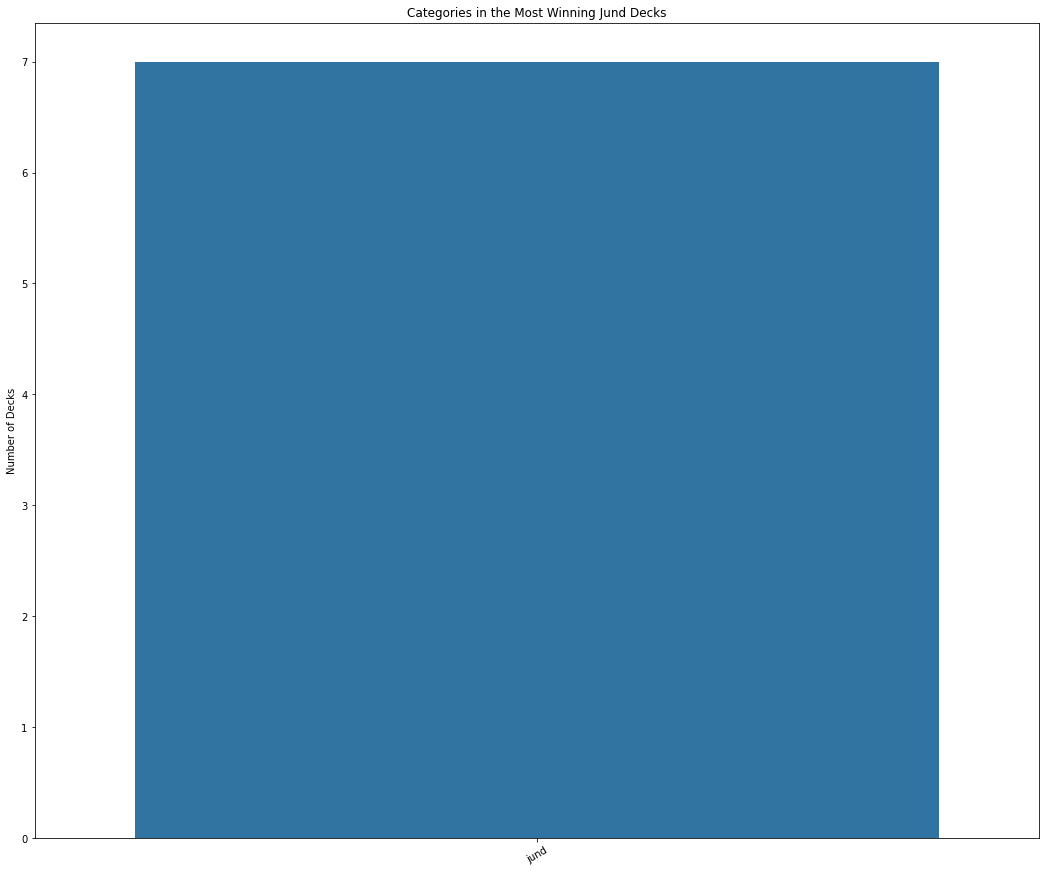

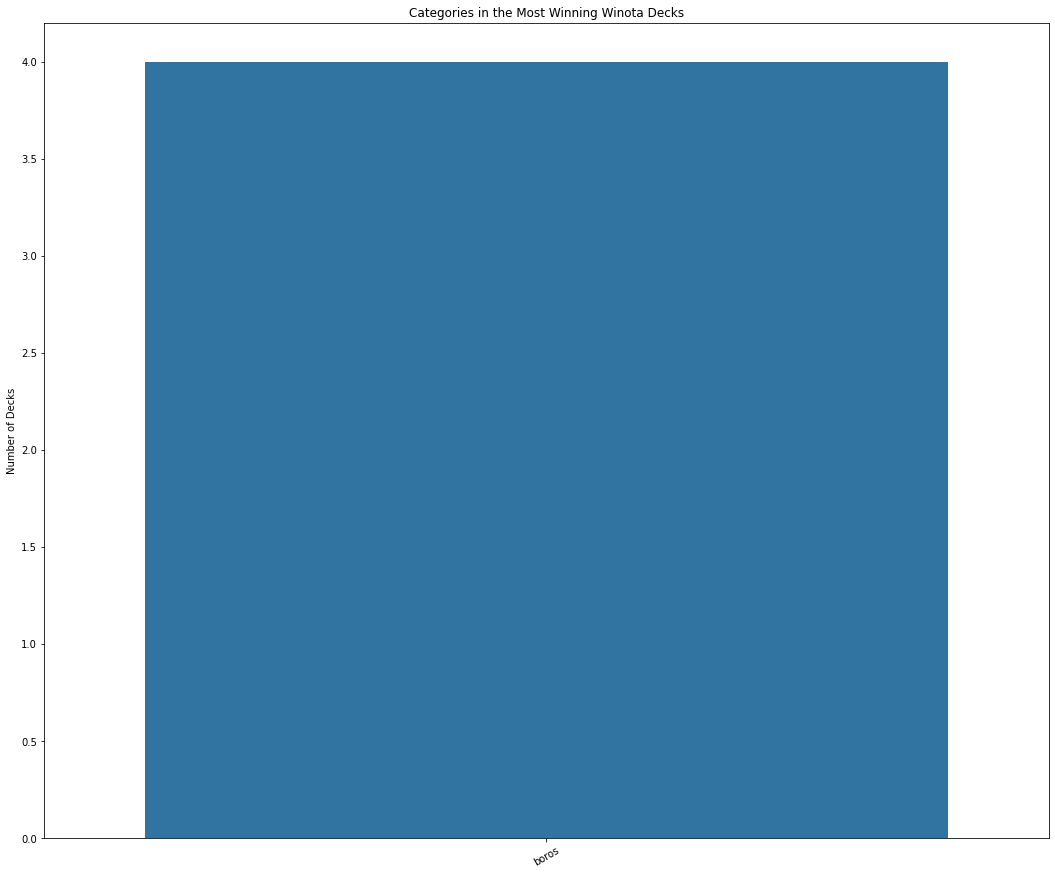

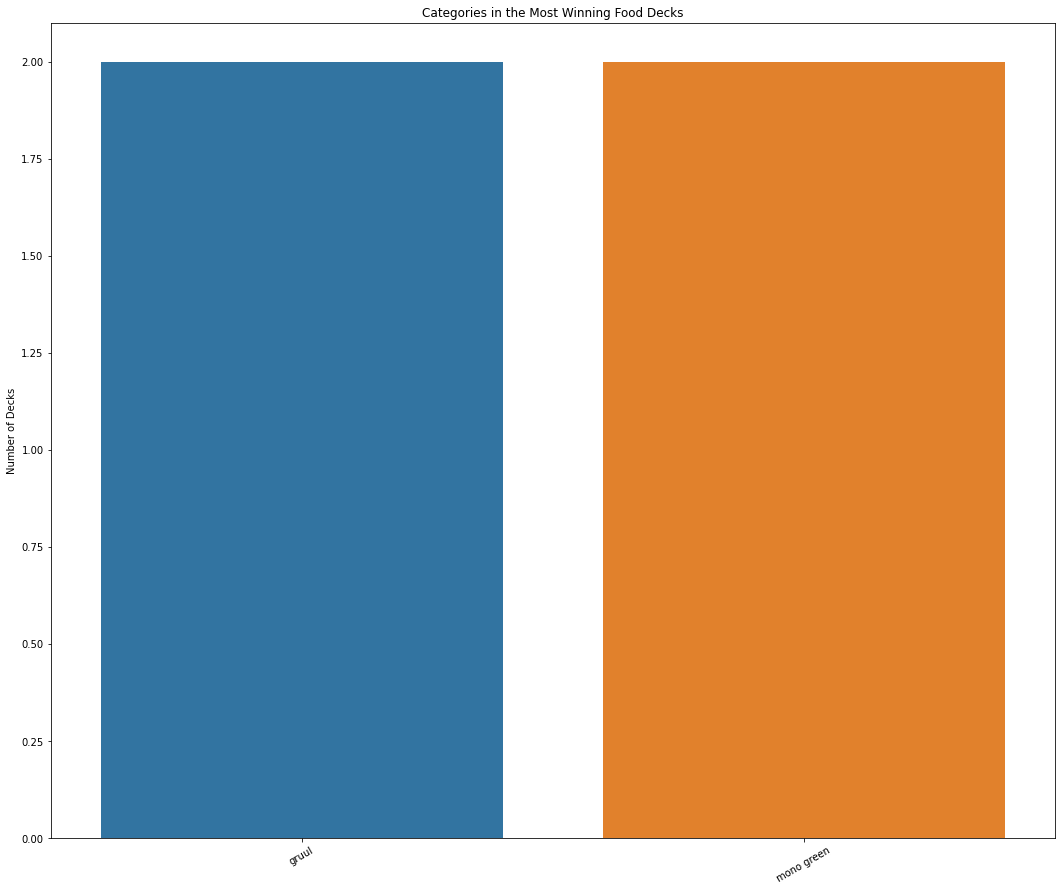

In [13]:
def top10_colors_archetypes(df, show=False, pdf=None):
    top10_archetypes = df["archetype"].value_counts().index[:10].tolist()
    for archetype in top10_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

top10_colors_archetypes(first_place_decks, show=True)

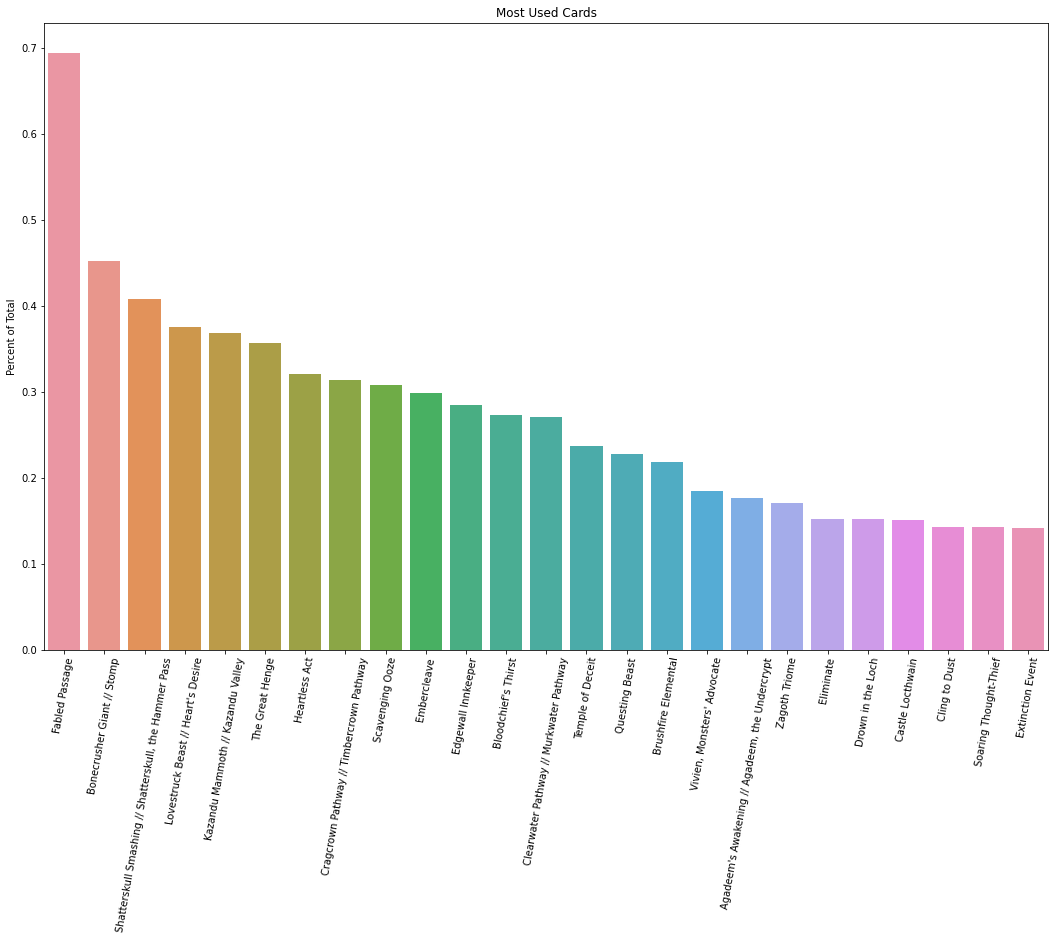

In [14]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [15]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

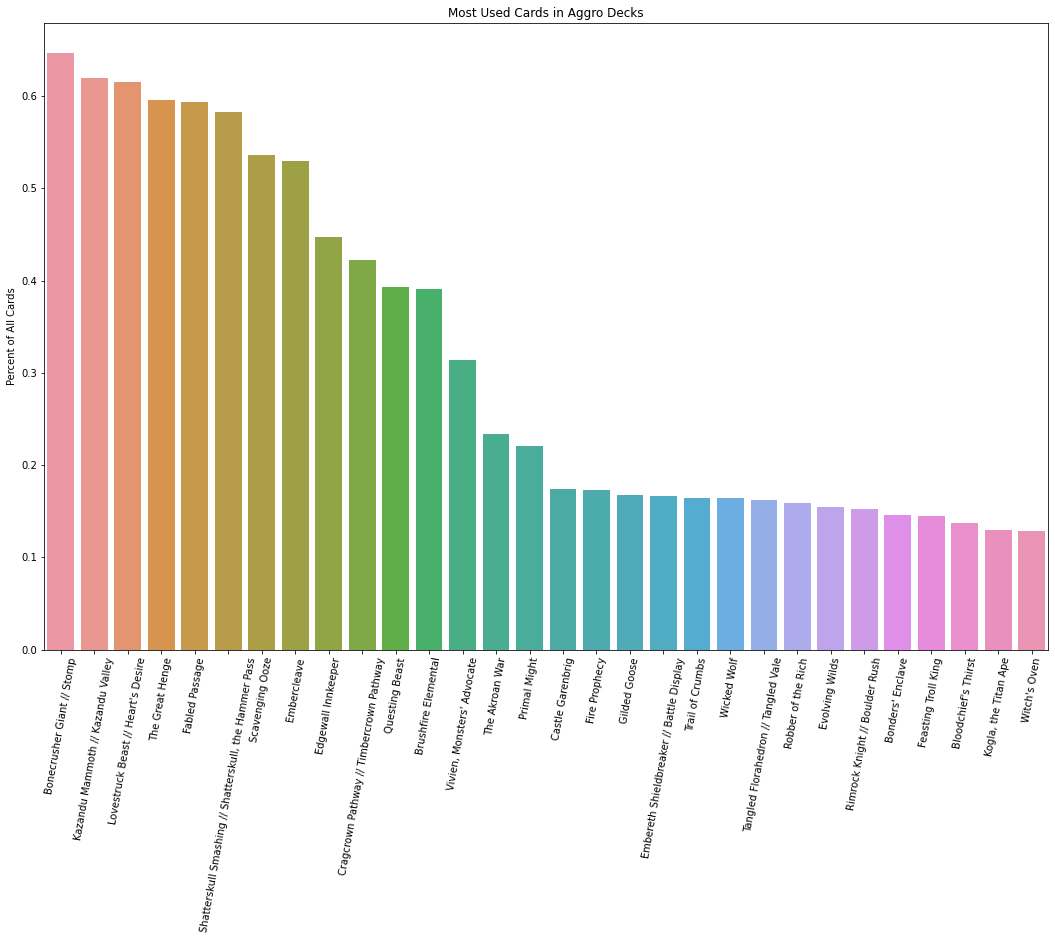

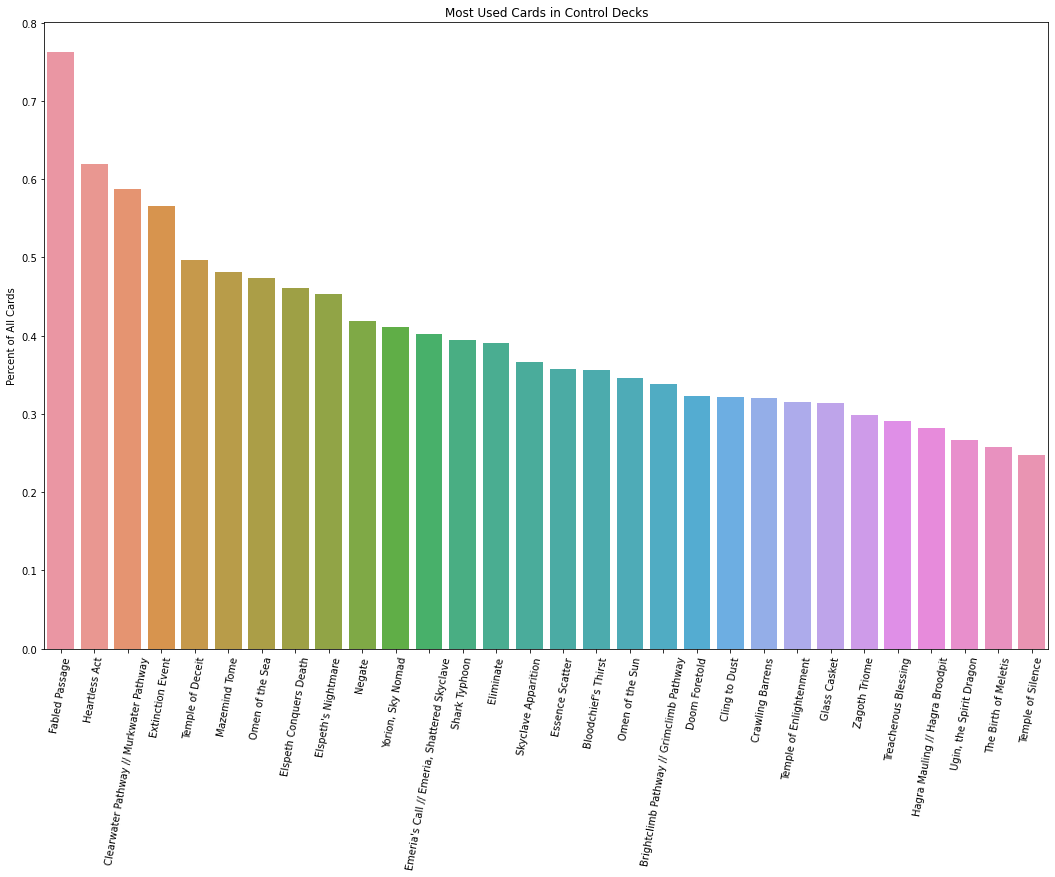

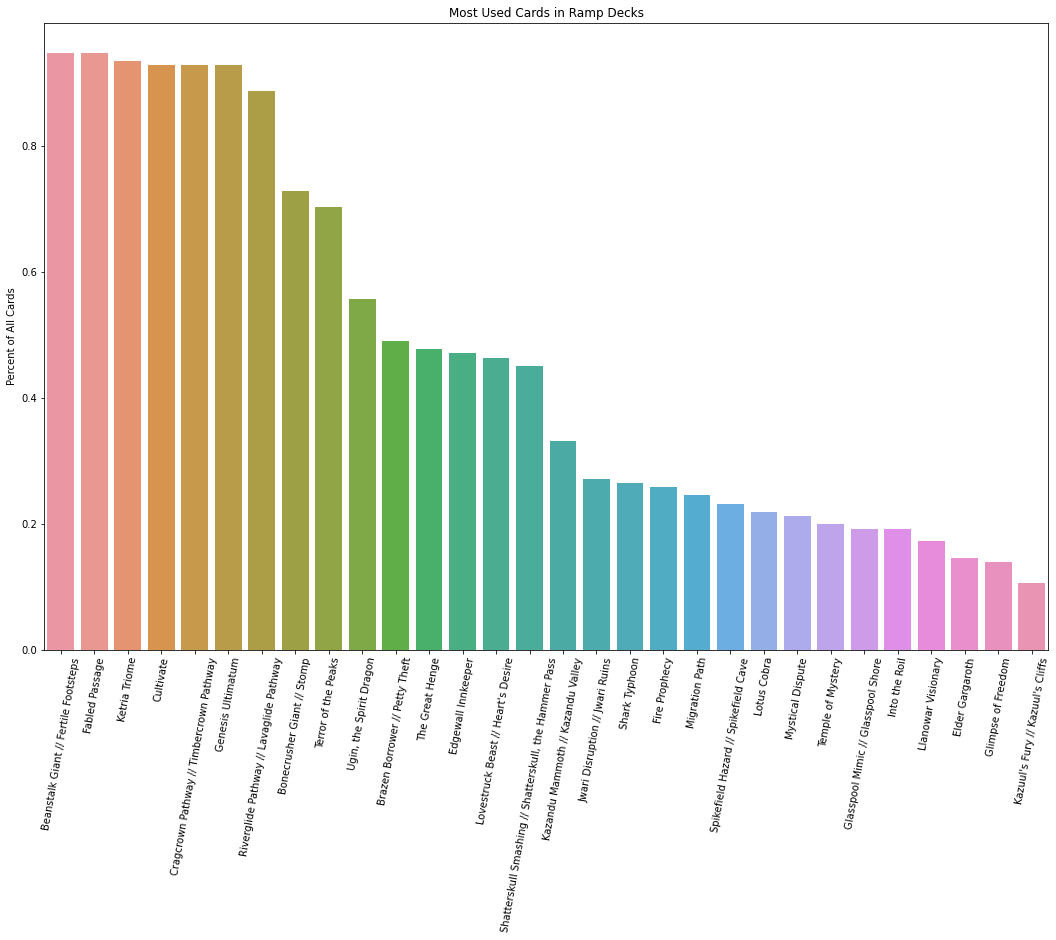

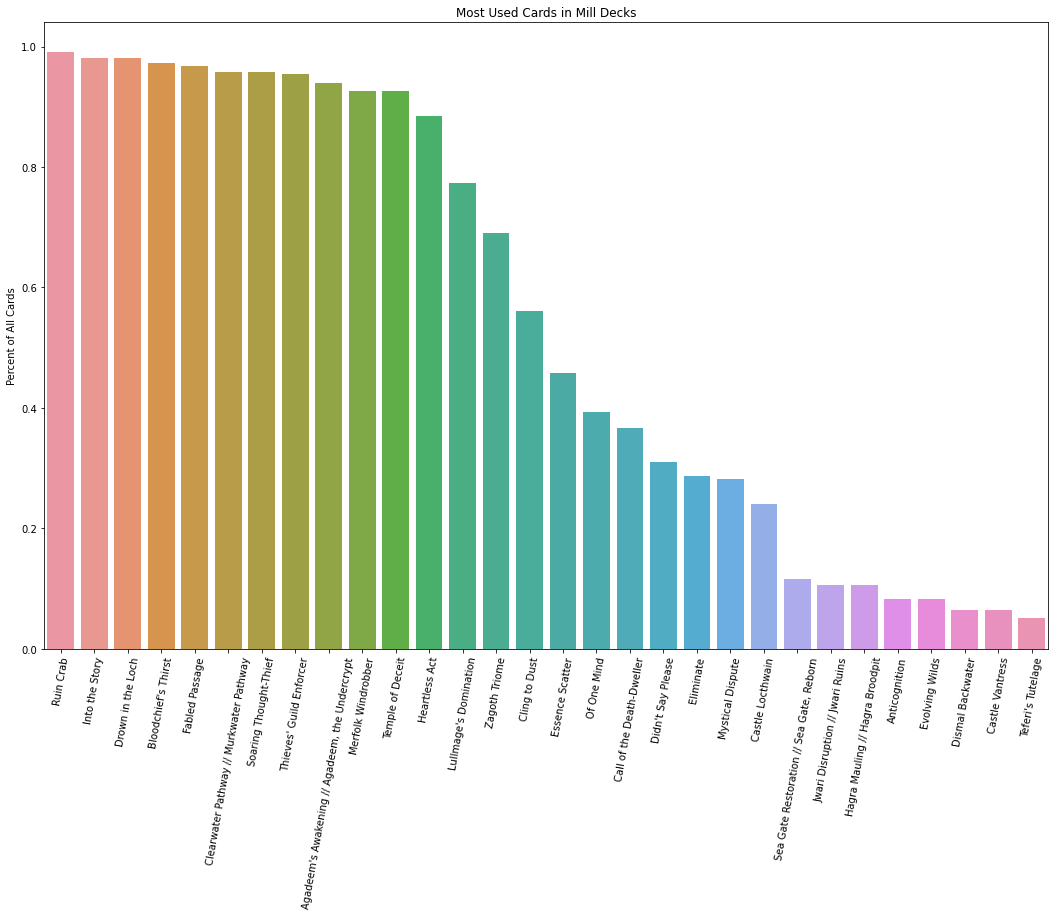

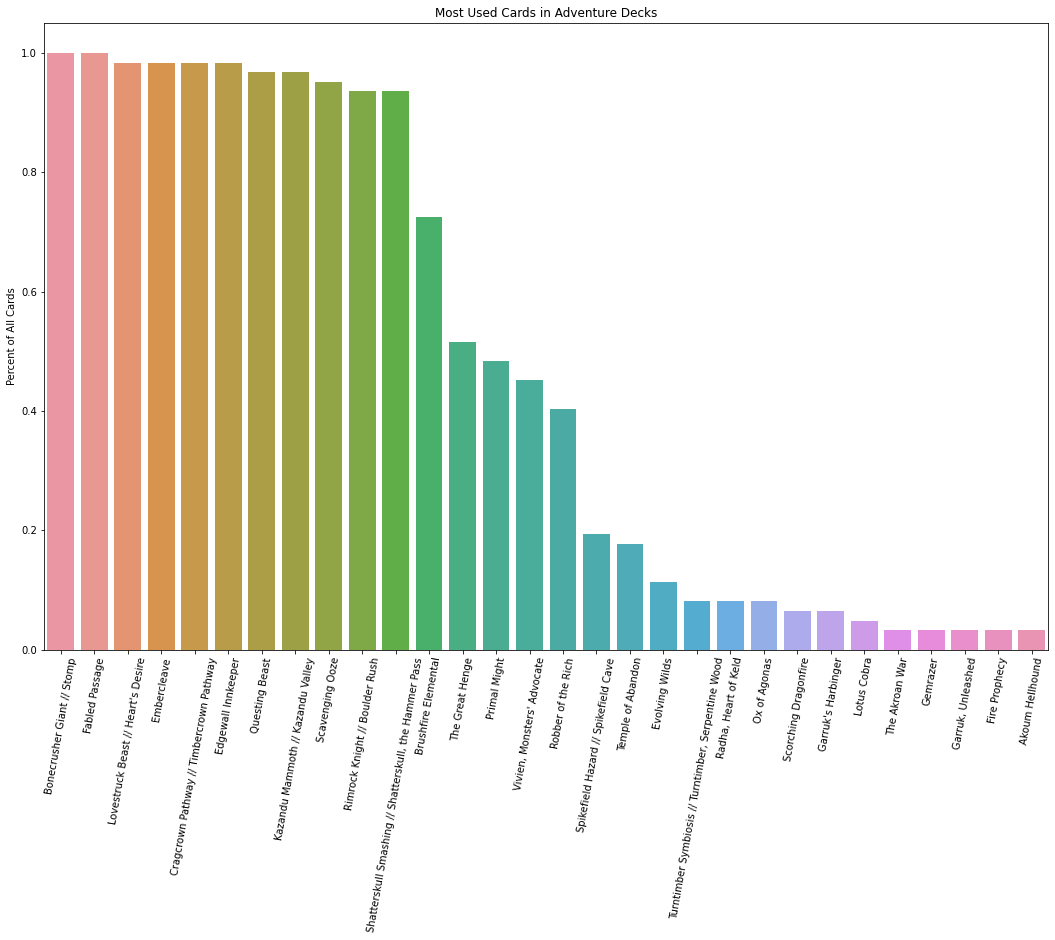

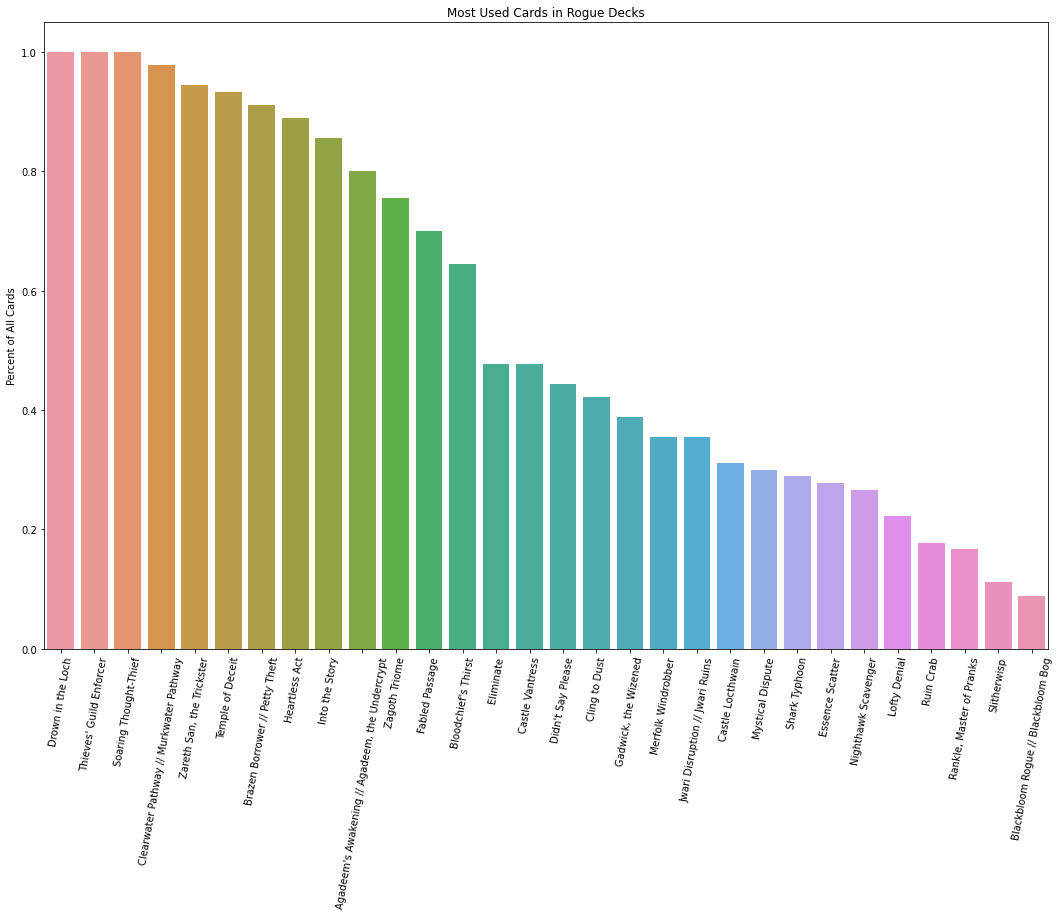

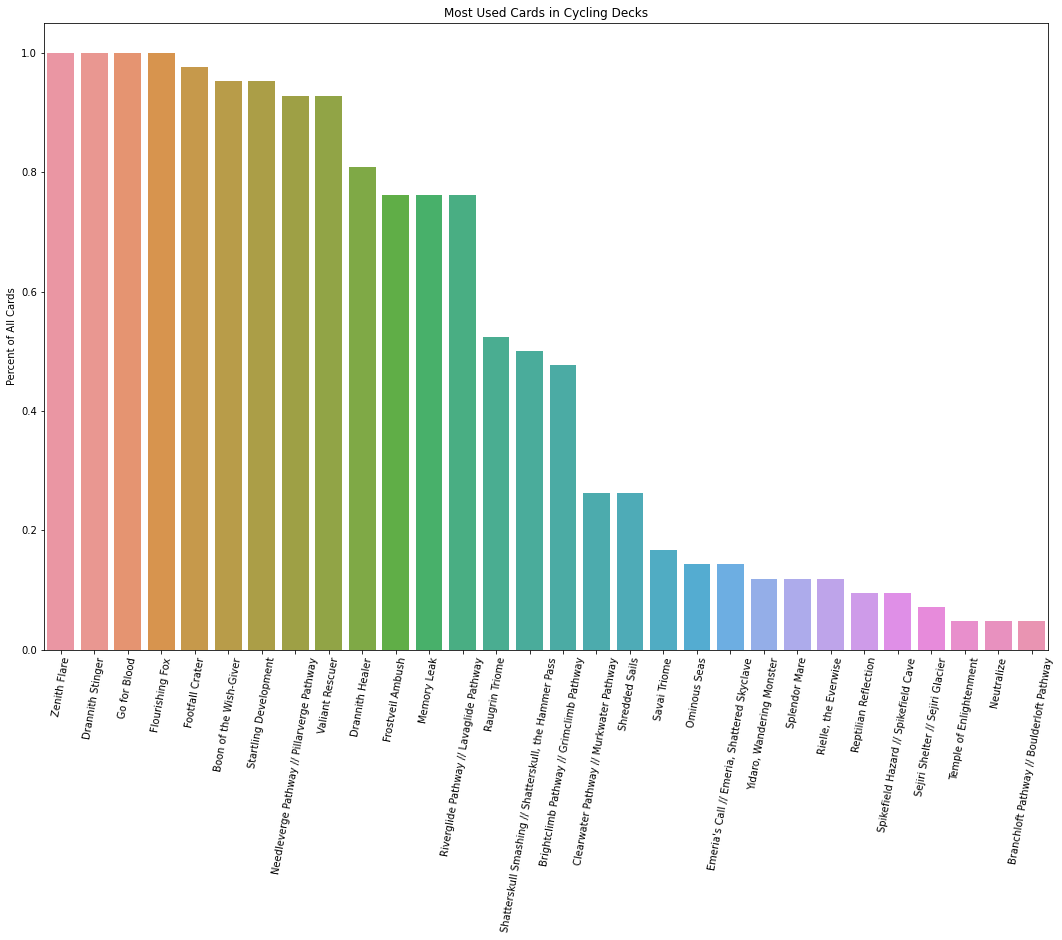

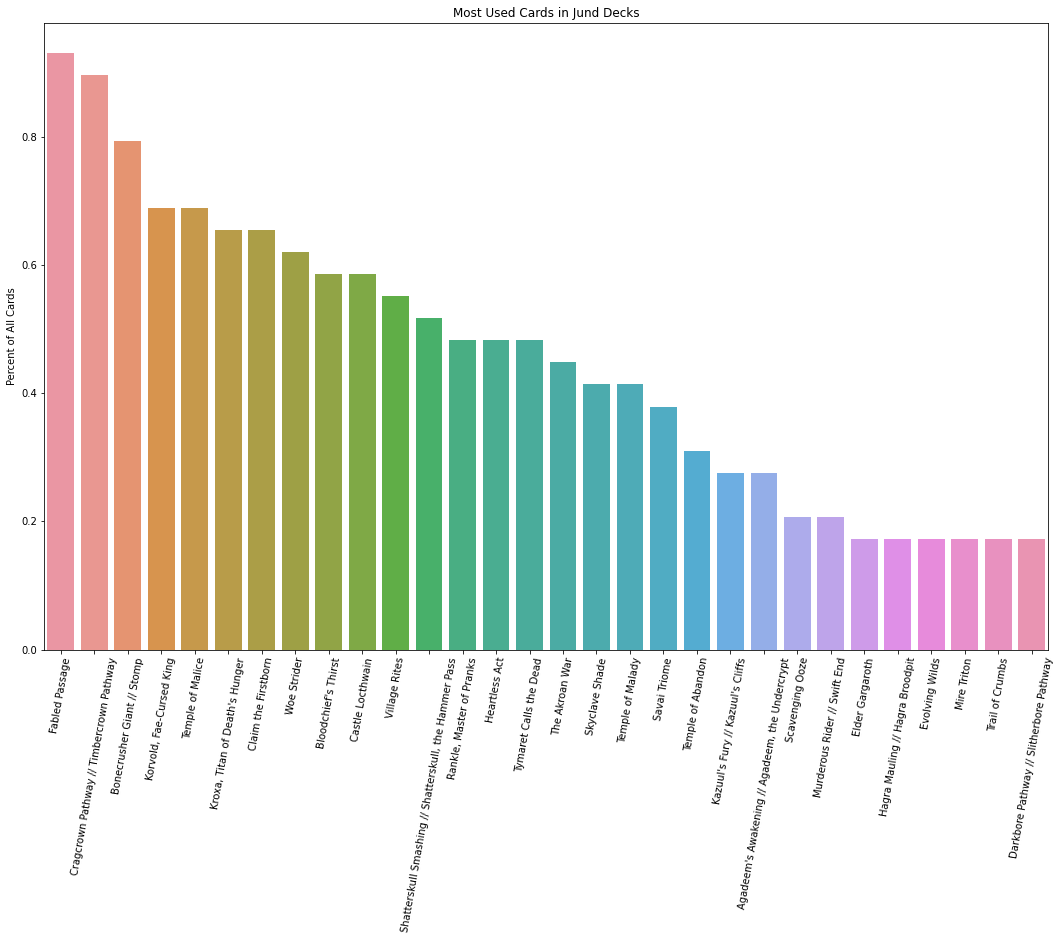

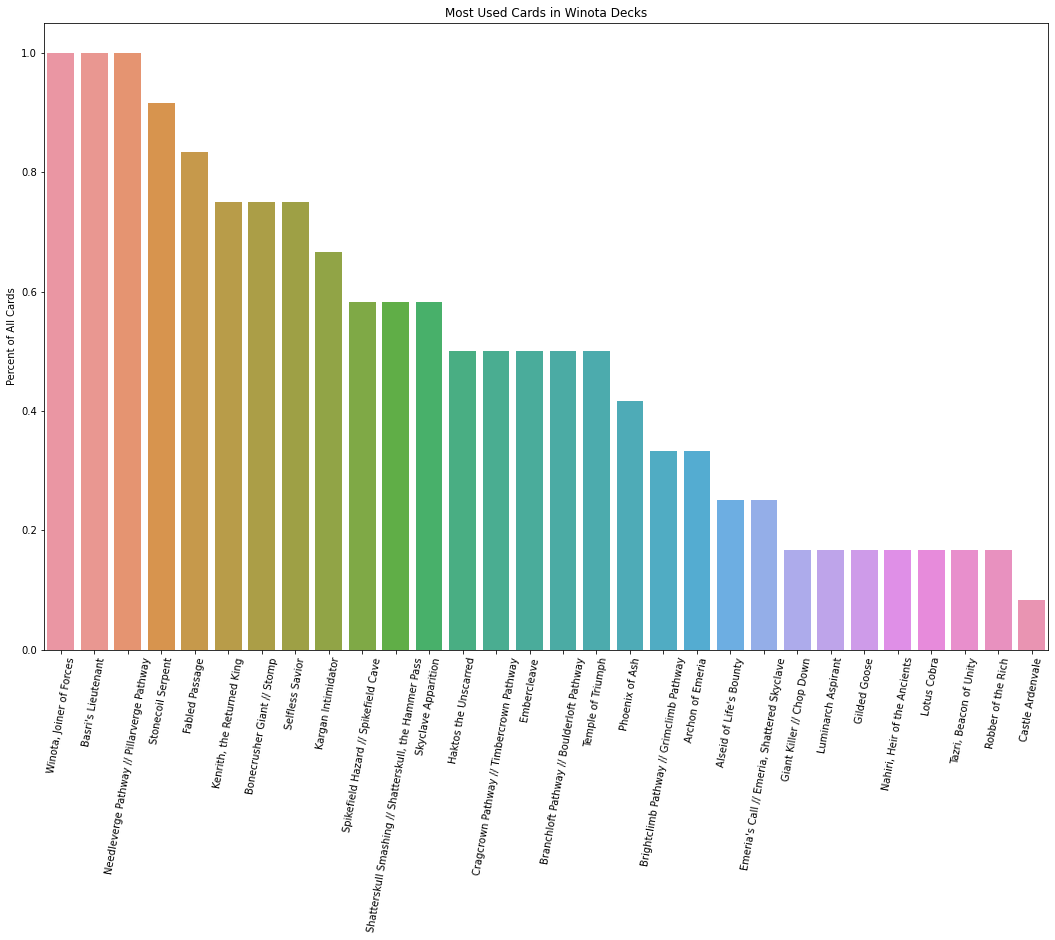

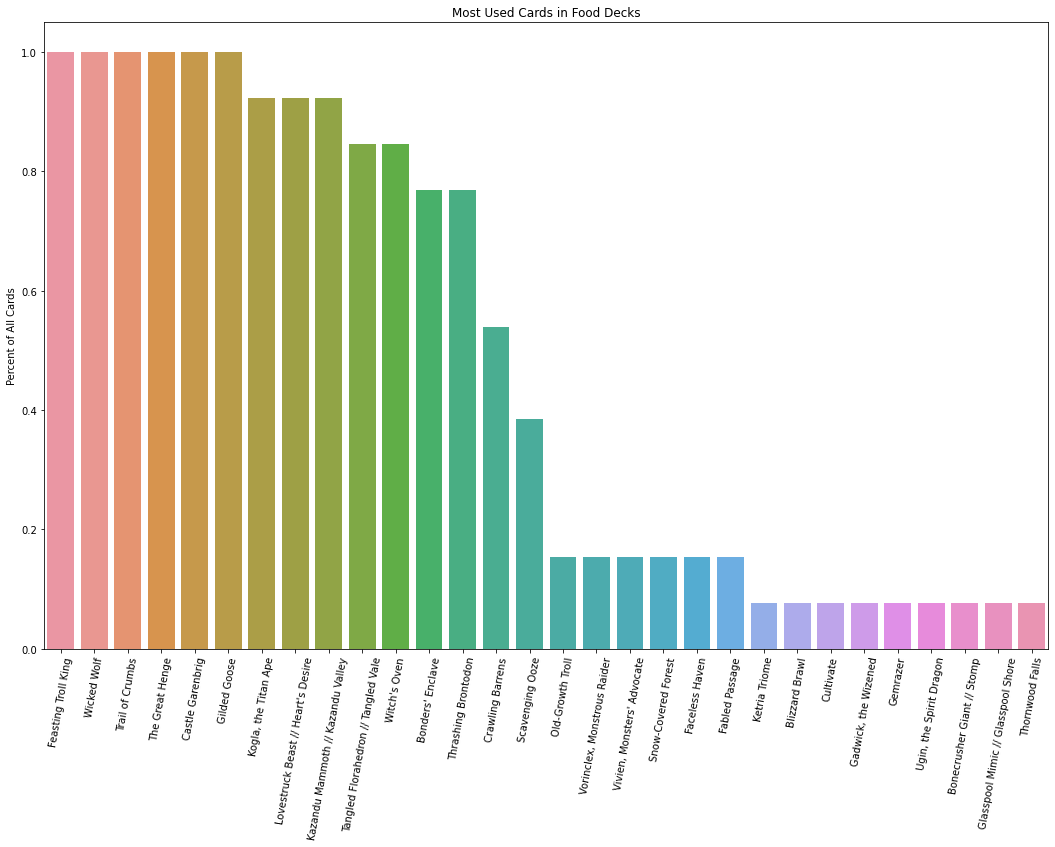

In [16]:
def top_10_archetypes(df, show=False, pdf=None):
    top_10_archetypes = deck_table["archetype"].value_counts().index[:10]
    for archetype in top_10_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

top_10_archetypes(main_decks, show=True)

In [17]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Cards")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

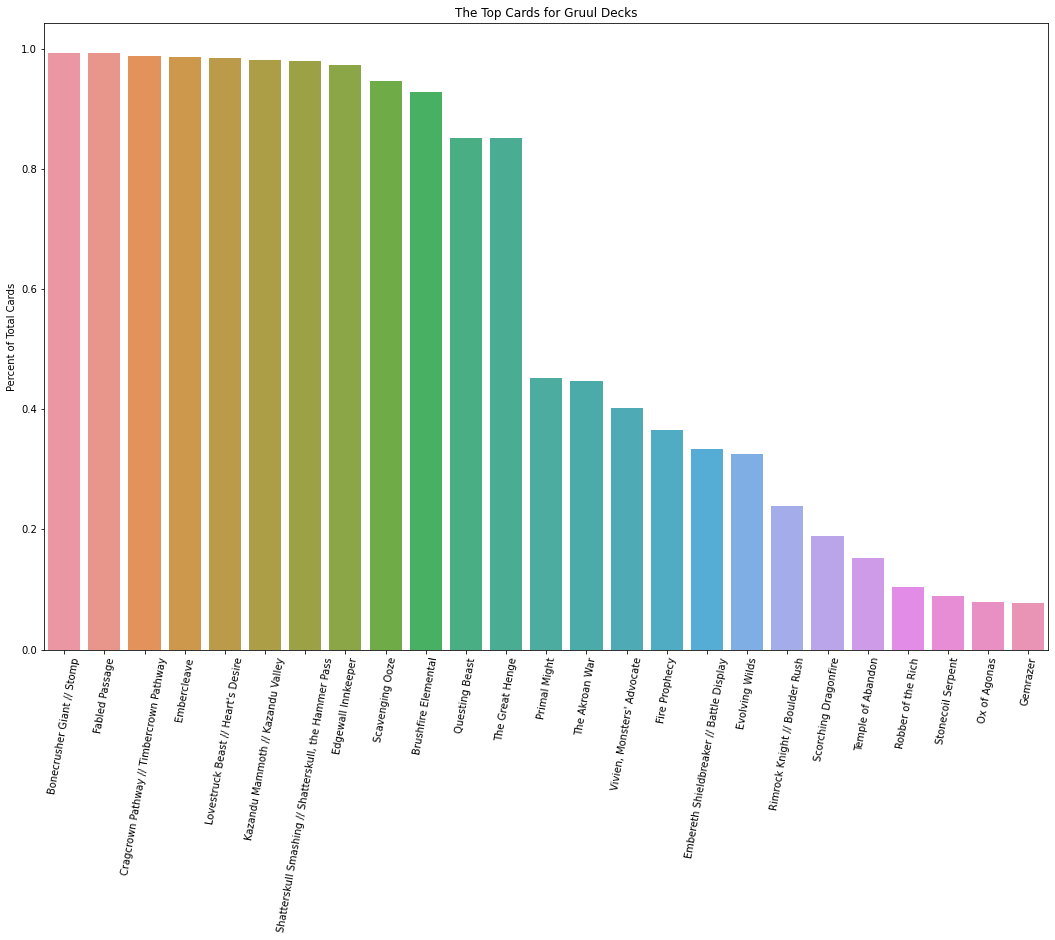

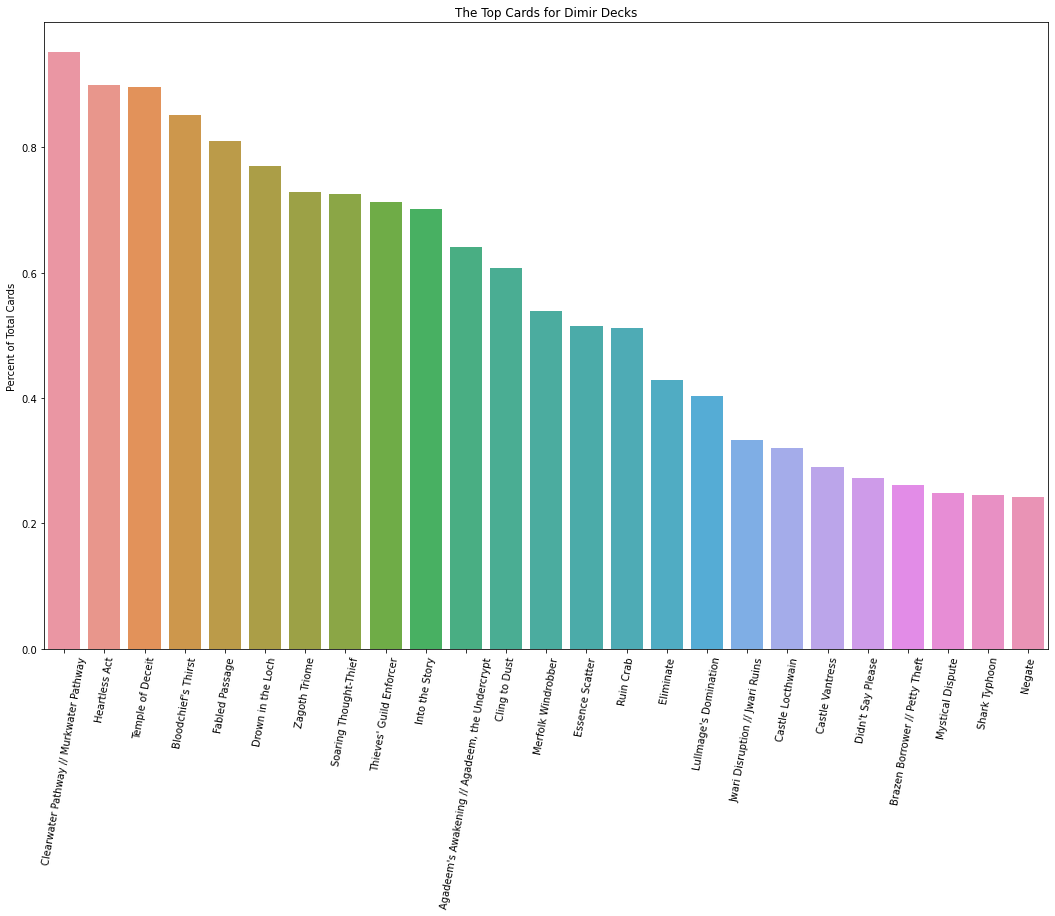

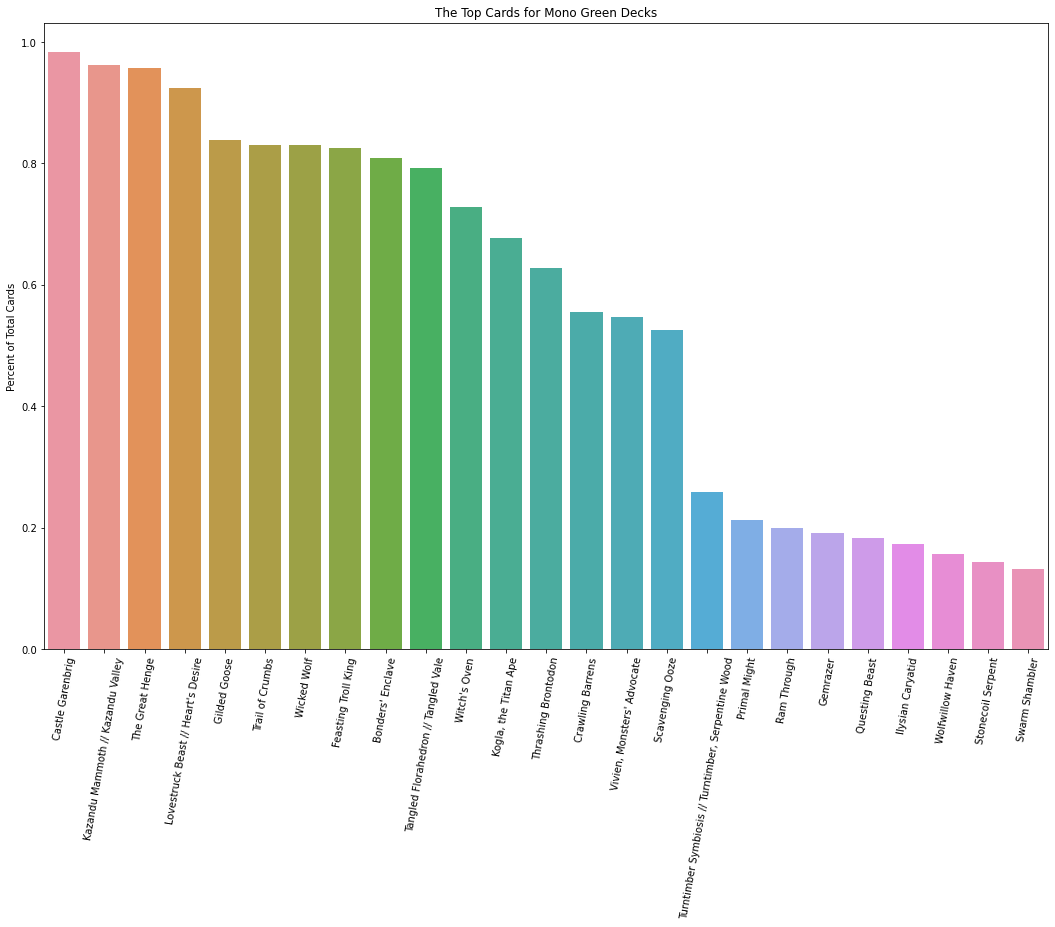

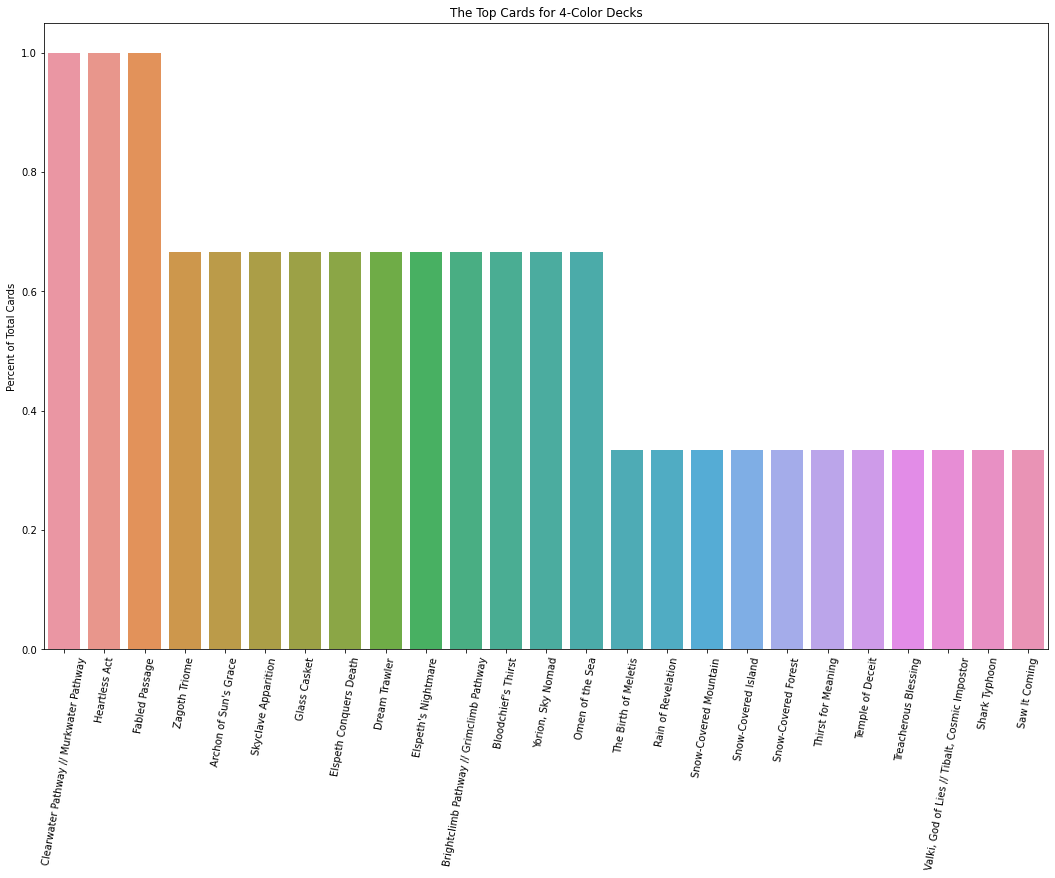

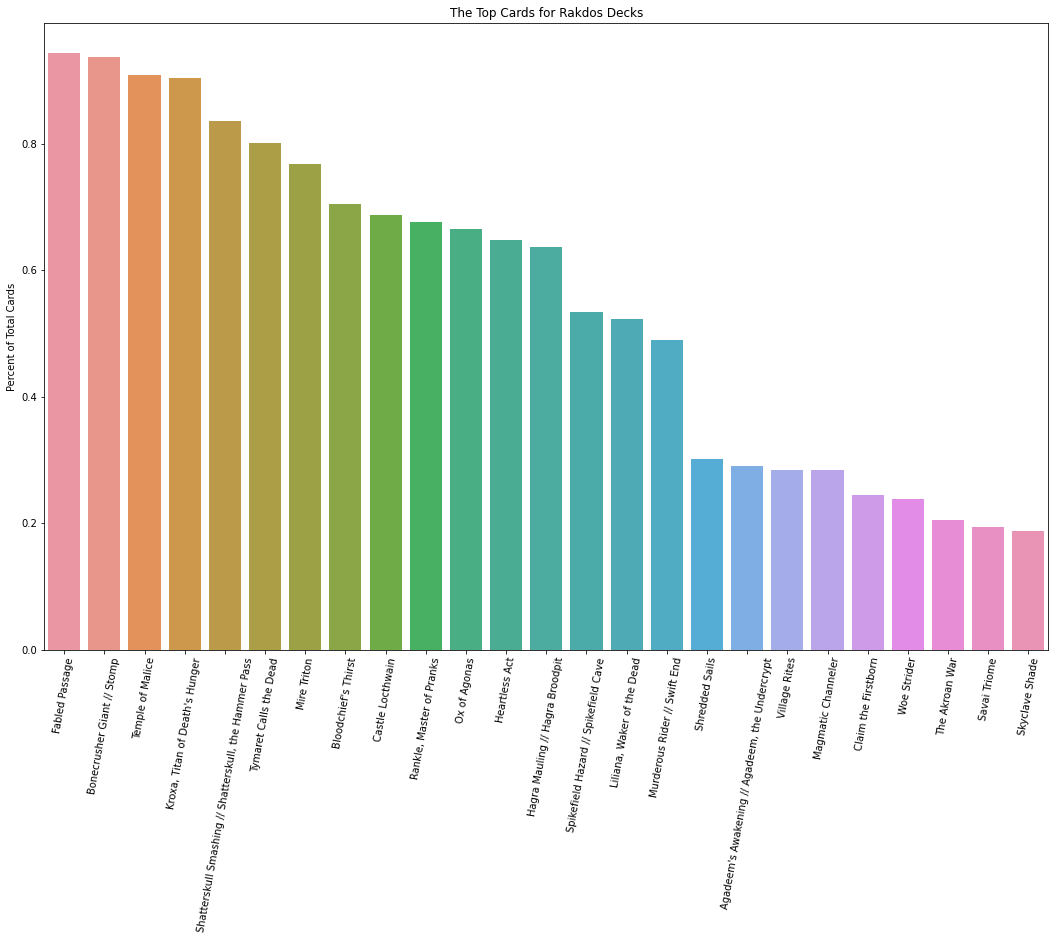

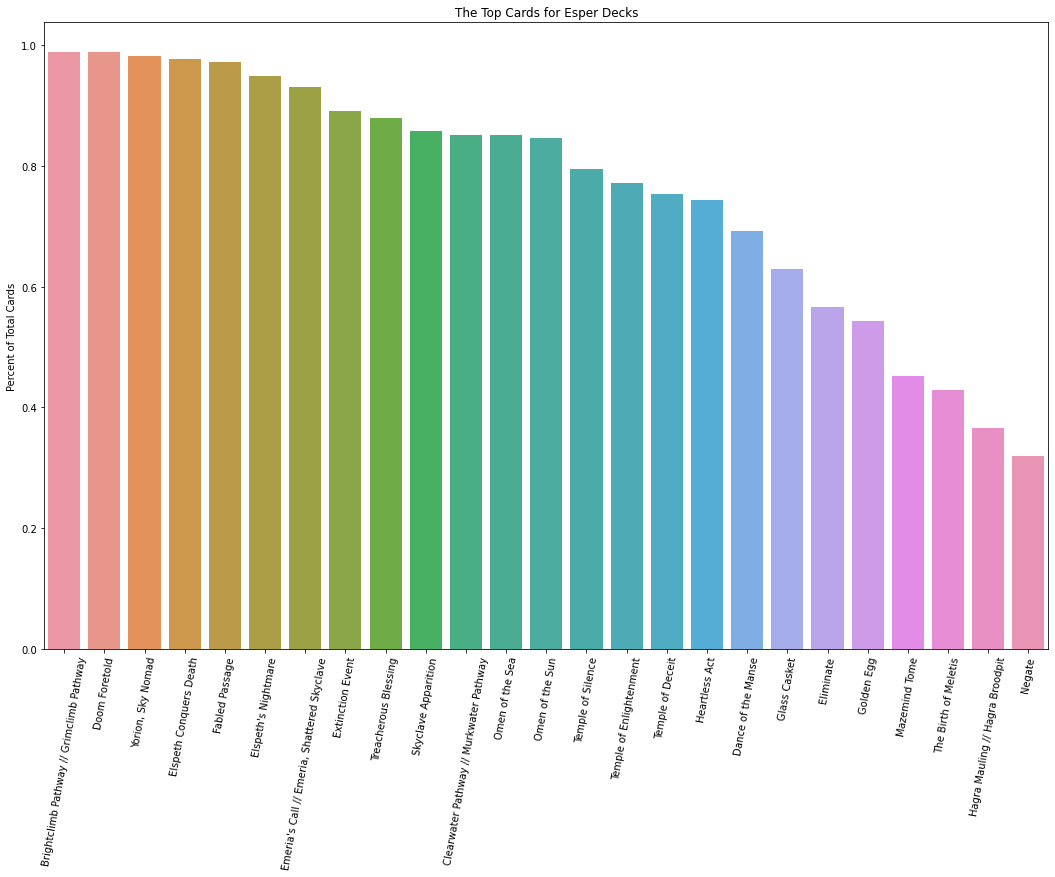

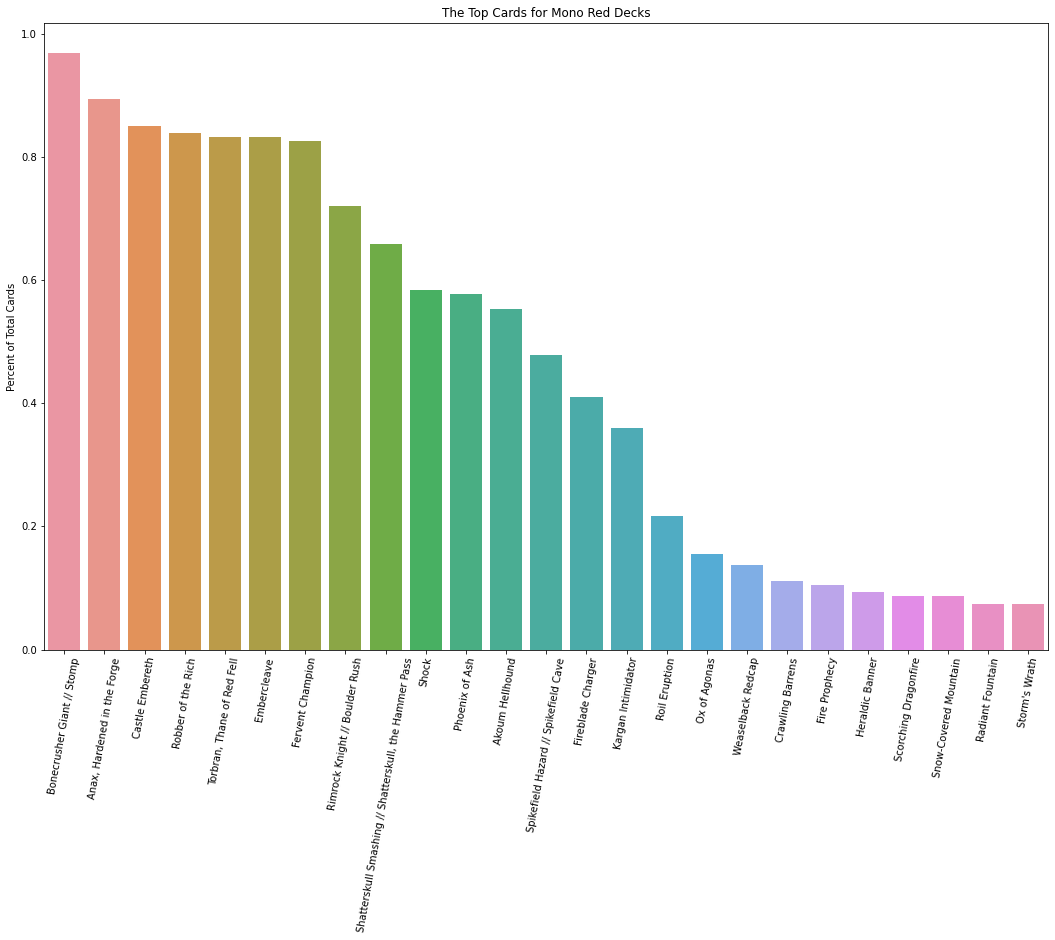

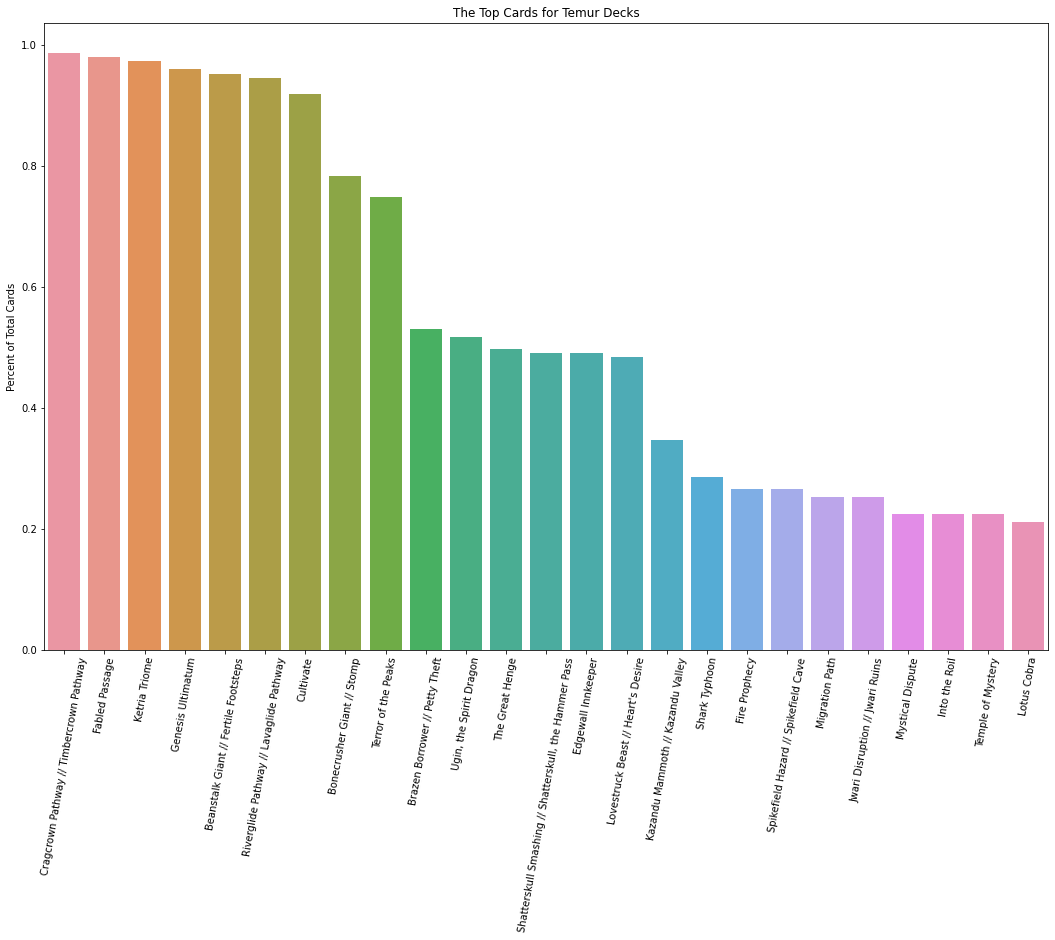

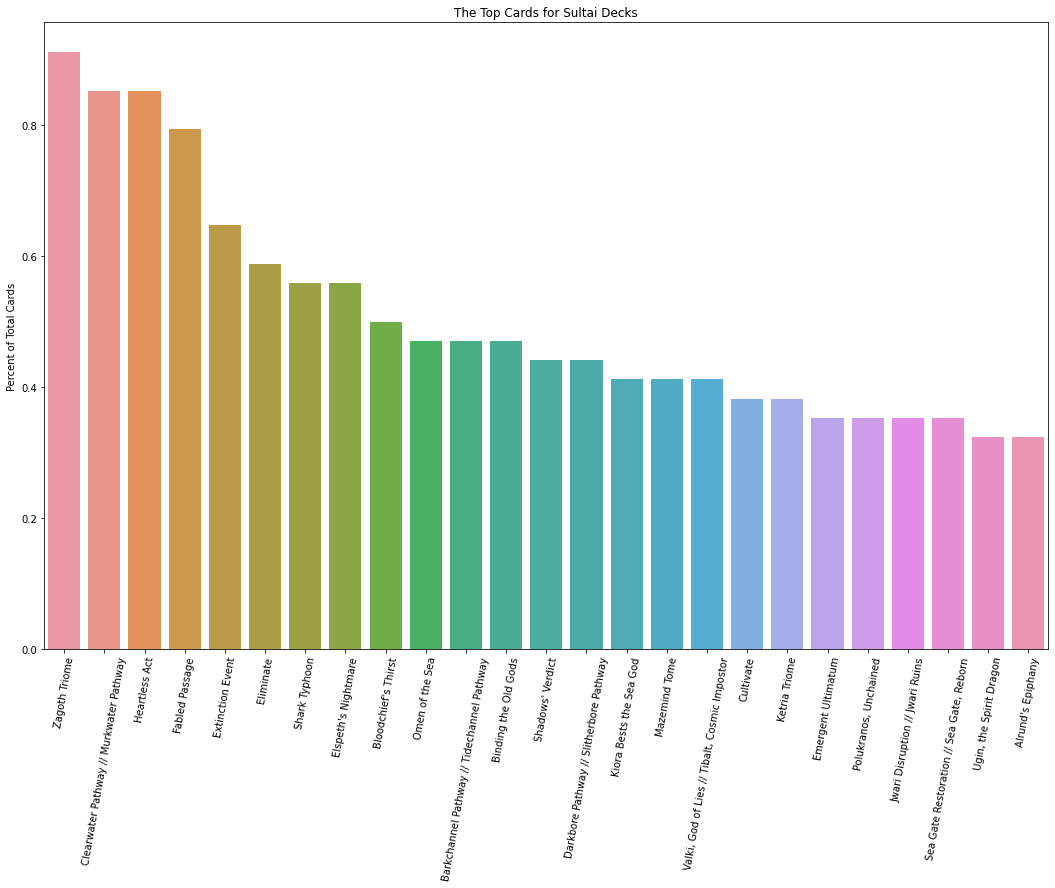

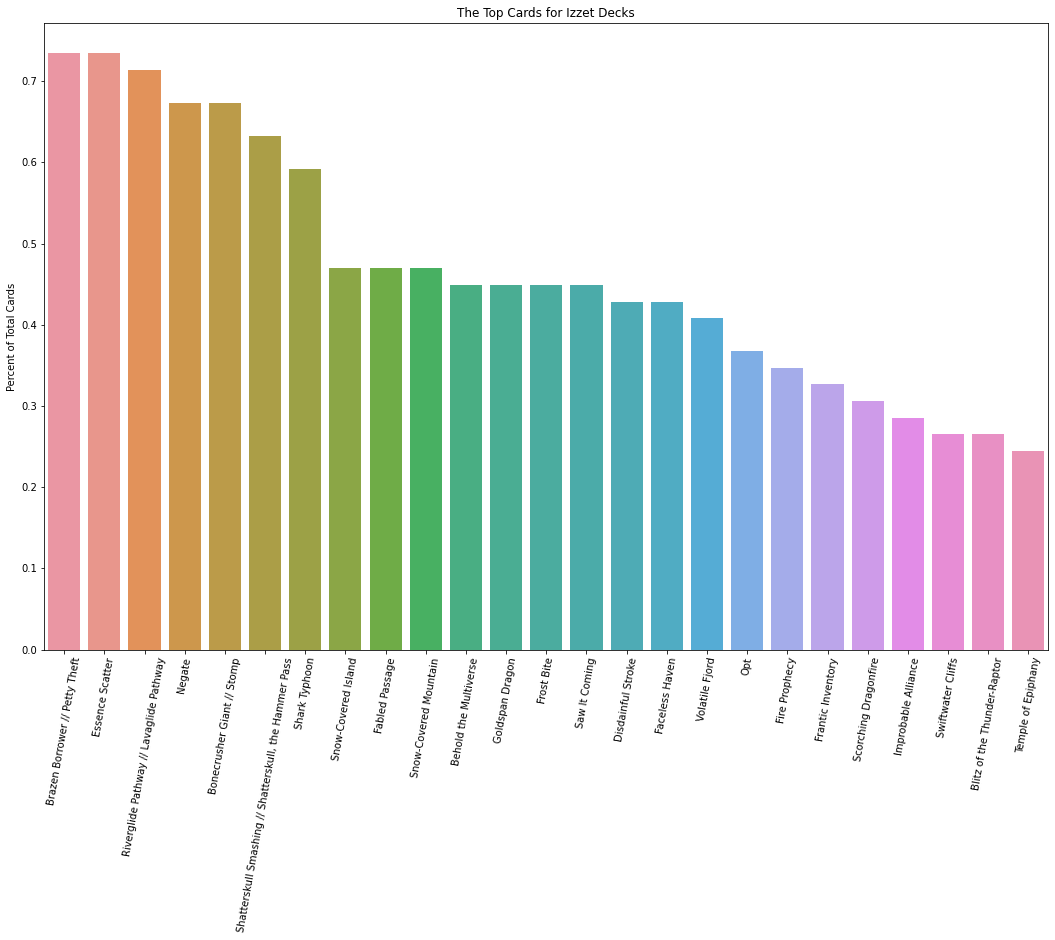

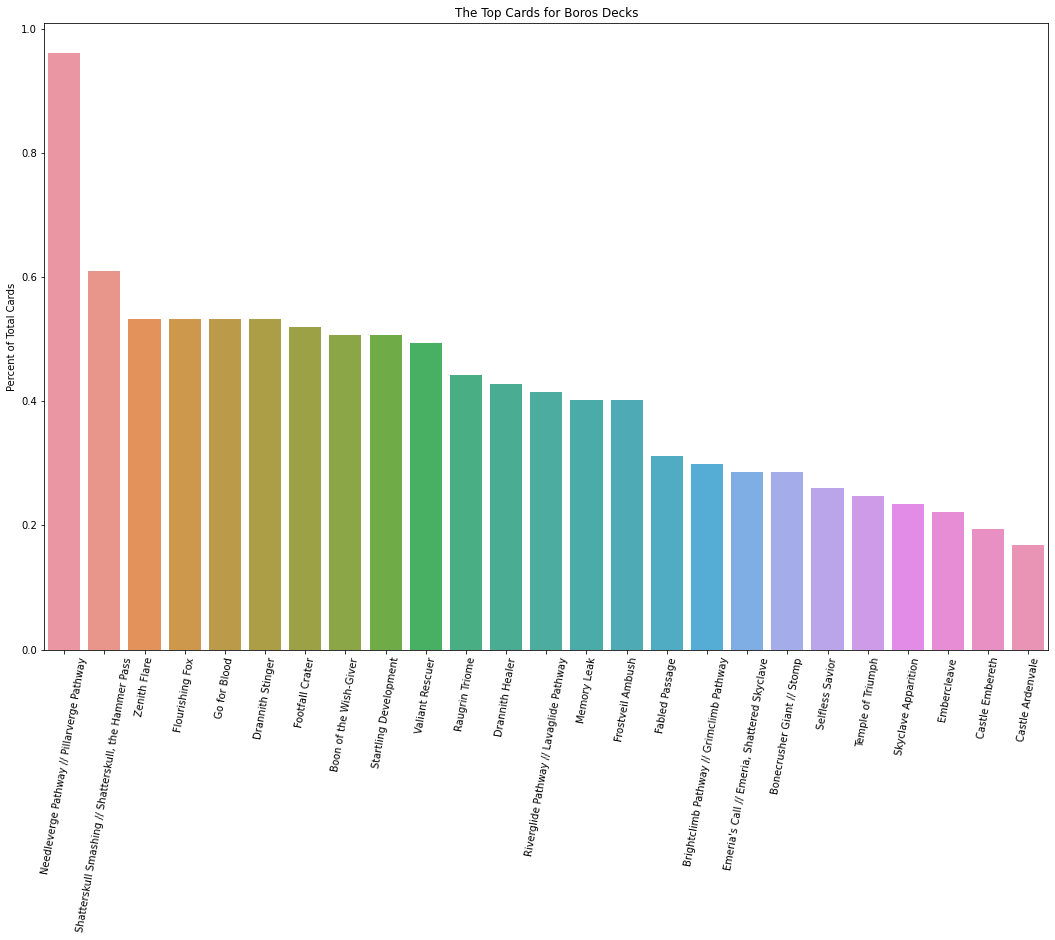

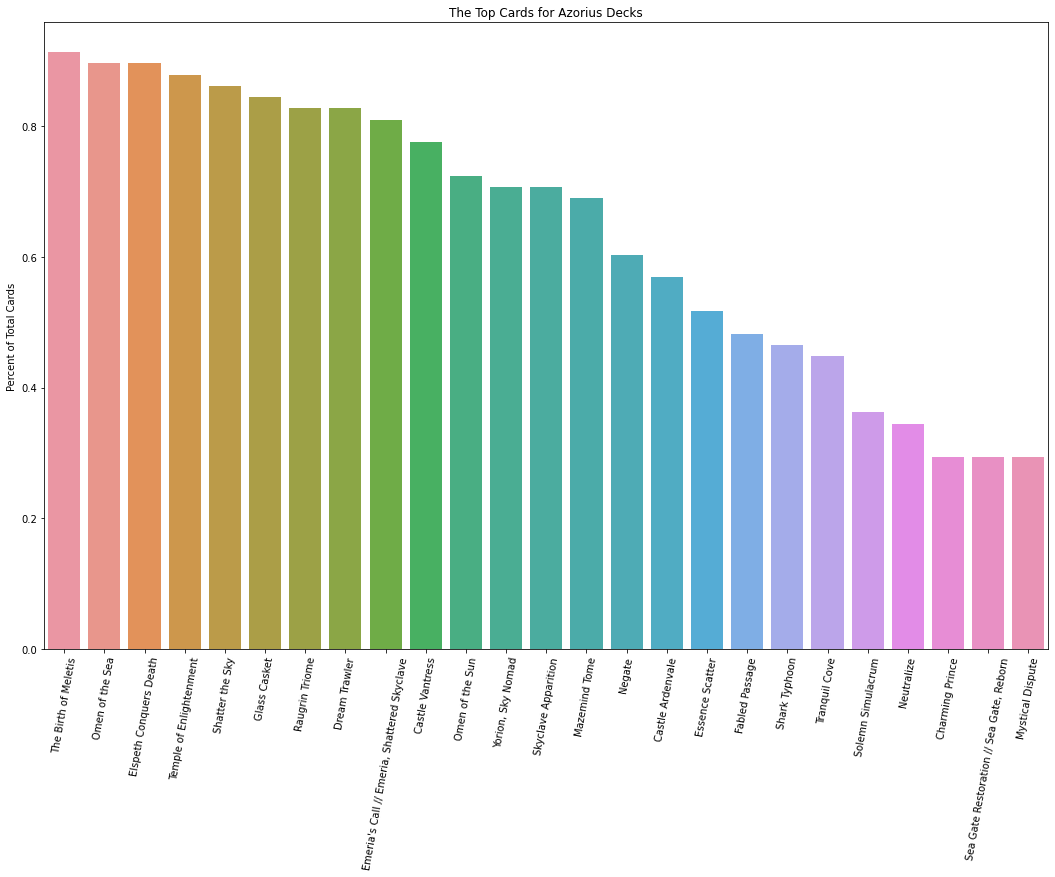

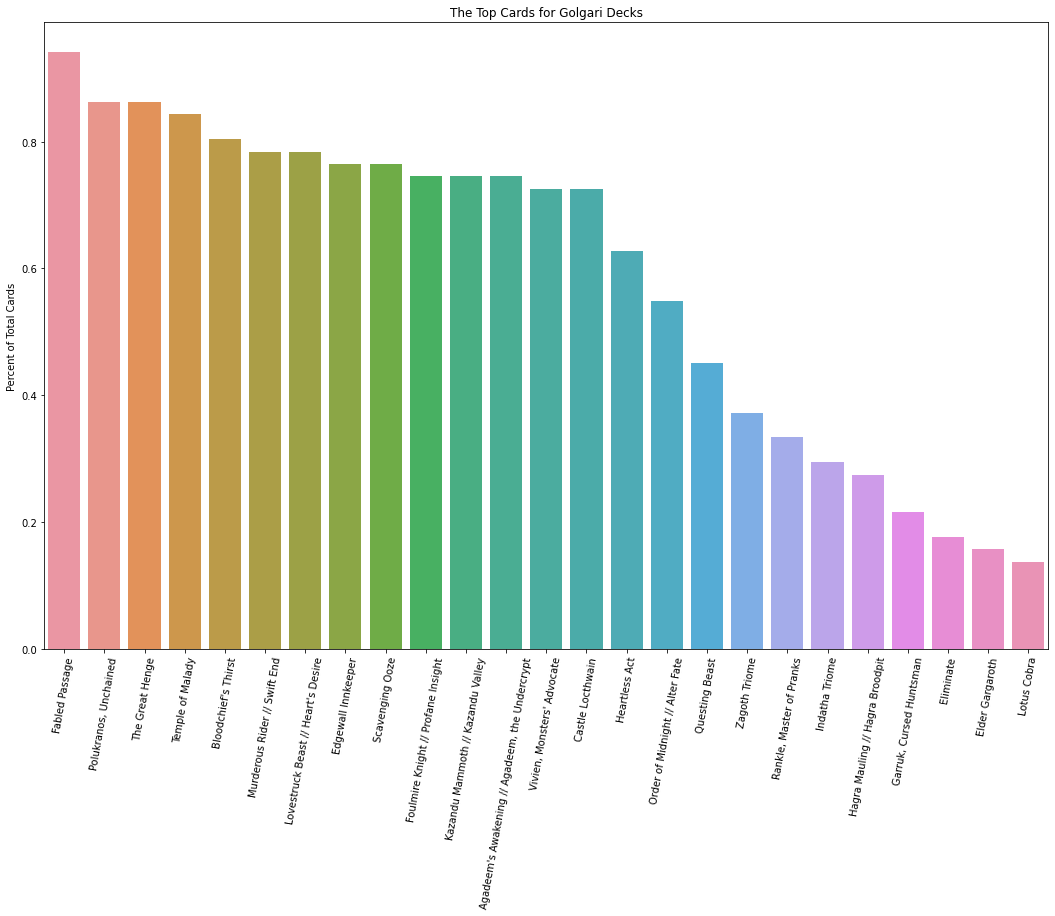

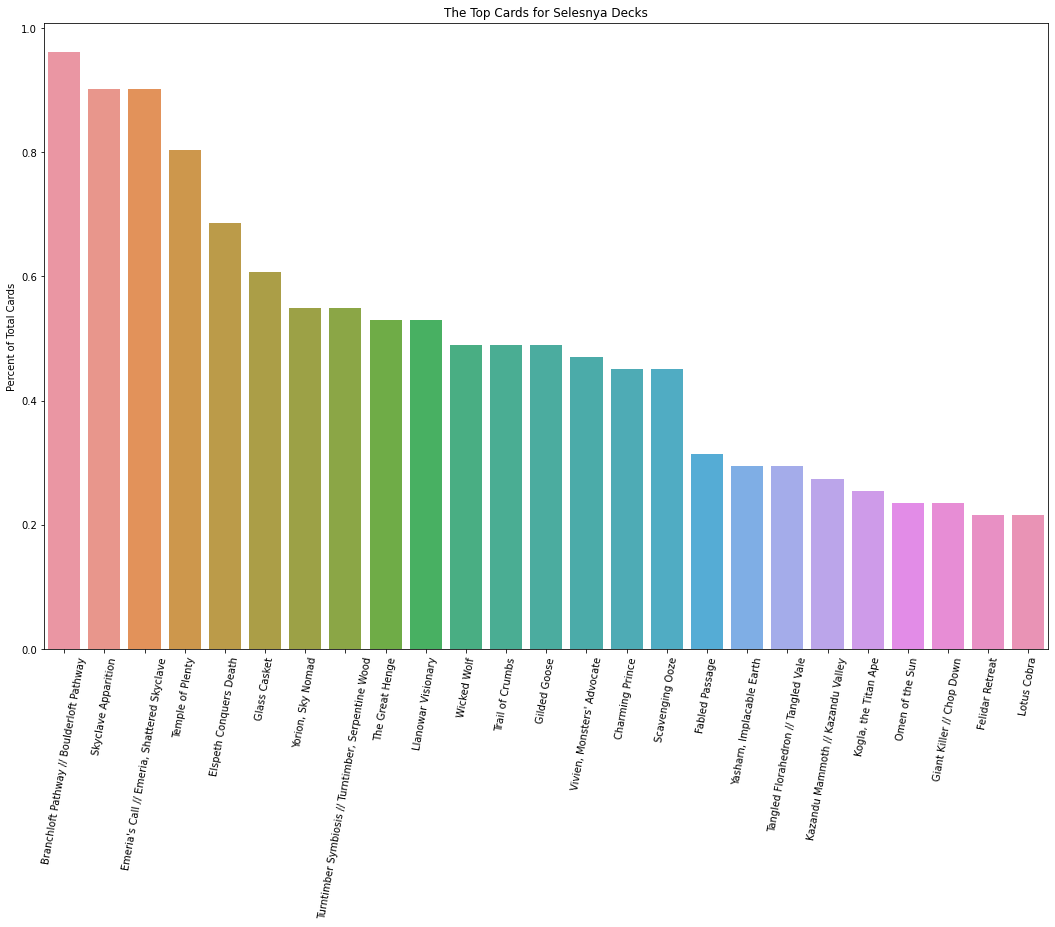

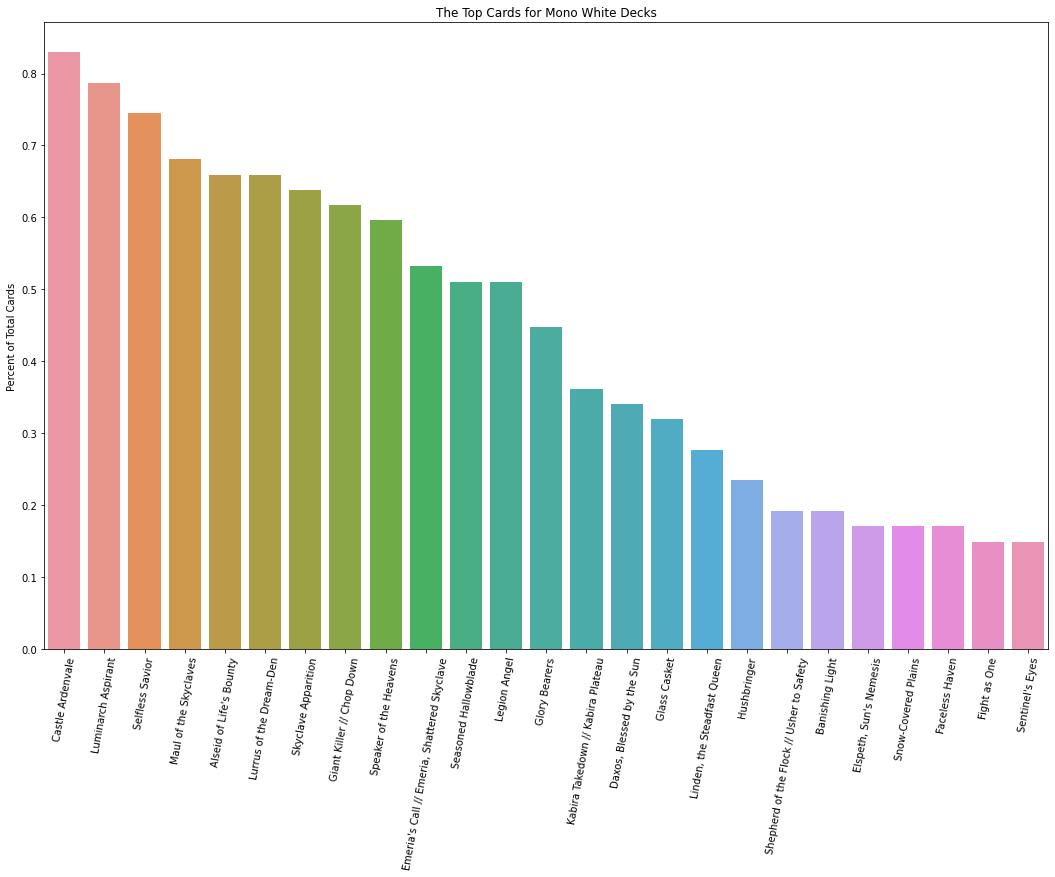

In [18]:
def top_15_categories(df, show=False, pdf=None):
    top_15_categories = deck_table["category"].value_counts().index[:15]
    for category in top_15_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

top_15_categories(main_decks, show=True)

In [19]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

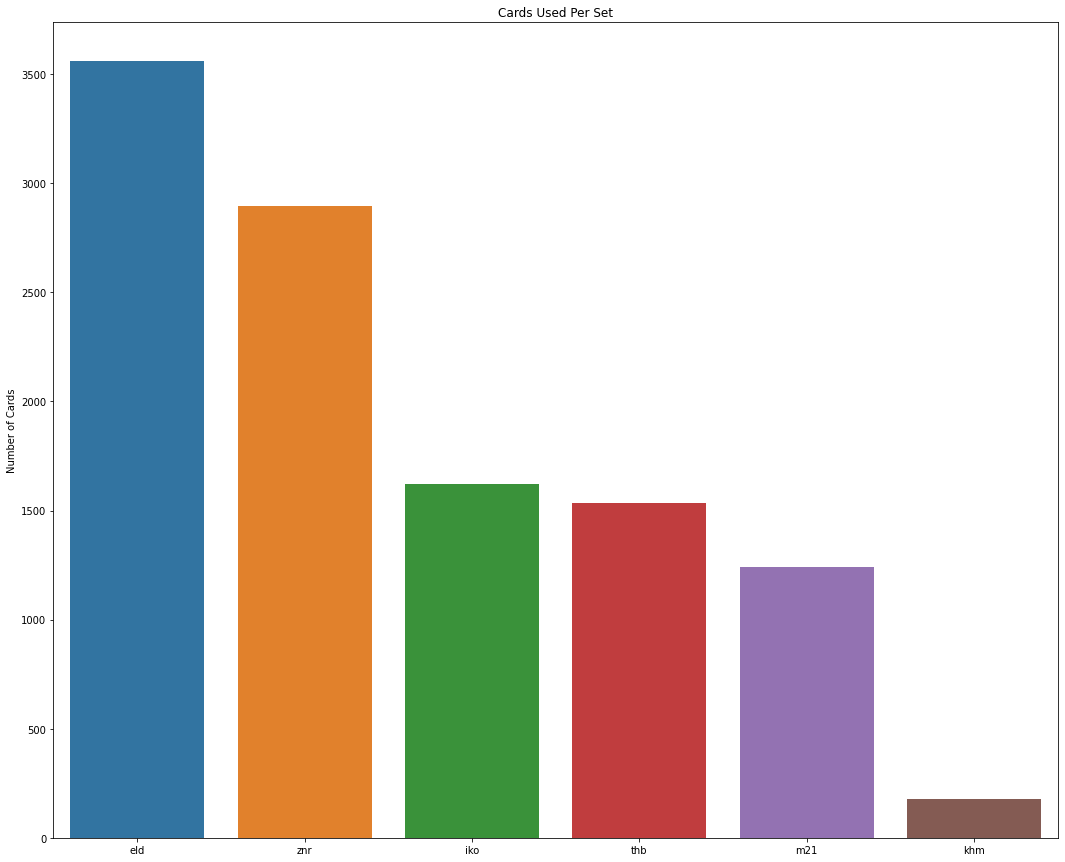

In [20]:
cards_by_set(main_decks,show=True)

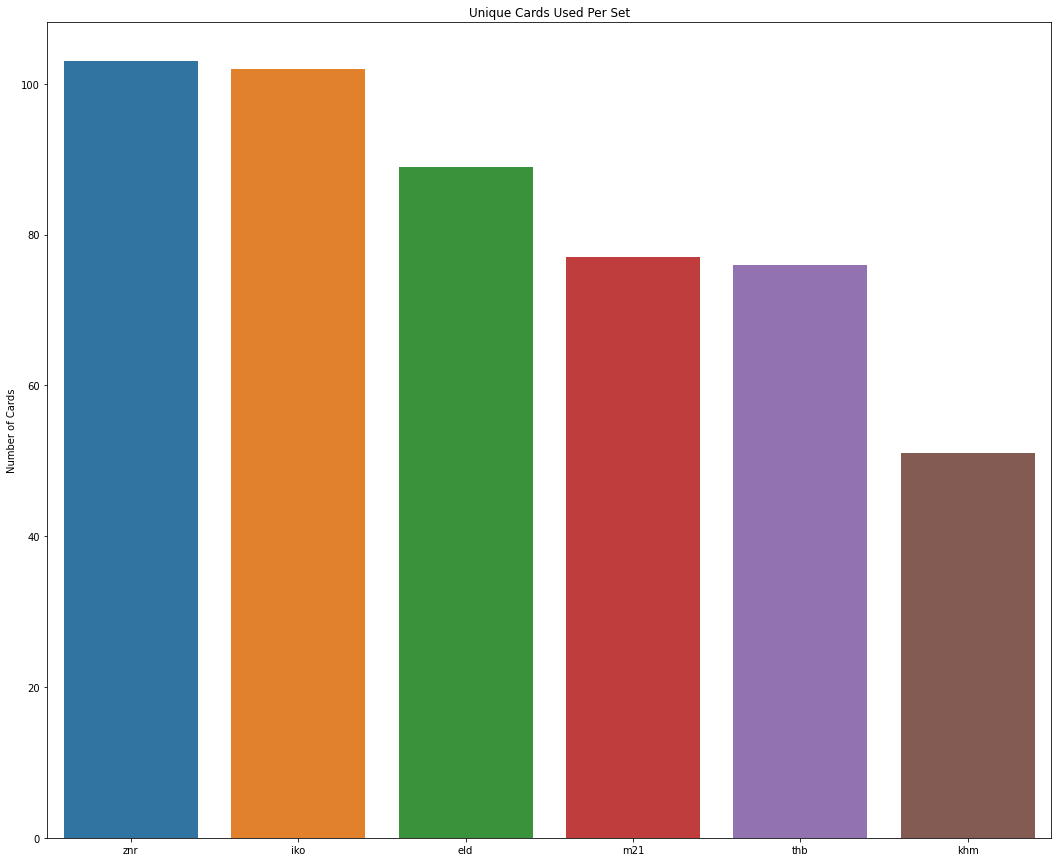

In [21]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [22]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

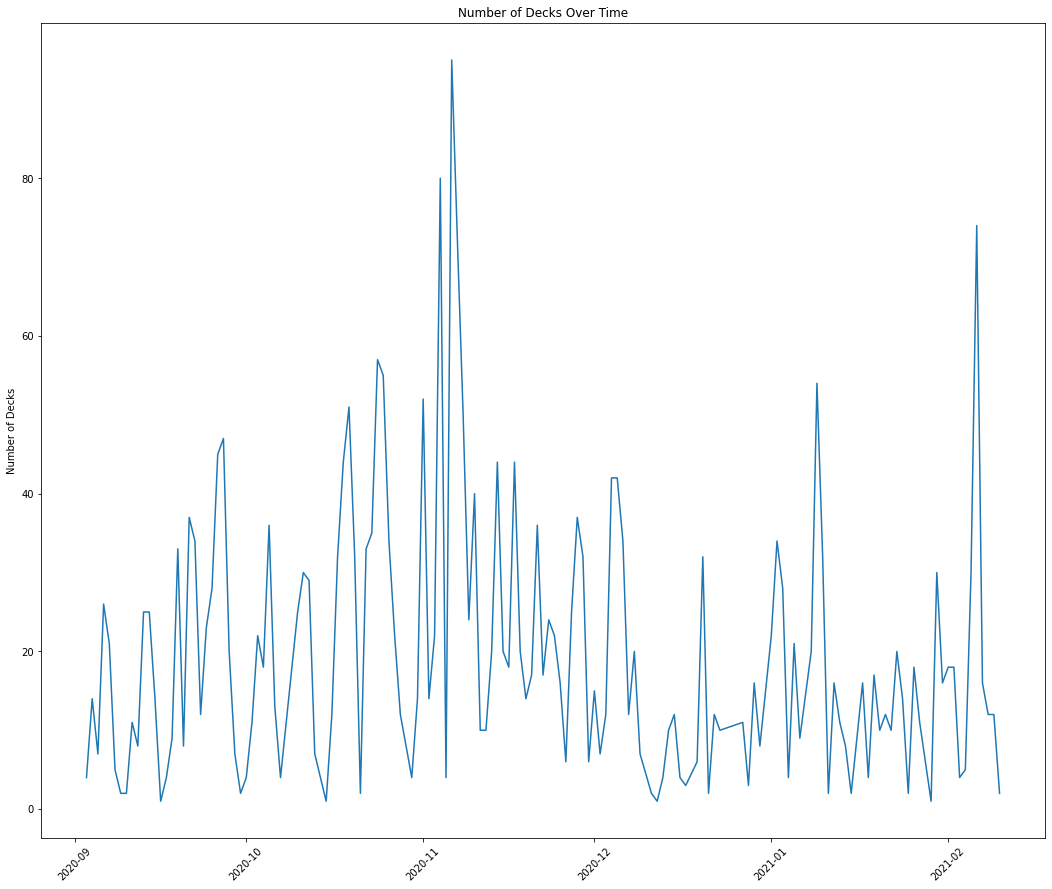

In [23]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

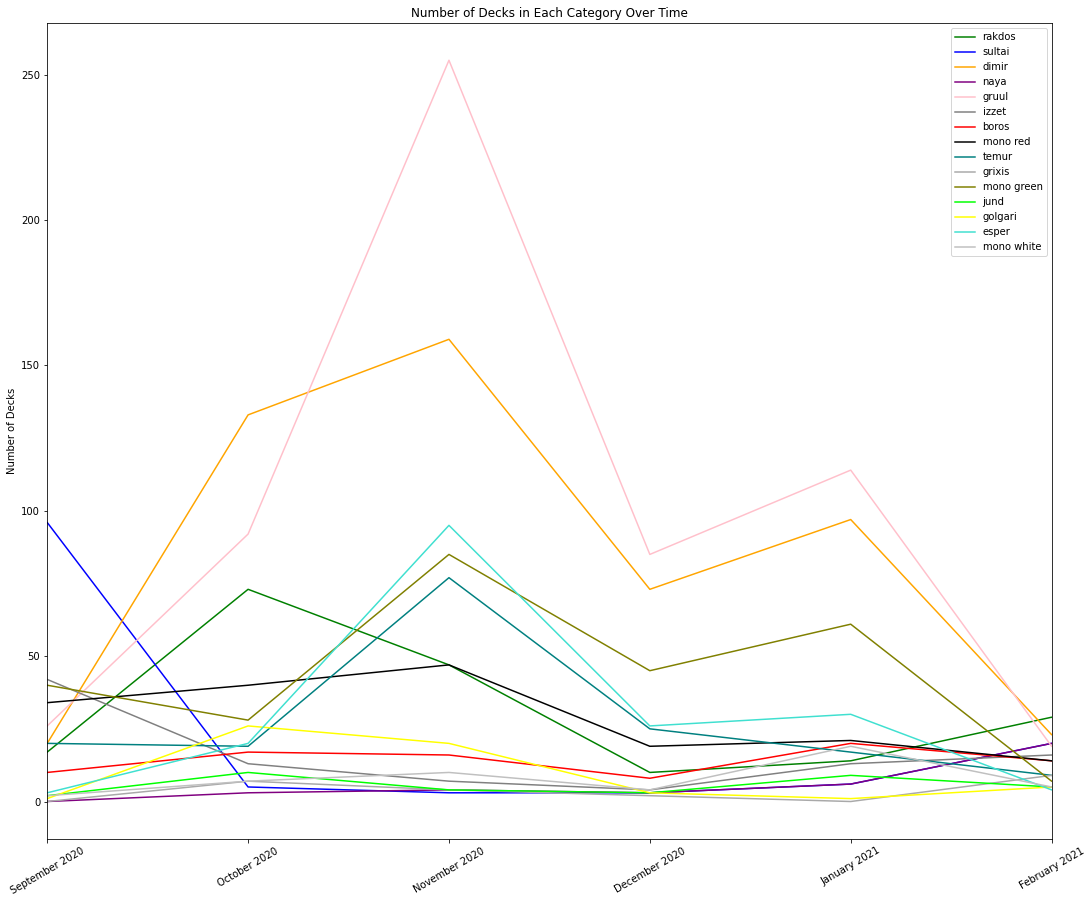

In [76]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_categories = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

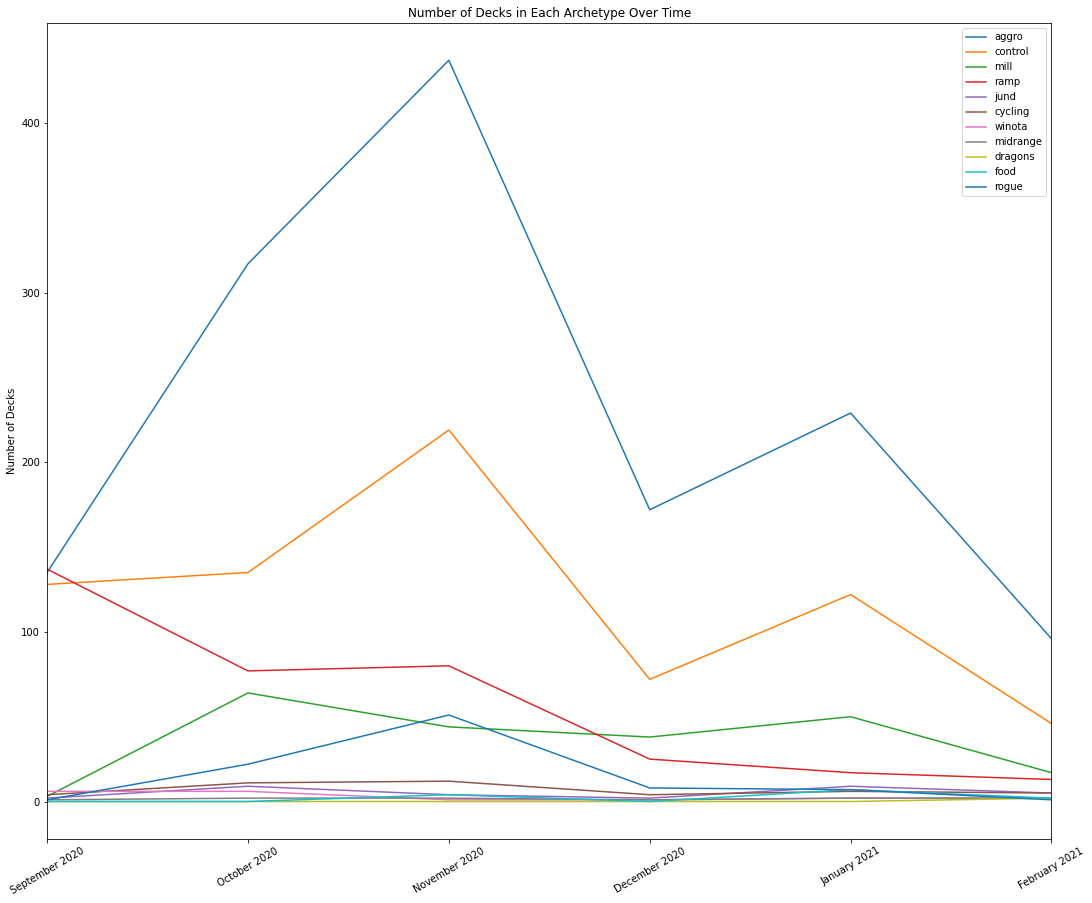

In [25]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [26]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [27]:
arena_vs_nonarena(full_table)

0.0

In [28]:
masked_table = full_table.copy()

In [29]:
cat_count = masked_table["category"].value_counts()

In [30]:
cat_count

gruul         14622
dimir         13958
mono green     6311
esper          6090
4-color        6066
rakdos         5119
temur          4459
sultai         4178
mono red       3518
izzet          2689
boros          2063
azorius        1862
golgari        1501
selesnya       1358
mono white     1054
jund            975
naya            933
mono black      800
abzan           717
grixis          630
orzhov          437
jeskai          392
bant            295
simic           268
mono blue       192
mardu           135
colorless        94
5-color          75
Name: category, dtype: int64

In [31]:
mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

In [32]:
mask

0        False
1        False
2        False
3        False
4        False
         ...  
80786     True
80787     True
80788     True
80789     True
80790     True
Name: category, Length: 80791, dtype: bool

In [33]:
masked_table["category"][mask] = "other"

<ipython-input-33-367f14b33268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


In [34]:
masked_table

eventId                                                     name_event  \
0            1                                       FNM @ MTG Arena Campania   
1            1                                       FNM @ MTG Arena Campania   
2            1                                       FNM @ MTG Arena Campania   
3            1                                       FNM @ MTG Arena Campania   
4            1                                       FNM @ MTG Arena Campania   
...        ...                                                            ...   
80786      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   
80787      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   
80788      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   
80789      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   
80790      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   

            date  deckId  pilotId      name_deck firstName  lastName  cardId  \
0     2020-10-30       1        3    Gruul Aggro    Antimo  Morlando  261znr   
1     2020-10-30       1        3    Gruul Aggro    Antimo  Morlando  244eld   
2     2020-10-30       1        3    Gruul Aggro    Antimo  Morlando  266eld   
3     2020-10-30       1        3    Gruul Aggro    Antimo  Morlando  262eld   
4     2020-10-30       1        3    Gruul Aggro    Antimo  Morlando  115eld   
...          ...     ...      ...            ...       ...       ...     ...   
80786 2021-02-06    3014     1823  Golgari Aggro  Vladimir   Arneuve  206khm   
80787 2021-02-06    3014     1823  Golgari Aggro  Vladimir   Arneuve  270eld   
80788 2021-02-06    3014     1823  Golgari Aggro  Vladimir   Arneuve  247khm   
80789 2021-02-06    3014     1823  Golgari Aggro  Vladimir   Arneuve  099eld   
80790 2021-02-06    3014     1823  Golgari Aggro  Vladimir   Arneuve  082khm   

                                           name  count color slot archetype  \
0      Cragcrown Pathway // Timbercrown Pathway      4    GR   md     aggro   
1                                Fabled Passage      4   NaN   md     aggro   
2                                        Forest      9     G   md     aggro   
3                                      Mountain      5     R   md     aggro   
4                    Bonecrusher Giant // Stomp      4     R   md     aggro   
...                                         ...    ...   ...  ...       ...   
80786                      Binding the Old Gods      2    BG   sb     aggro   
80787                   Garruk, Cursed Huntsman      1    BG   sb     aggro   
80788                       Weathered Runestone      2   NaN   sb     aggro   
80789           Order of Midnight // Alter Fate      2     B   sb     aggro   
80790                            Crippling Fear      1     B   sb     aggro   

      category       latest_set  
0        gruul  Zendikar Rising  
1        gruul  Zendikar Rising  
2        gruul  Zendikar Rising  
3        gruul  Zendikar Rising  
4        gruul  Zendikar Rising  
...        ...              ...  
80786    other         Kaldheim  
80787    other         Kaldheim  
80788    other         Kaldheim  
80789    other         Kaldheim  
80790    other         Kaldheim  

[80791 rows x 16 columns]

In [35]:
masked_table["category"].value_counts()

gruul         14622
dimir         13958
other         11718
mono green     6311
esper          6090
4-color        6066
rakdos         5119
temur          4459
sultai         4178
mono red       3518
izzet          2689
boros          2063
Name: category, dtype: int64

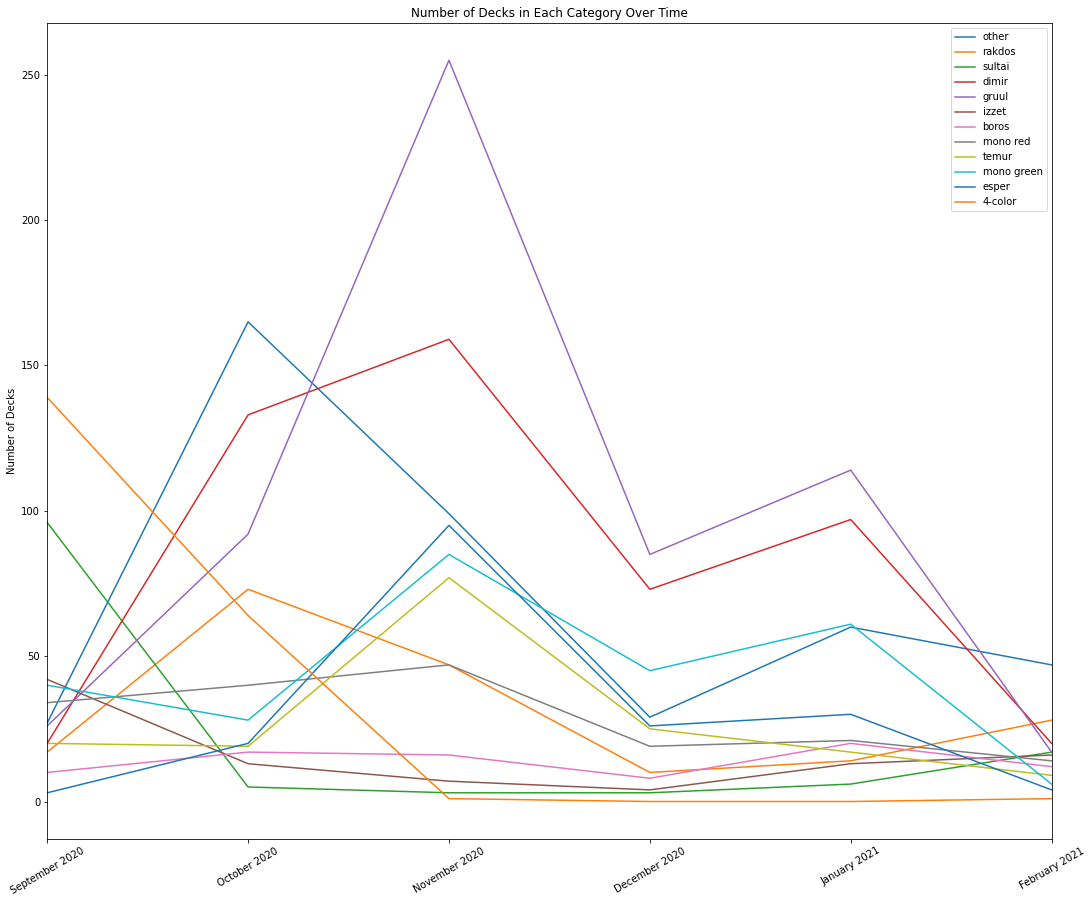

In [36]:
categories_over_time(masked_table)

In [37]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [38]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

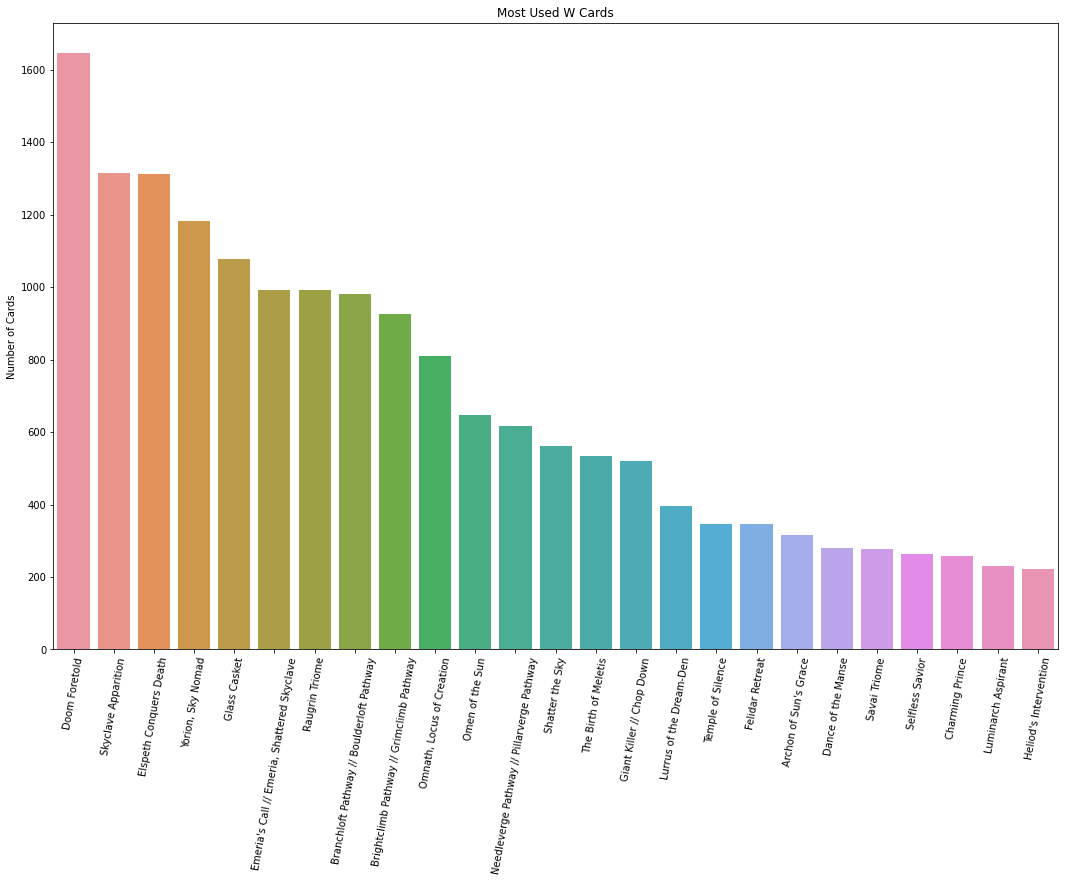

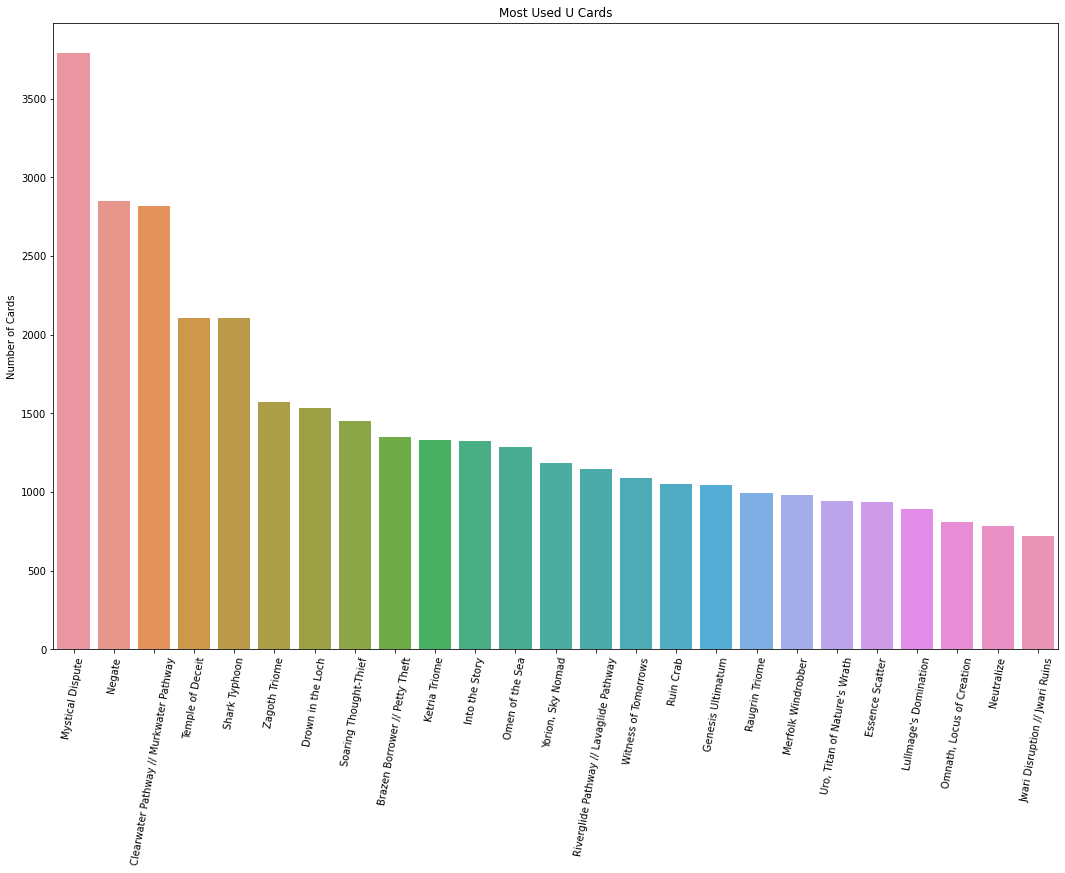

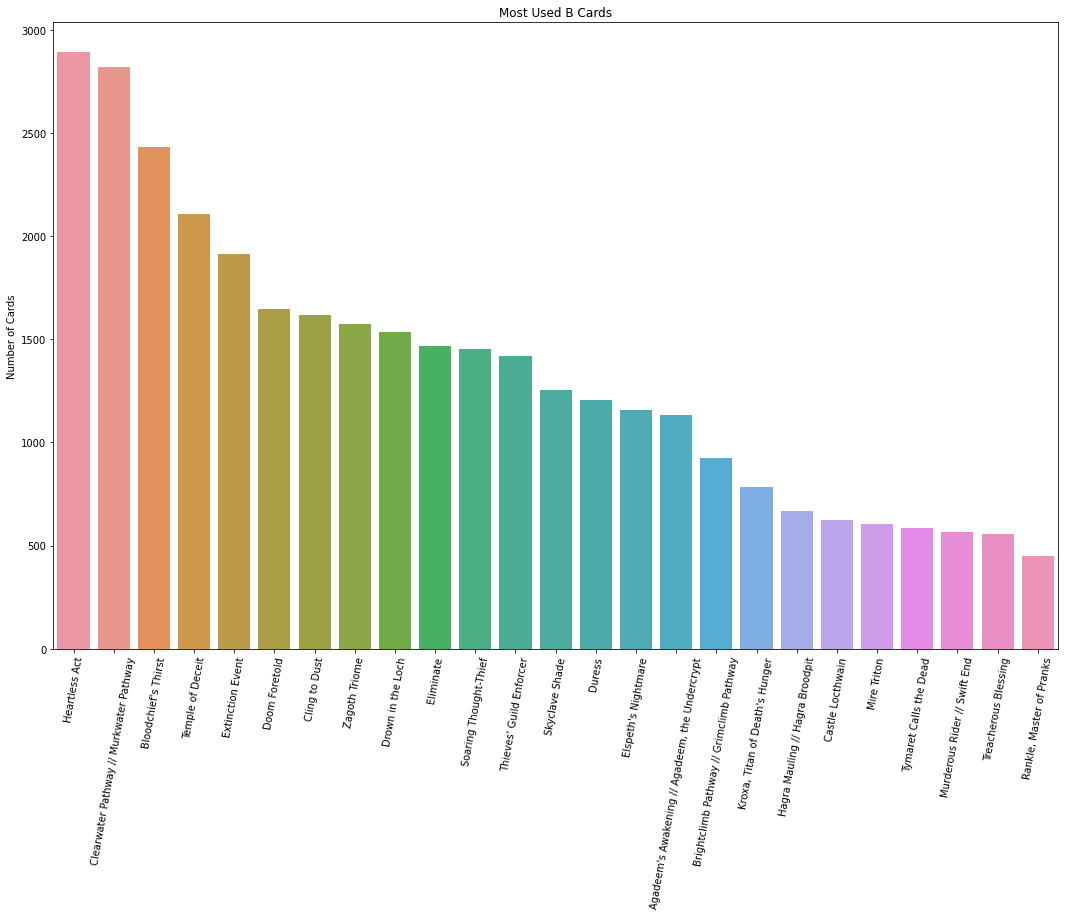

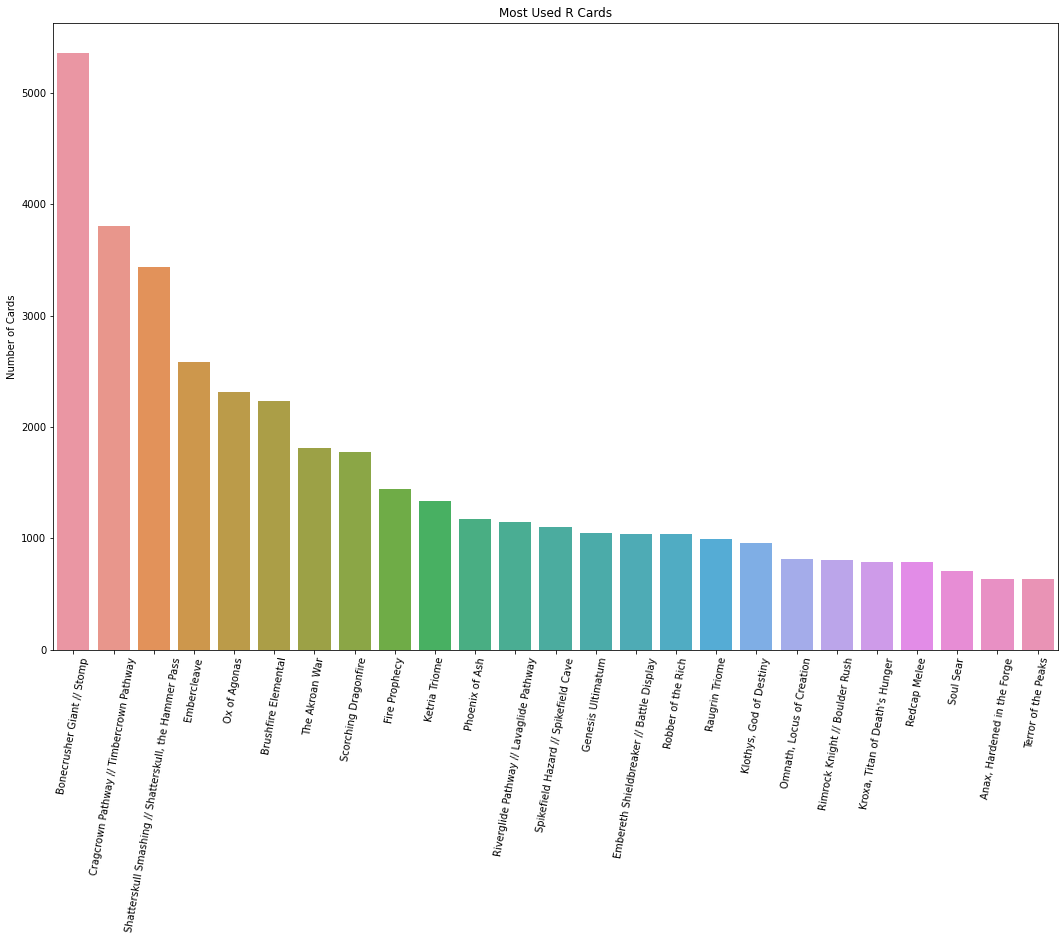

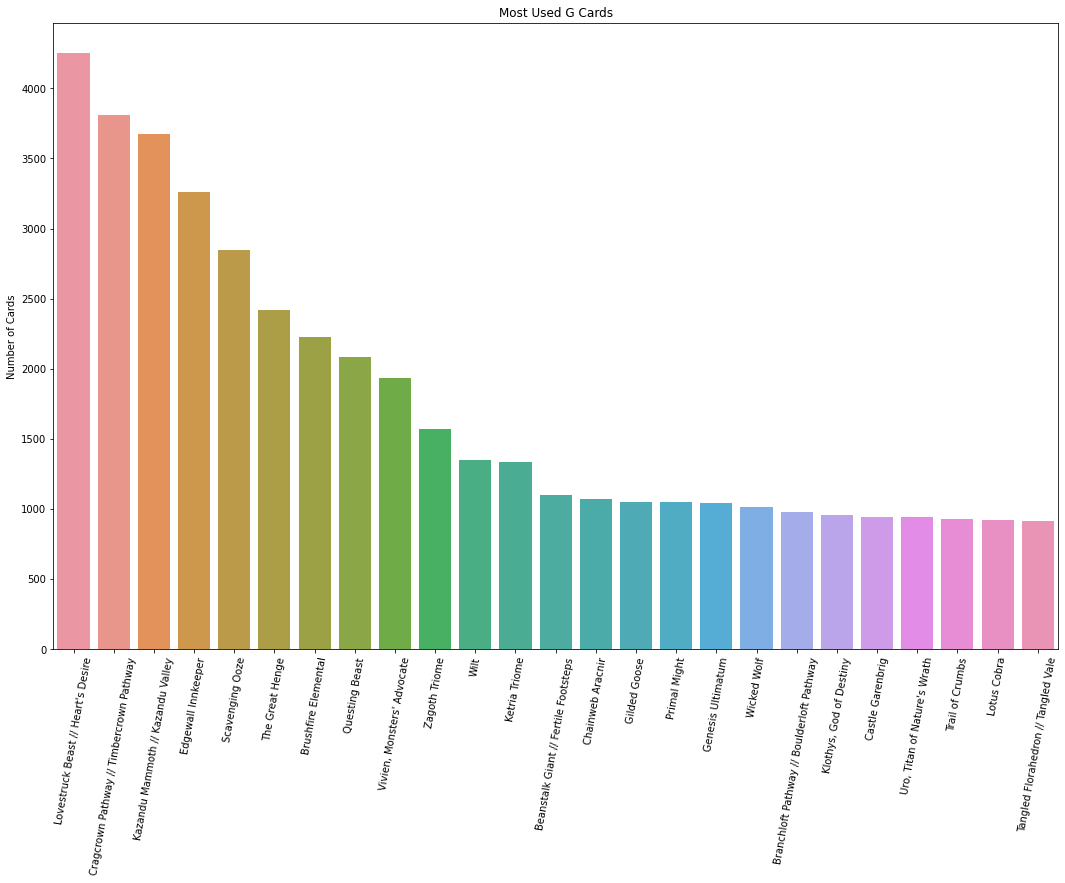

In [39]:
plot_color_dominance(full_table, show=True)

In [40]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [41]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

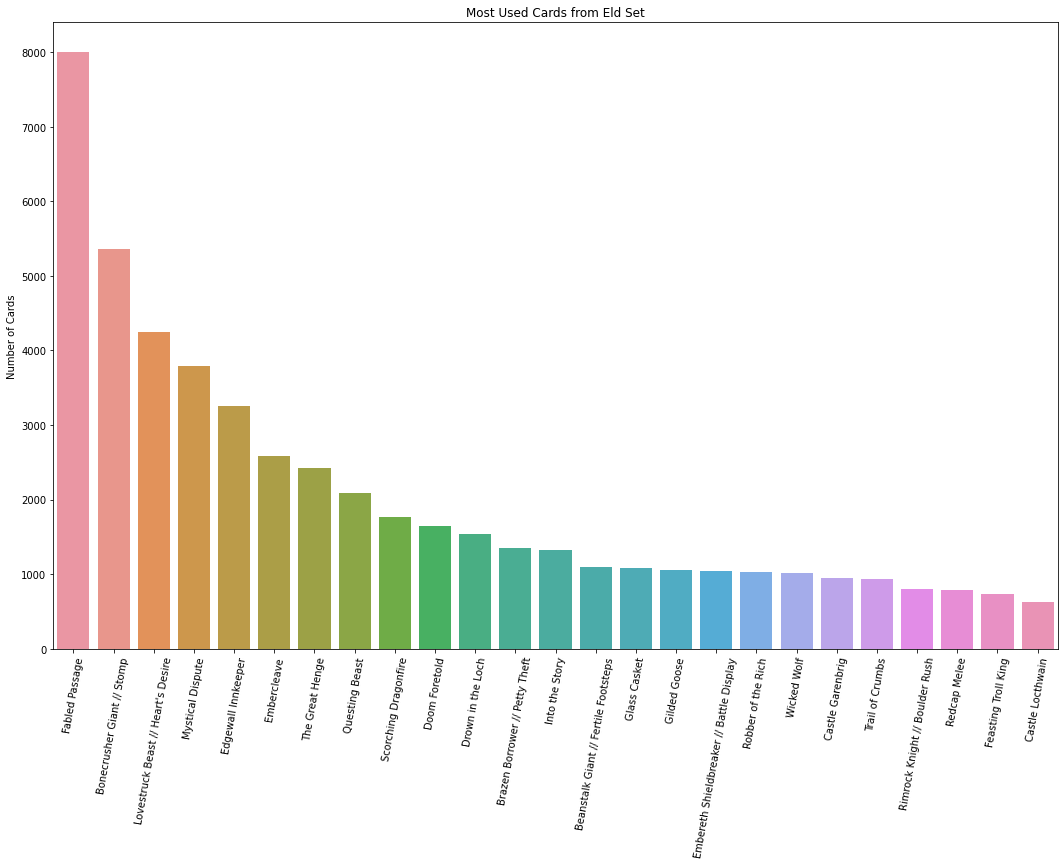

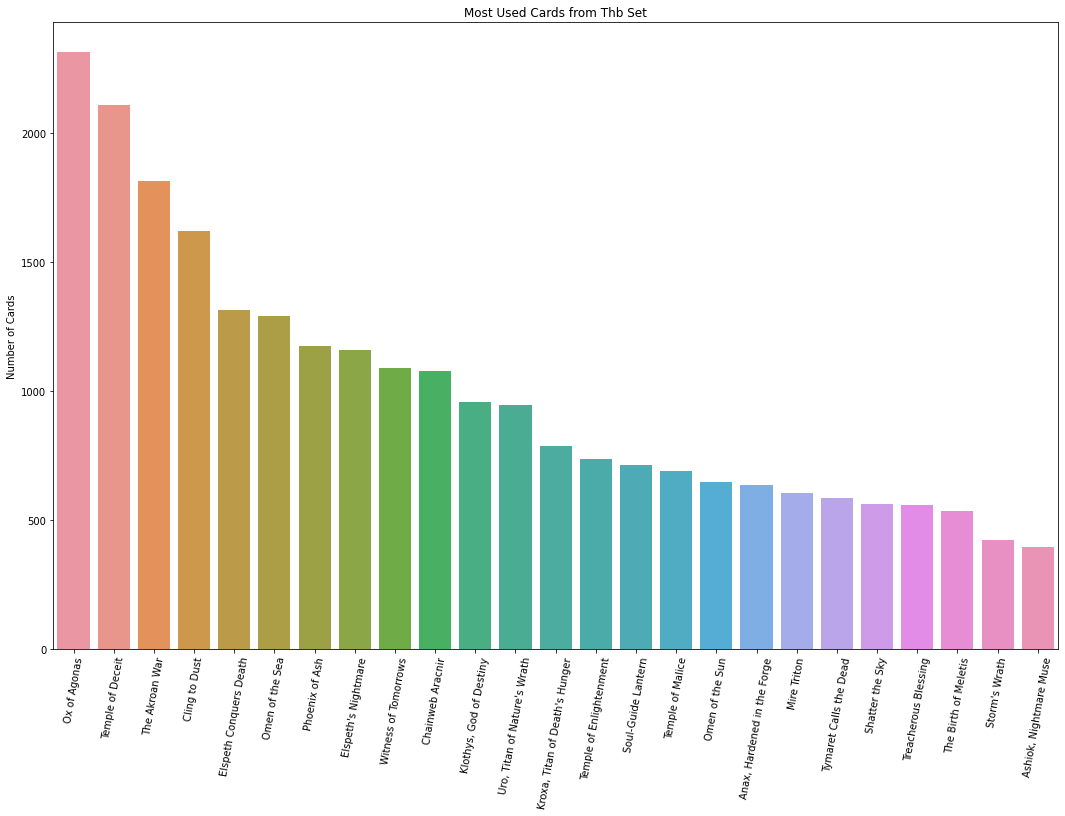

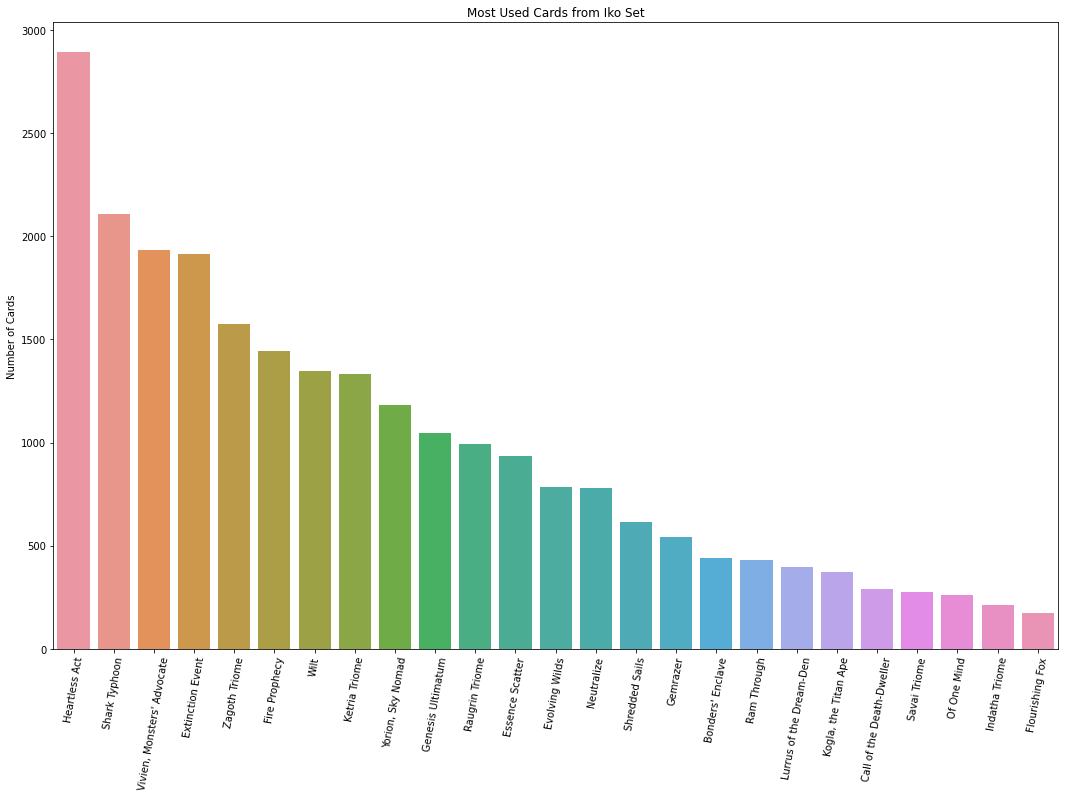

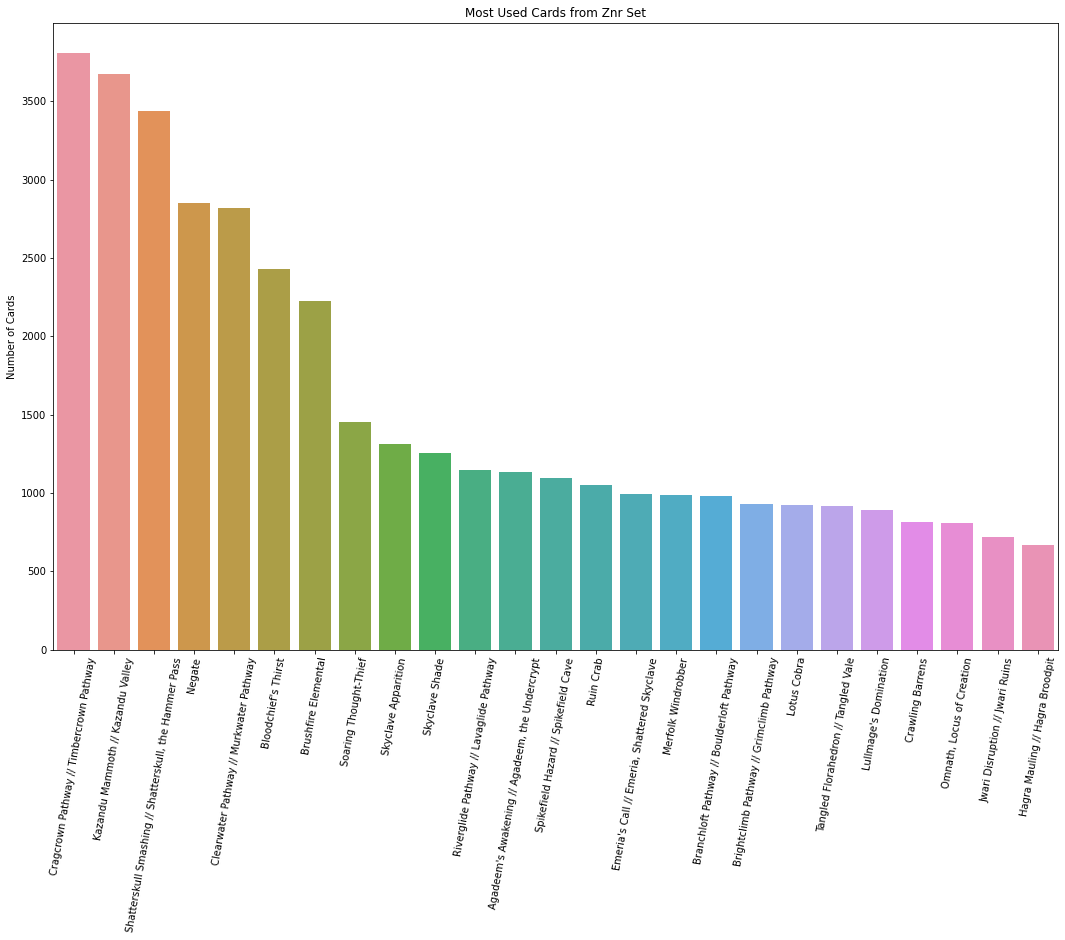

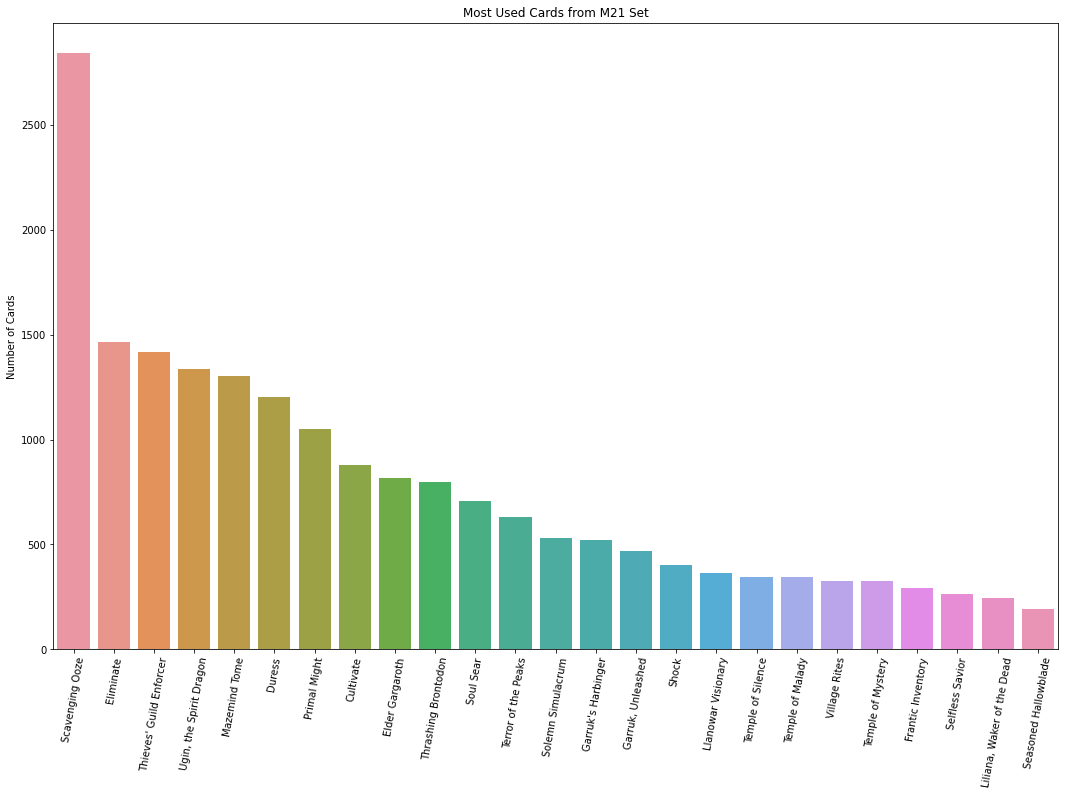

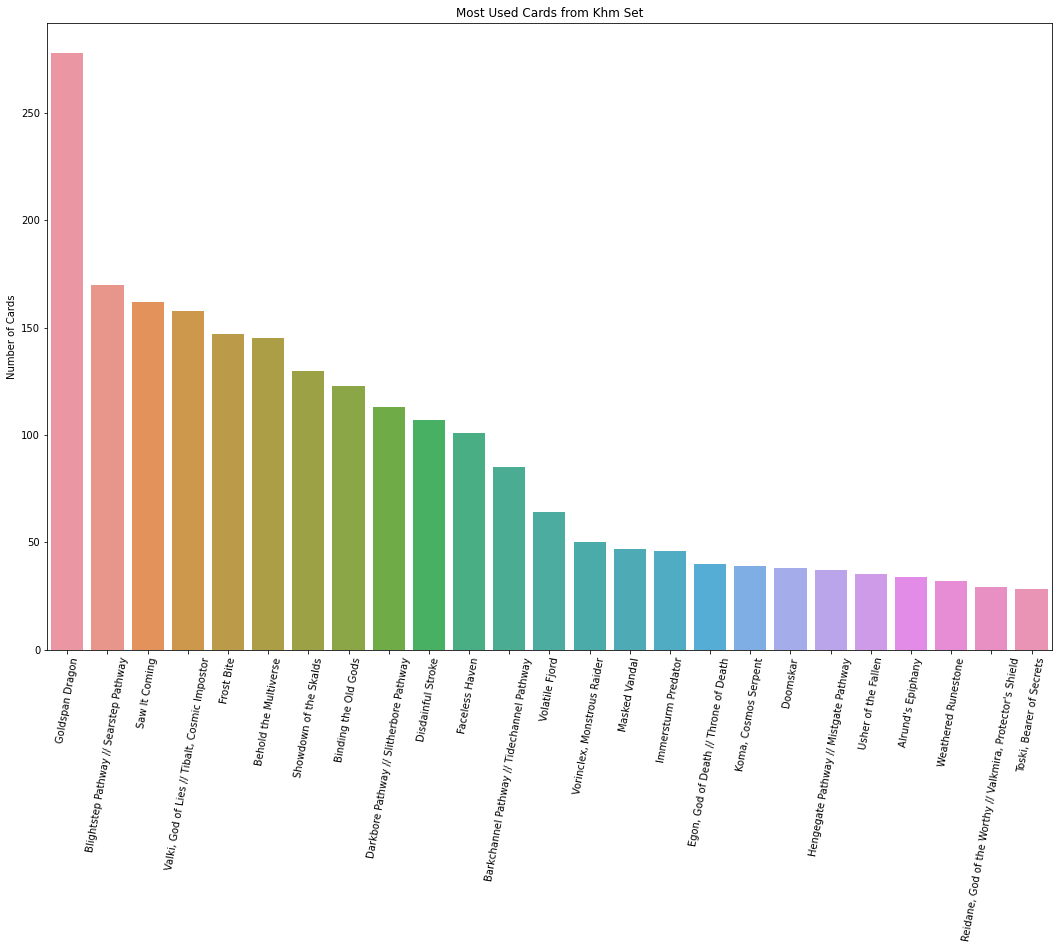

In [42]:
plot_set_dominance(full_table, show=True)

In [43]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [44]:
oracle_texts = oracle_text_analysis()

In [45]:
oracle_texts

name  \
4                                     Bonecrusher Giant // Stomp   
6         Shatterskull Smashing // Shatterskull, the Hammer Pass   
8                             Lovestruck Beast // Heart's Desire   
10                             Kazandu Mammoth // Kazandu Valley   
12                                               The Great Henge   
14                                                 Heartless Act   
18                                               Scavenging Ooze   
21                                                   Embercleave   
23                                            Edgewall Innkeeper   
24                                           Bloodchief's Thirst   
28                                              Temple of Deceit   
31                                                Questing Beast   
33                                           Brushfire Elemental   
35                                    Vivien, Monsters' Advocate   
37                Agadeem's Awakening // Agadeem, the Undercrypt   
41                                                     Eliminate   
43                                             Drown in the Loch   
44                                              Castle Locthwain   
46                                                 Cling to Dust   
47                                         Soaring Thought-Thief   
48                                              Extinction Event   
50                                       Thieves' Guild Enforcer   
52                                              Crawling Barrens   
54                                                Into the Story   
55                                               Essence Scatter   
61                               Hagra Mauling // Hagra Broodpit   
63                                                The Akroan War   
64                   Emeria's Call // Emeria, Shattered Skyclave   
66                                        Elspeth Conquers Death   
67                                           Skyclave Apparition   
69                                                  Primal Might   
71                                               Omen of the Sea   
72                                                 Fire Prophecy   
73                                                 Shark Typhoon   
75                                                 Mazemind Tome   
77                                           Elspeth's Nightmare   
78                                       Ugin, the Spirit Dragon   
82                                             Yorion, Sky Nomad   
84                                                        Negate   
97                                Brazen Borrower // Petty Theft   
99                                            Merfolk Windrobber   
100                         Spikefield Hazard // Spikefield Cave   
101                                                    Ruin Crab   
103                                                 Gilded Goose   
105                               Rimrock Knight // Boulder Rush   
109                                              Trail of Crumbs   
110                                               Evolving Wilds   
119                                                  Wicked Wolf   
121                          Tangled Florahedron // Tangled Vale   
122                                                 Glass Casket   
126                                             Castle Garenbrig   
128                              Jwari Disruption // Jwari Ruins   
129                                           Robber of the Rich   
131                                              Castle Vantress   
133                                              Omen of the Sun   
134                     Embereth Shieldbreaker // Battle Display   
136                                             Temple of Malice   
139                                          Feasting Troll King   
141                                             

In [79]:
from collections import Counter
from nltk.corpus import wordnet

In [115]:
help(wordnet.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [114]:
wordnet.synsets("enter")

[Synset('enter.v.01'),
 Synset('enter.v.02'),
 Synset('enroll.v.01'),
 Synset('figure.v.02'),
 Synset('record.v.01'),
 Synset('enter.v.06'),
 Synset('accede.v.02'),
 Synset('insert.v.01'),
 Synset('embark.v.02')]

In [116]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [117]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
    tokenized = word_tokenize(cleaned)
    
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = [word.lower() for word in lemmatized if word not in stop_words]
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [92]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

In [93]:
bigrams

bigram  freq  pct_total
43        enter battlefield   282   7.097911
28          target creature   182   4.580921
88                 end turn   122   3.070727
119               draw card   118   2.970048
73                  you may   106   2.668009
53                    t add   103   2.592499
104        creature control   103   2.592499
117            +1+1 counter    97   2.441480
51          battlefield tap    91   2.290461
133          card graveyard    91   2.290461
68           creature token    84   2.114271
185               mana cost    67   1.686383
180              cast spell    62   1.560534
547            discard card    58   1.459854
203            card library    55   1.384344
184            convert mana    52   1.308835
401        opponent control    50   1.258495
887                at begin    49   1.233325
116                put +1+1    48   1.208155
351                two card    48   1.208155
74                 may cast    47   1.182985
82      battlefield control    45   1.132645
128          counter target    43   1.082306
17            damage target    42   1.057136
123          destroy target    41   1.031966
136           creature card    40   1.006796
278        onto battlefield    40   1.006796
142                  1 life    40   1.006796
156            creature get    40   1.006796
182   creature planeswalker    37   0.931286
714             t sacrifice    35   0.880946
45                  may pay    35   0.880946
52                    tap t    35   0.880946
71               exile card    34   0.855776
108                you gain    33   0.830607
201                look top    33   0.830607
272          search library    32   0.805437
1077      whenever creature    31   0.780267
280         shuffle library    31   0.780267
47                   3 life    31   0.780267
157                get +1+1    30   0.755097
204             library you    30   0.755097
441             deal damage    30   0.755097
319               card hand    29   0.729927
342             control get    29   0.729927
205                 may put    29   0.729927
208          bottom library    29   0.729927
164           whenever cast    28   0.704757
222           combat damage    27   0.679587
4              target spell    27   0.679587
131            exile target    27   0.679587
217              cant block    27   0.679587
121              choose one    26   0.654417
548               card draw    26   0.654417
576         target opponent    26   0.654417
137                card put    26   0.654417
206                put card    25   0.629247
478           return target    25   0.629247
141                  gain 1    25   0.629247
678        activate ability    25   0.629247
110                  2 life    25   0.629247
699              three card    24   0.604078
64                create 11    24   0.604078
660              owner hand    24   0.604078
3004       enchant creature    24   0.604078
98                less cast    24   0.604078
666           damage player    24   0.604078
628                put hand    23   0.578908
755               land card    23   0.578908
75            cast creature    23   0.578908
451               token fly    21   0.528568
196                tap when    21   0.528568
489              one target    21   0.528568
1342      nonhuman creature    21   0.528568
230             deal combat    21   0.528568
202                top card    21   0.528568
94               this spell    20   0.503398
92                    add g    20   0.503398
1267             put target    20   0.503398
322                  gain 3    20   0.503398
219          creature power    20   0.503398
403              basic land    20   0.503398
65                 11 white    20   0.503398
330               cast card    20   0.503398
837         target artifact    19   0.478228
1062               x number    19   0.478228
562                     2 t    19   0.478228
521                  scry 2    19   0.478228
329           gr

In [94]:
trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

In [95]:
trigrams

bigram  freq  pct_total
55           enter battlefield tap    74   3.984922
207              convert mana cost    52   2.800215
125               put +1+1 counter    48   2.584814
78                    you may cast    40   2.154012
170        target creature control    38   2.046311
87       enter battlefield control    37   1.992461
57                       tap t add    34   1.830910
56               battlefield tap t    34   1.830910
230                library you may    28   1.507808
204   target creature planeswalker    27   1.453958
229               card library you    25   1.346257
153                    gain 1 life    25   1.346257
684                 card draw card    24   1.292407
683              discard card draw    23   1.238557
132        destroy target creature    23   1.238557
832           combat damage player    22   1.184707
263             deal combat damage    21   1.130856
220           battlefield tap when    21   1.130856
543             creature token fly    21   1.130856
397                  may cast card    20   1.077006
138        counter target creature    20   1.077006
386                    gain 3 life    20   1.077006
98                         t add g    20   1.077006
228               top card library    19   1.023156
395             card graveyard you    19   1.023156
86          land enter battlefield    18   0.969305
979        indestructible end turn    18   0.969305
323           put onto battlefield    18   0.969305
85             whenever land enter    17   0.915455
117                    gain 2 life    17   0.915455
946            rest bottom library    17   0.915455
8                    deal 2 damage    17   0.915455
657         damage target creature    17   0.915455
3305               at begin upkeep    17   0.915455
231                    you may put    17   0.915455
237                        t add u    17   0.915455
342                        t add b    16   0.861605
499                saga enter draw    16   0.861605
77                    card you may    16   0.861605
956                basic land card    16   0.861605
498                  as saga enter    16   0.861605
396              graveyard you may    16   0.861605
500                enter draw step    16   0.861605
502                  step add lore    16   0.861605
790                time could cast    16   0.861605
101                this spell cost    16   0.861605
504         lore counter sacrifice    16   0.861605
501                  draw step add    16   0.861605
503               add lore counter    16   0.861605
400          graveyard escape cost    15   0.807754
1809       creature card graveyard    15   0.807754
398            cast card graveyard    15   0.807754
915            target creature get    15   0.807754
84          landfall whenever land    15   0.807754
79               may cast creature    15   0.807754
1650         bottom library random    15   0.807754
1651          library random order    15   0.807754
351           counter target spell    15   0.807754
2169           +1+1 counter target    15   0.807754
897                     you gain 3    15   0.807754
1839      target nonhuman creature    15   0.807754
399          card graveyard escape    15   0.807754
506                sacrifice iii i    15   0.807754
505          counter sacrifice iii    15   0.807754
633            one target creature    15   0.807754
197                    you may pay    14   0.753904
346                    cost 3 less    14   0.753904
1837               cost put target    14   0.753904
1263                   lose 1 life    14   0.753904
332           target creature card    14   0.753904
1842          they mutate creature    14   0.753904
1836               mutate cost put    14   0.753904
1844             creature top plus    14   0.753904
80              cast creature late    14   0.753904
1845              top plus ability    14   0.753904
198             may pay additional    14   0.753904
1833                 if 

In [96]:
unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [97]:
unigrams

bigram  freq  pct_total
21       creature   671   6.085064
54           card   633   5.740455
4          target   388   3.518636
46        control   372   3.373538
32    battlefield   368   3.337263
31          enter   300   2.720595
12           turn   243   2.203682
75            put   223   2.022309
56           cast   210   1.904416
77        counter   204   1.850005
5           spell   192   1.741181
33            may   190   1.723043
39              t   181   1.641426
88           when   180   1.632357
0        whenever   179   1.623288
78           draw   173   1.568876
55            you   167   1.514464
114       library   166   1.505396
53          exile   165   1.496327
83      graveyard   156   1.414709
73           gain   154   1.396572
36           life   144   1.305886
68           cost   143   1.296817
125      opponent   143   1.296817
64            end   142   1.287748
40            add   140   1.269611
8          damage   138   1.251474
7               2   137   1.242405
86              1   136   1.233336
76           +1+1   128   1.160787
6            deal   128   1.160787
152          hand   124   1.124513
24             if   123   1.115444
38            tap   122   1.106375
107          mana   121   1.097307
51          token   114   1.033826
189     sacrifice   114   1.033826
62            get   111   1.006620
48         create   109   0.988483
20            two   106   0.961277
127        player   102   0.925002
79            one    97   0.879659
16              x    90   0.816178
59           land    85   0.770835
210     permanent    82   0.743629
113           top    81   0.734561
35              3    81   0.734561
231       discard    75   0.680149
269       ability    72   0.652943
44         attack    69   0.625737
69           less    67   0.607600
141        return    67   0.607600
142        number    67   0.607600
18         choose    66   0.598531
10           cant    64   0.580394
34            pay    61   0.553188
421        mutate    60   0.544119
157        flying    60   0.544119
171       another    58   0.525982
80        destroy    57   0.516913
71          power    56   0.507844
106       convert    52   0.471570
262         begin    51   0.462501
279      artifact    51   0.462501
105  planeswalker    51   0.462501
146         equal    50   0.453432
151          lose    50   0.453432
322            at    49   0.444364
28             as    46   0.417158
82          three    46   0.417158
49          white    45   0.408089
94        trample    44   0.399021
123        combat    44   0.399021
122         block    43   0.389952
342   enchantment    42   0.380883
187          step    42   0.380883
139          onto    42   0.380883
273           die    41   0.371815
203           fly    40   0.362746
111          scry    40   0.362746
27        instead    39   0.353677
120         haste    39   0.353677
268      activate    38   0.344609
237        reveal    38   0.344609
47             11    37   0.335540
245         color    37   0.335540
37           dont    35   0.317403
108          kick    35   0.317403
112          look    35   0.317403
140       shuffle    35   0.317403
138        search    34   0.308334
9      controller    34   0.308334
175             4    34   0.308334
19          among    34   0.308334
87          flash    34   0.308334
67           this    33   0.299265
516       enchant    33   0.299265
41              r    33   0.299265
327      lifelink    33   0.299265
162          mill    33   0.299265

In [98]:
def analyze_card_text_by_archetype(df, show=False, pdf=None):
    archetypes = df["archetype"].unique()
    for archetype in archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

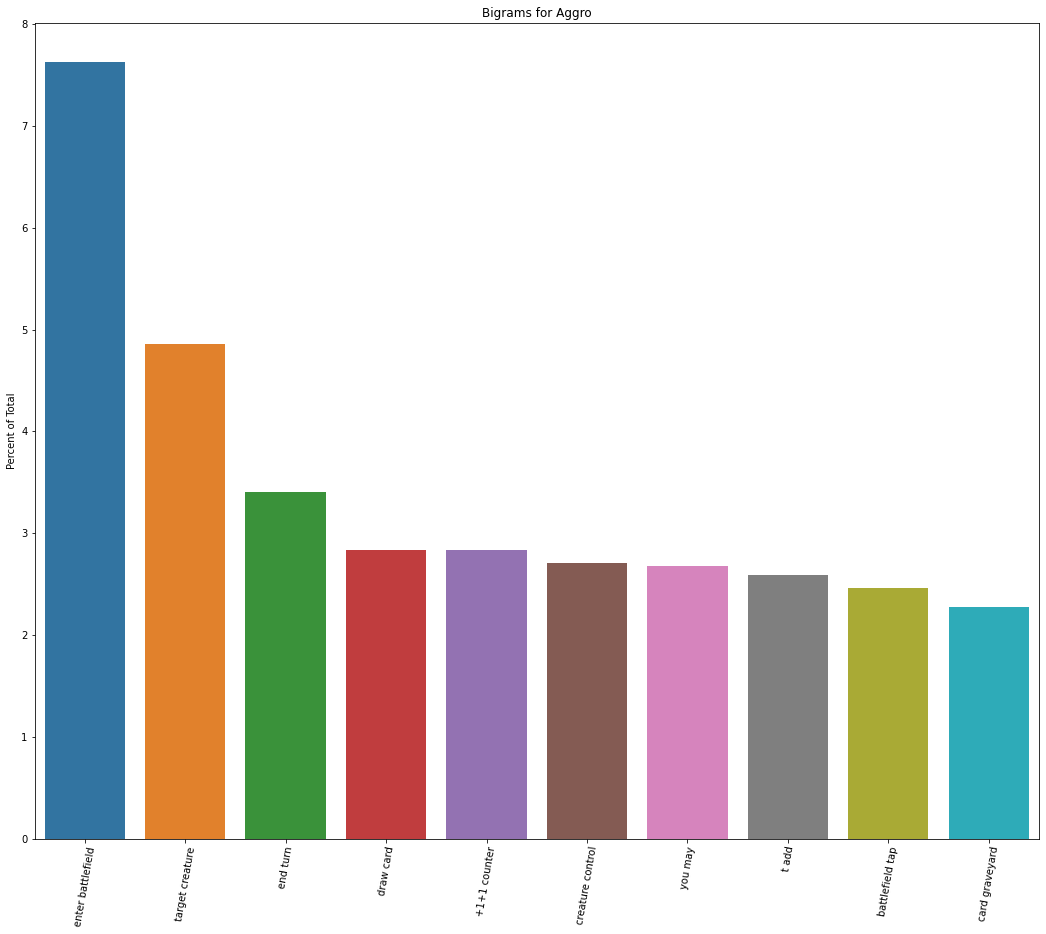

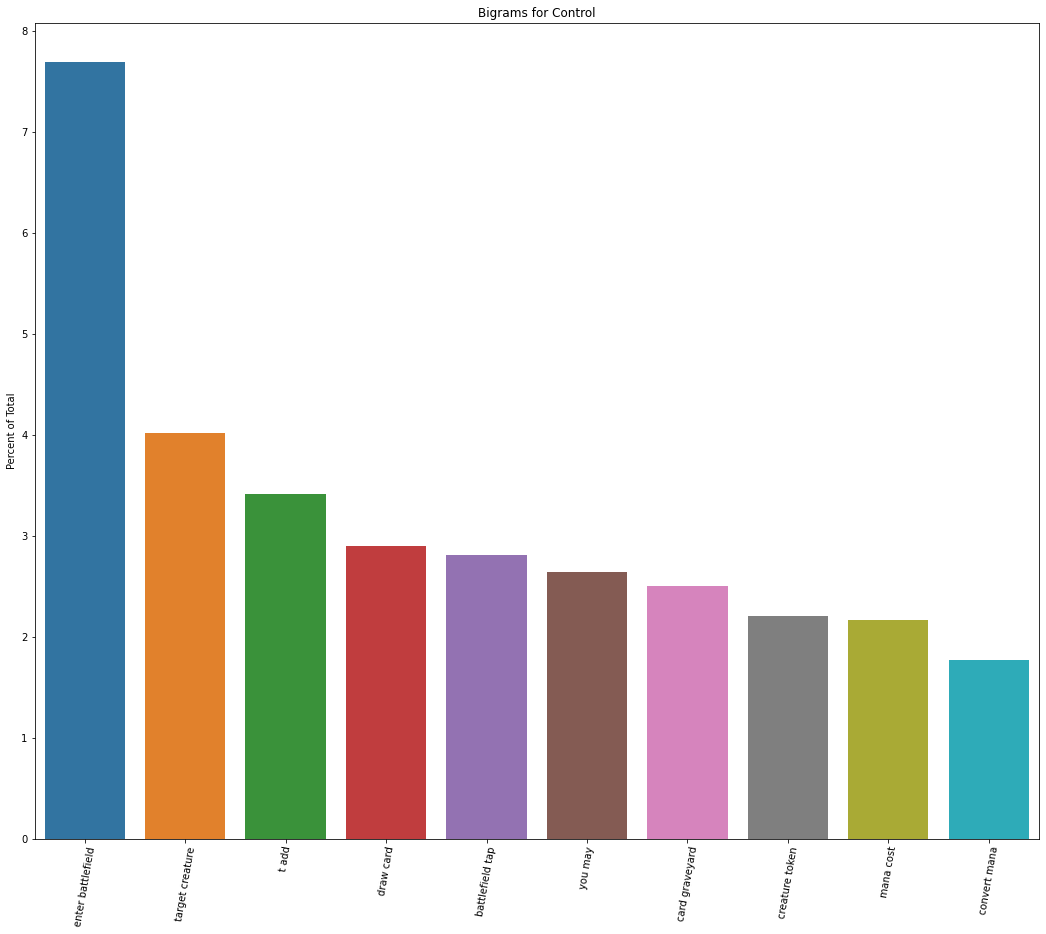

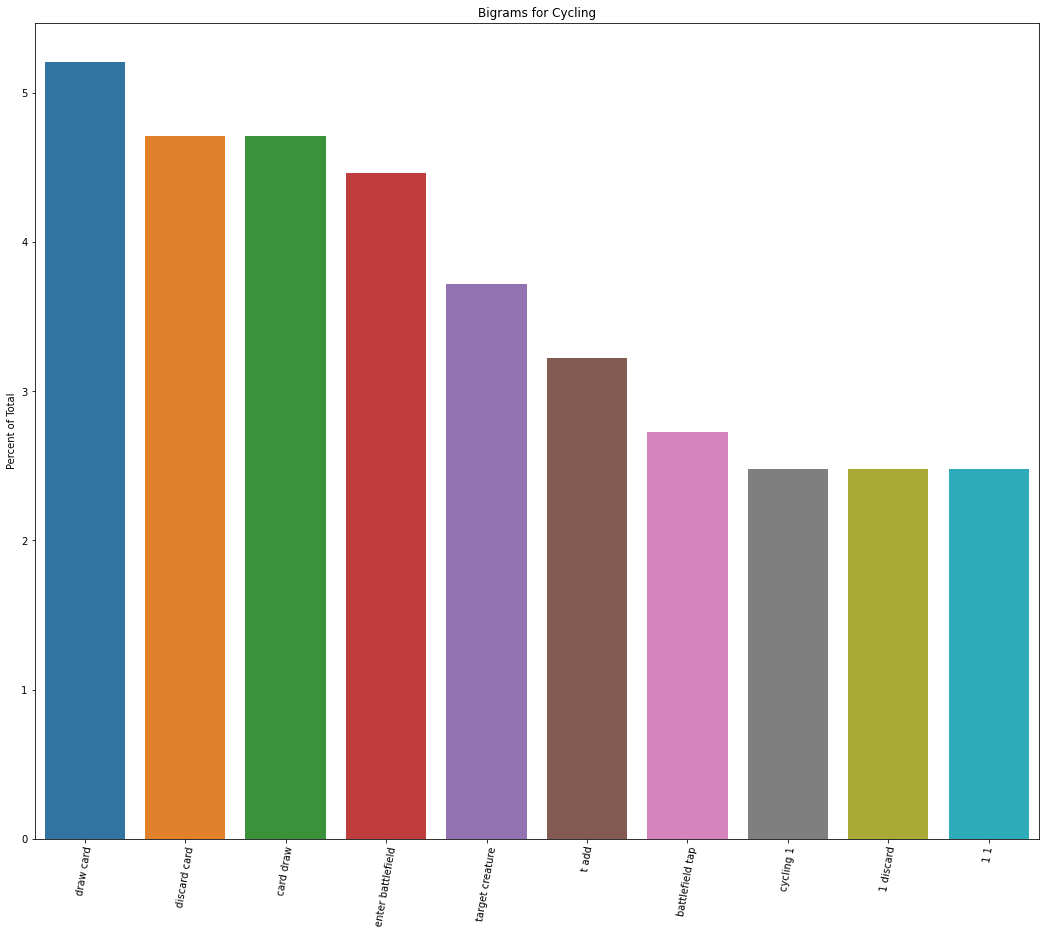

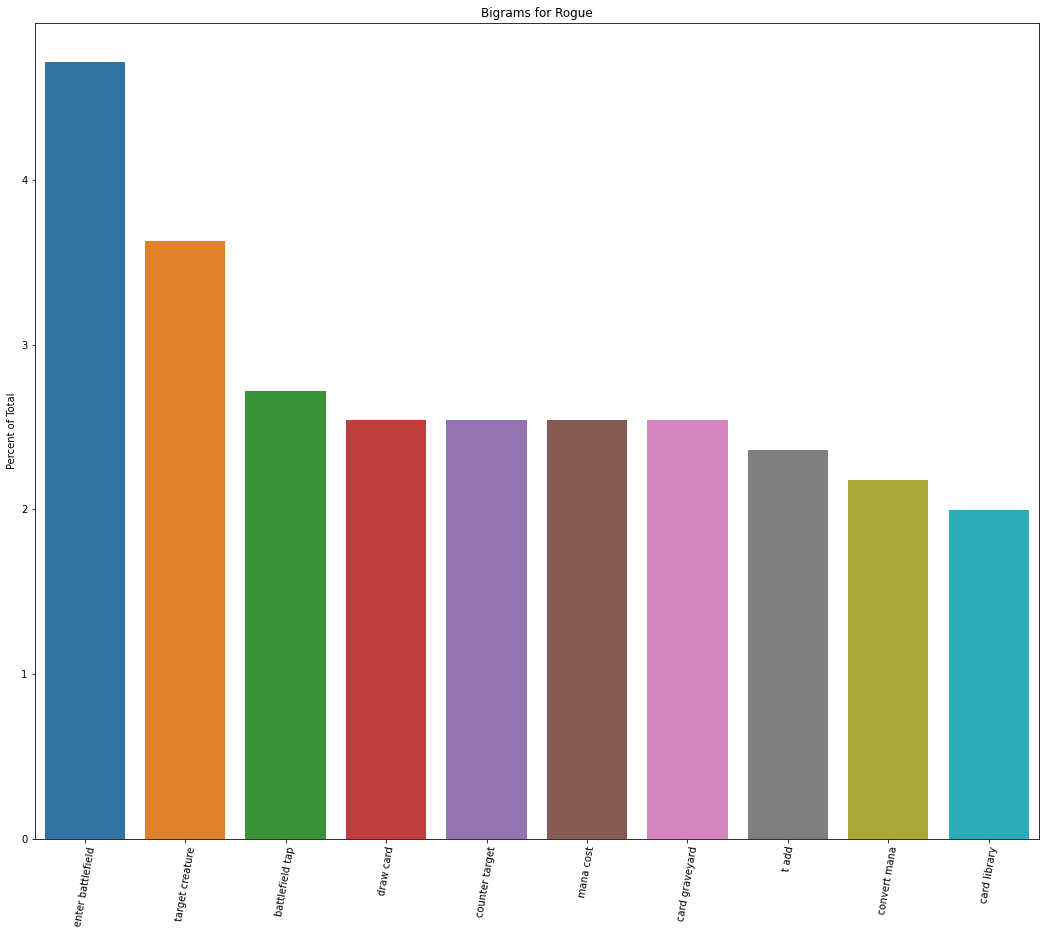

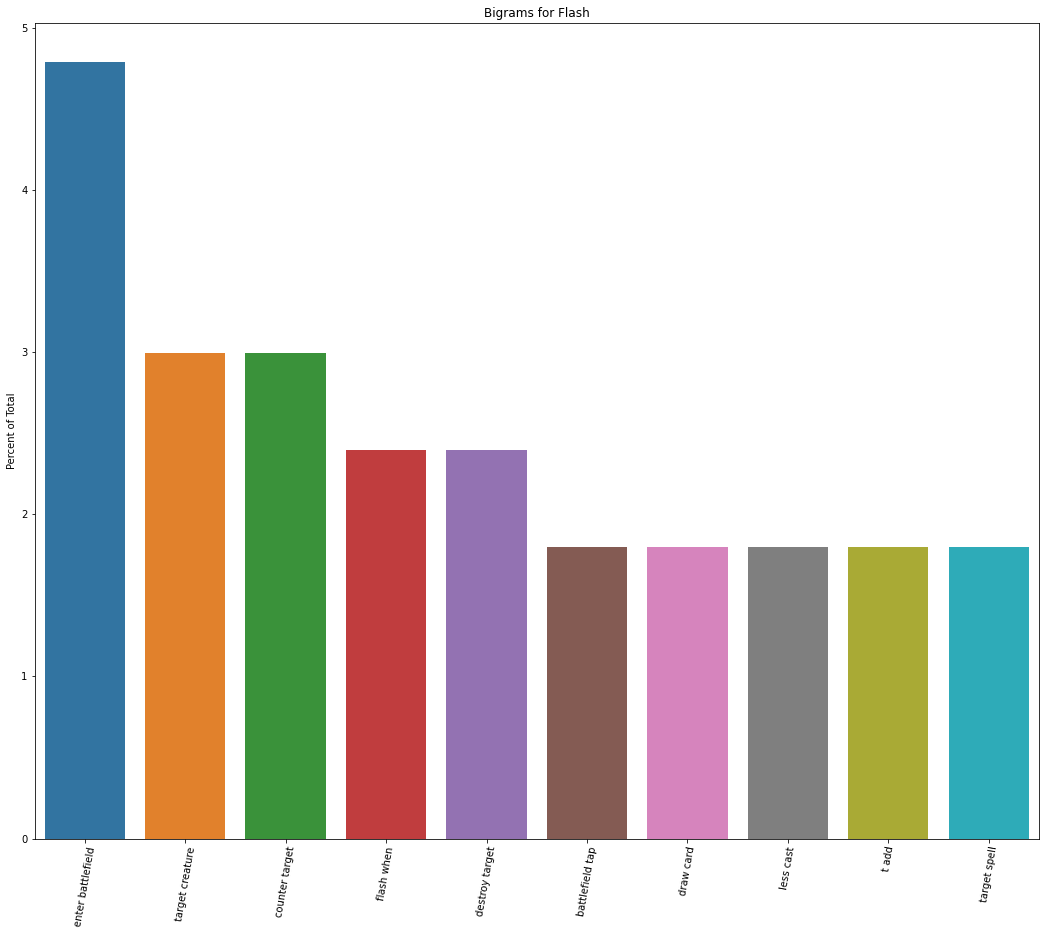

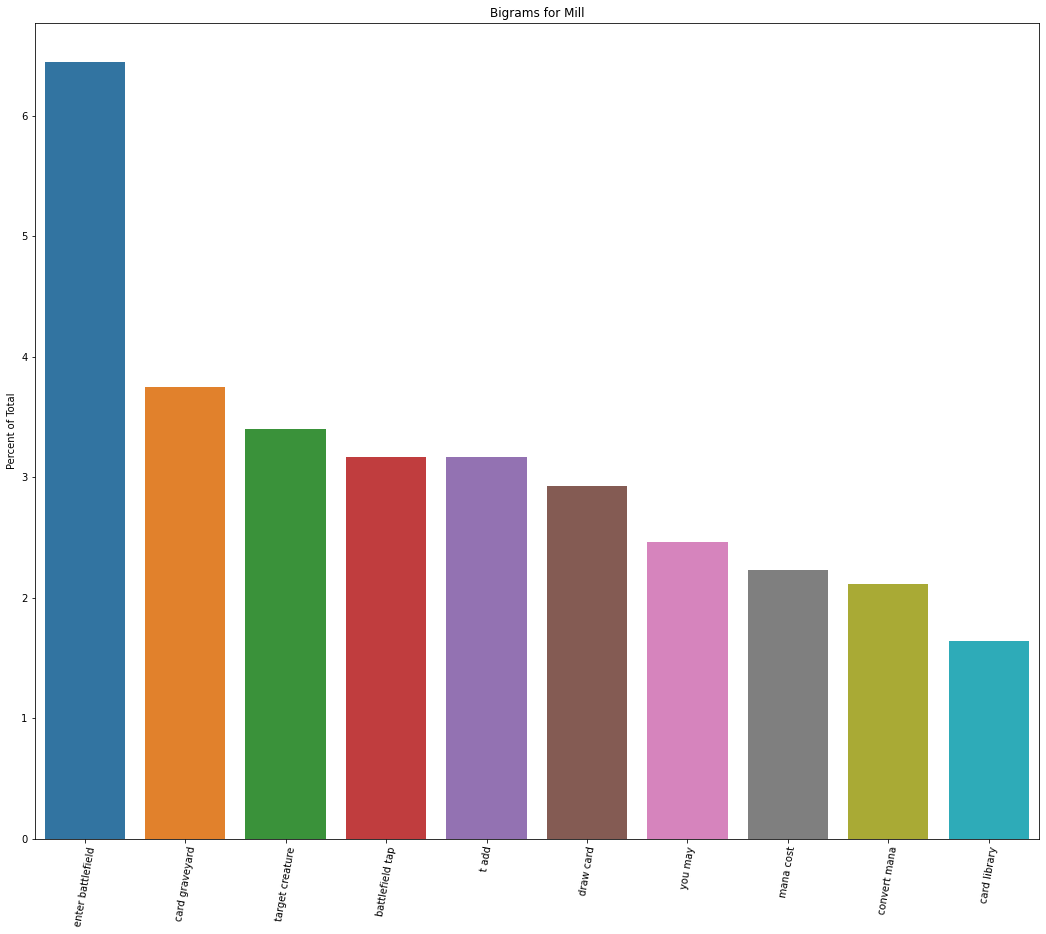

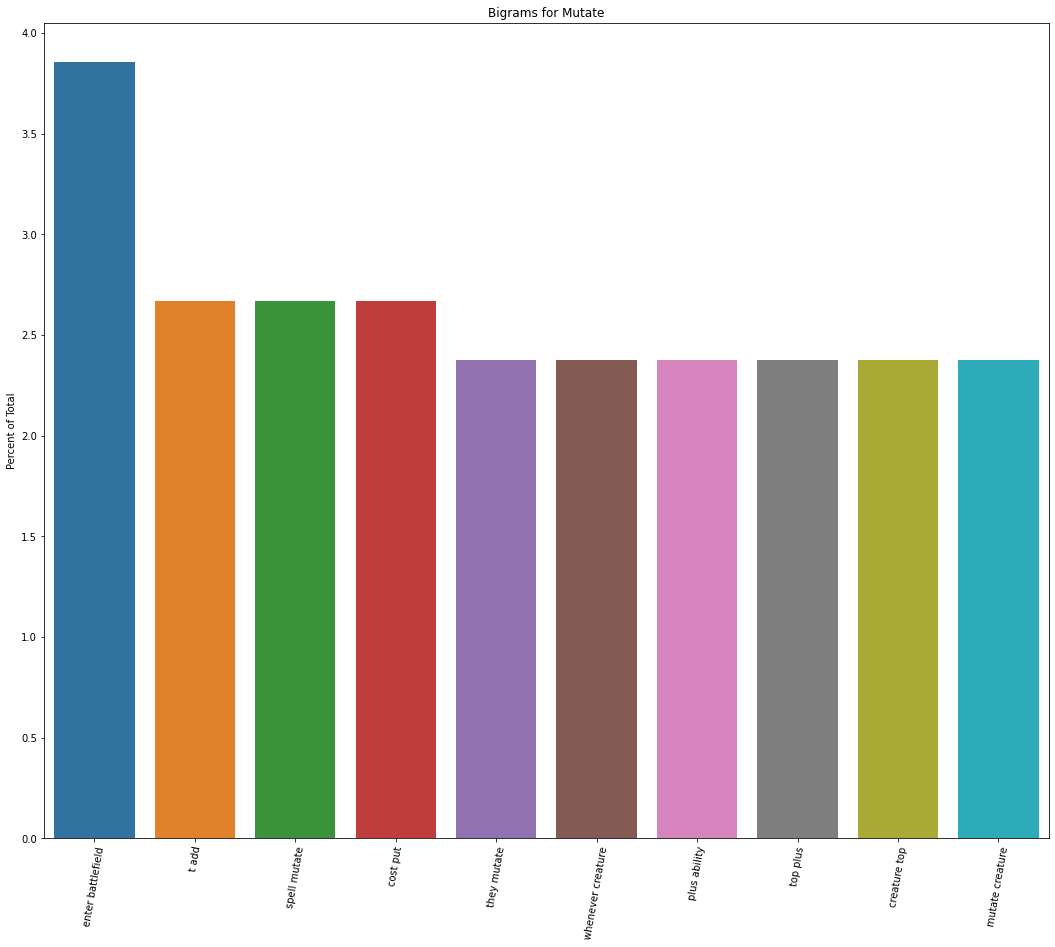

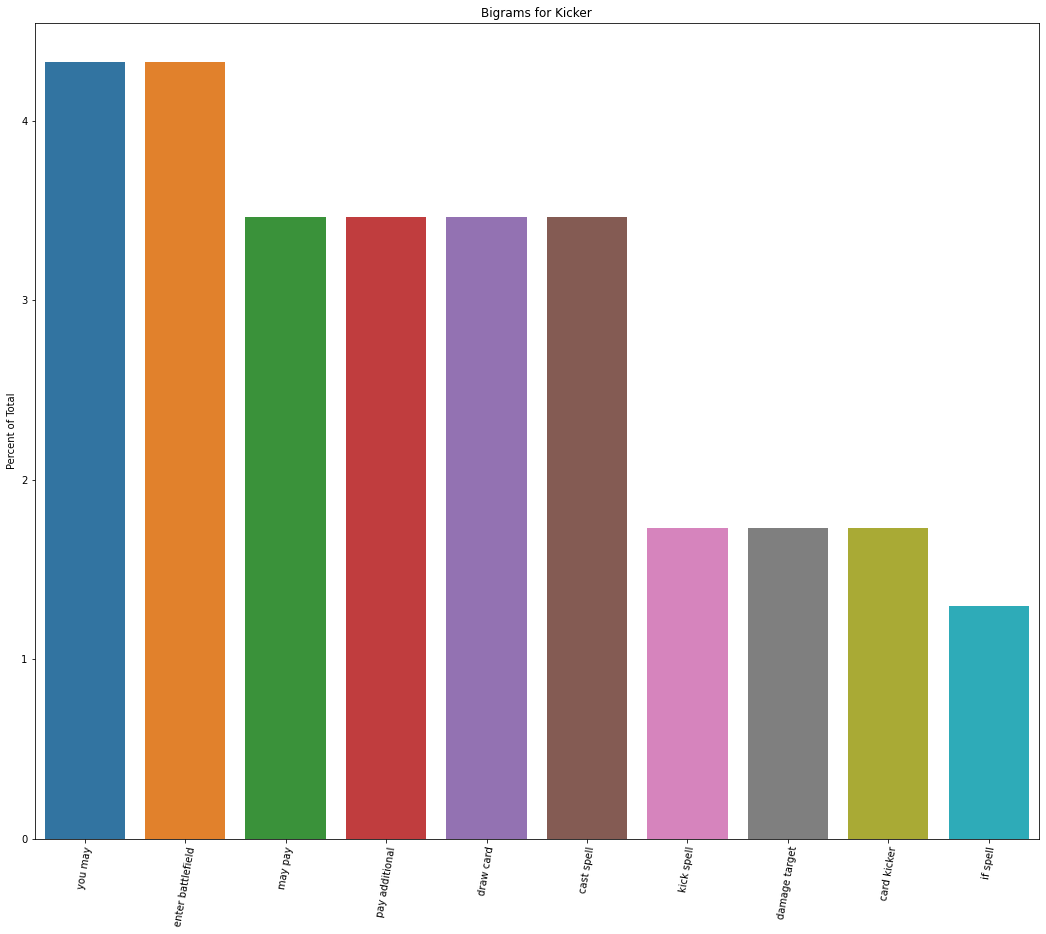

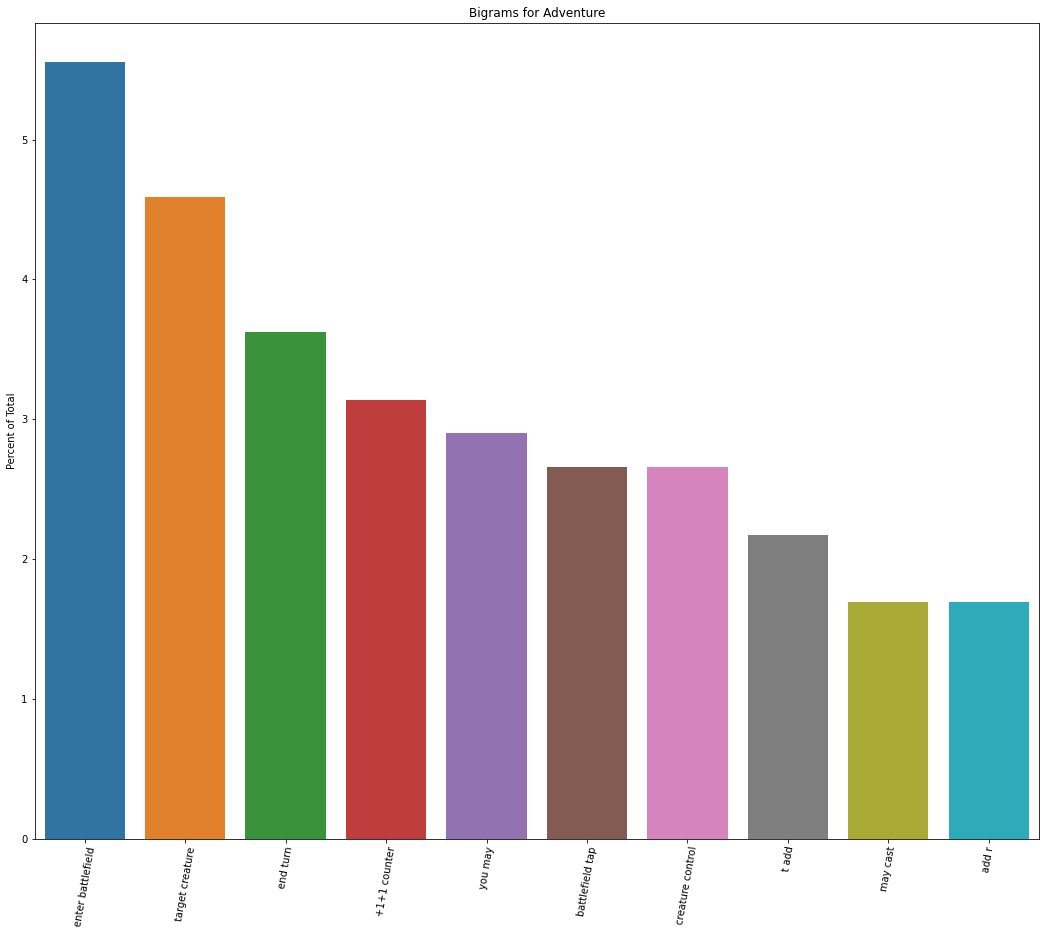

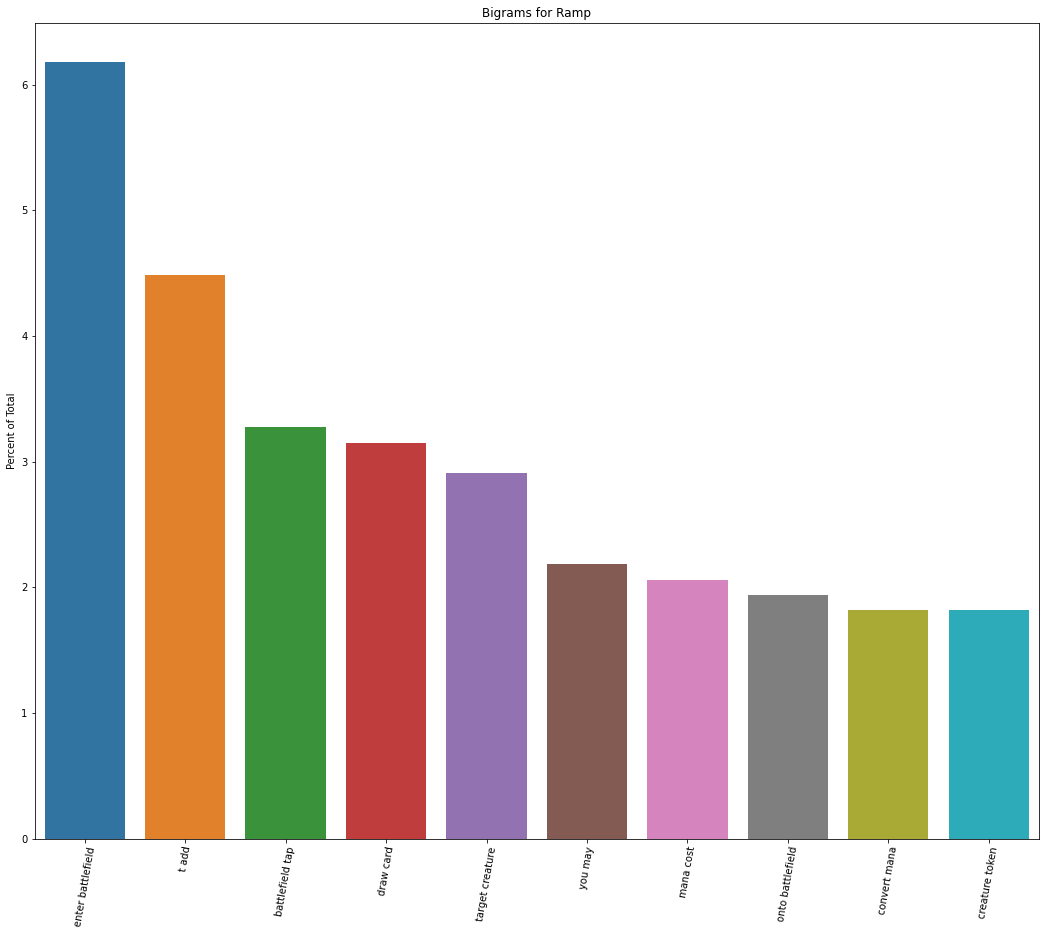

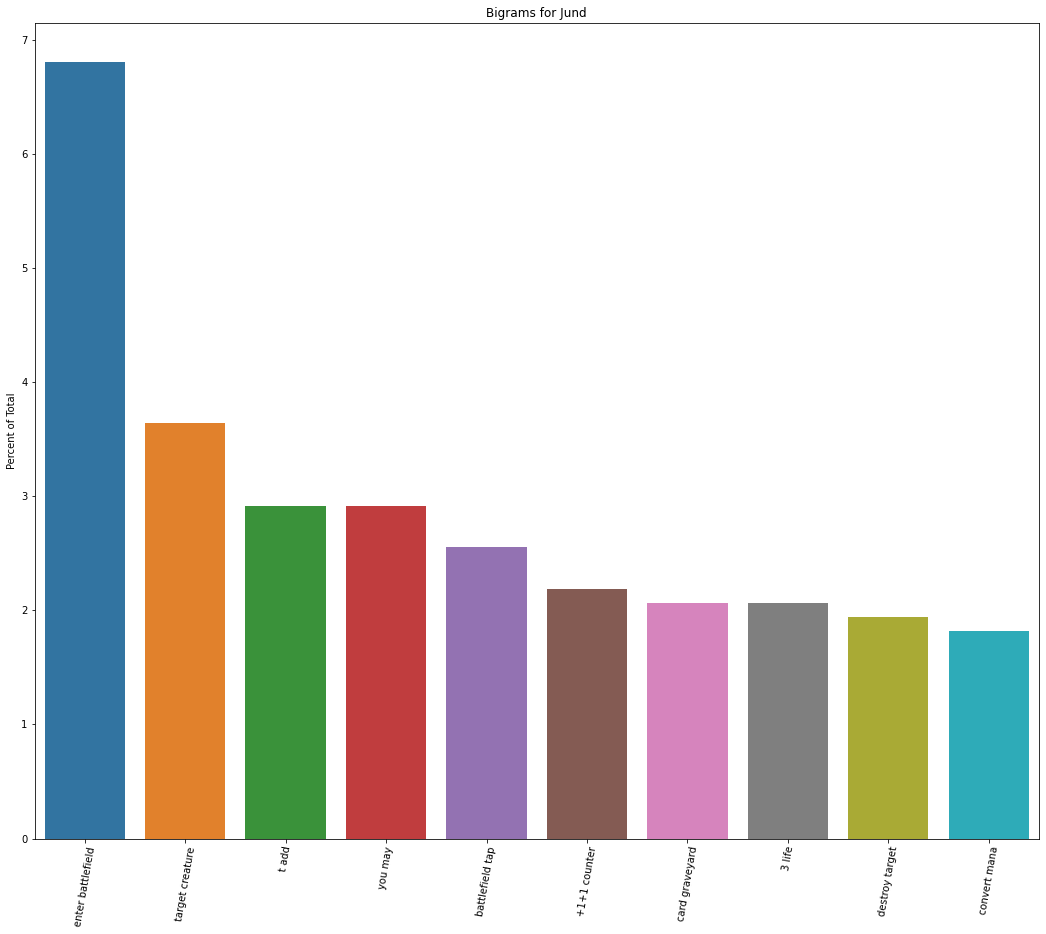

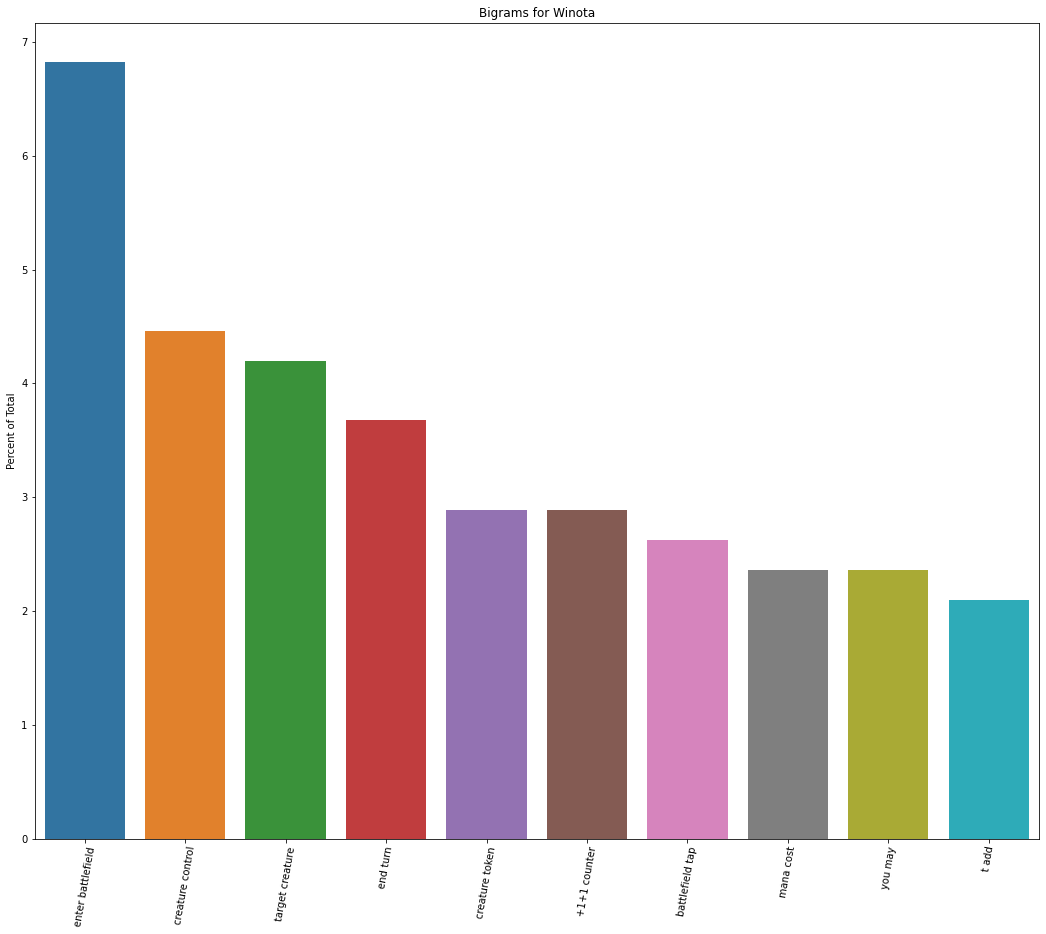

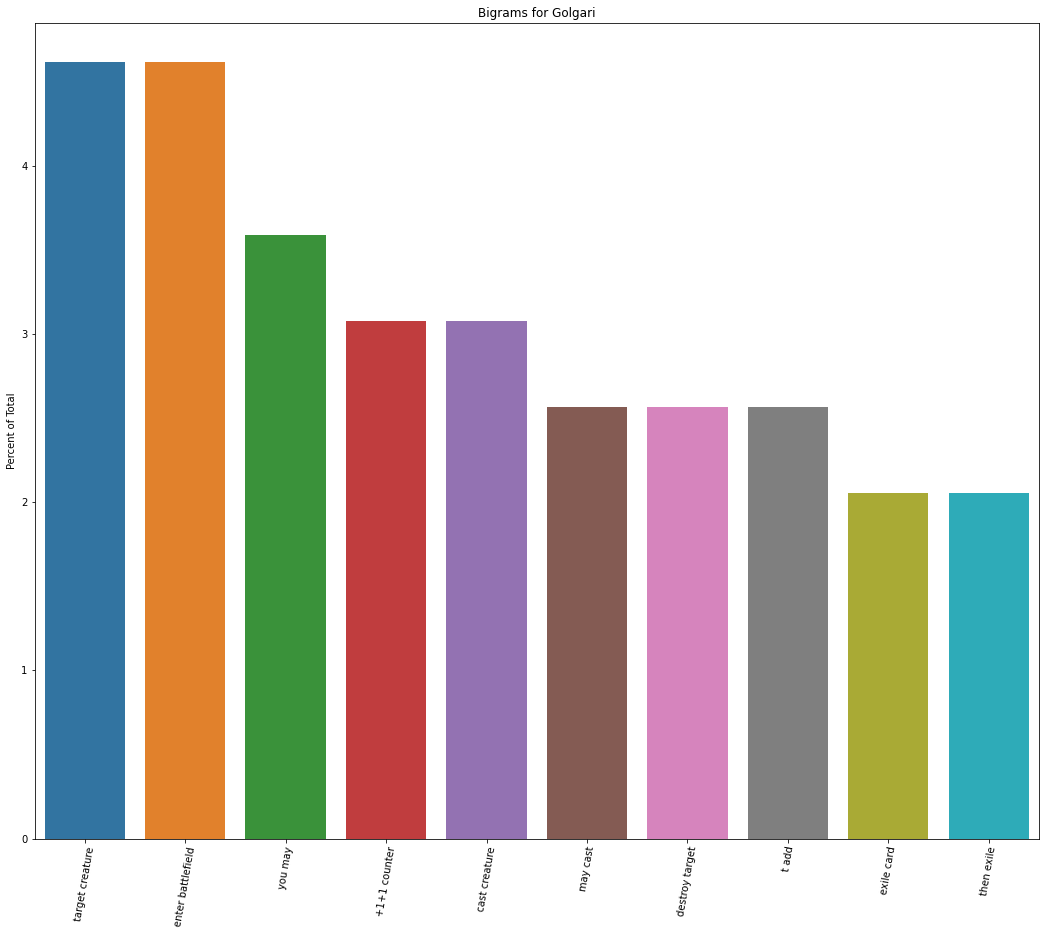

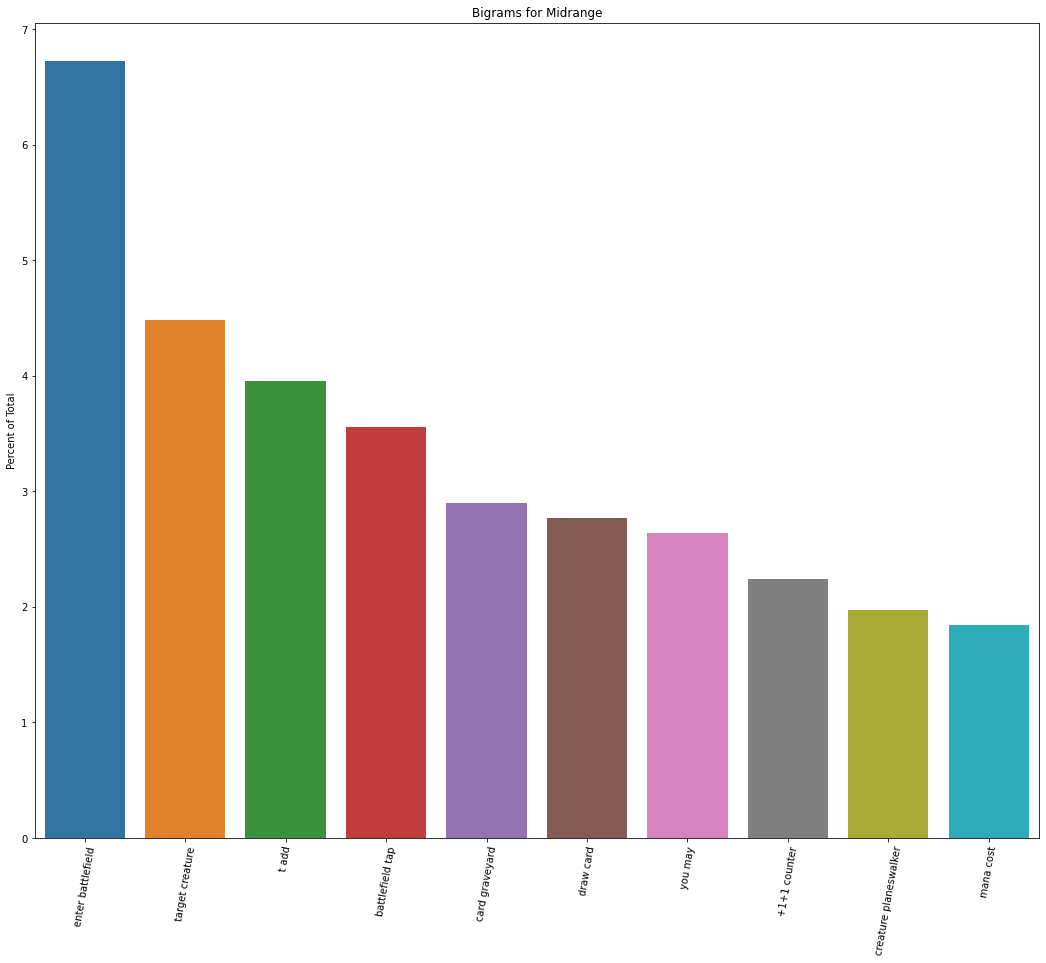

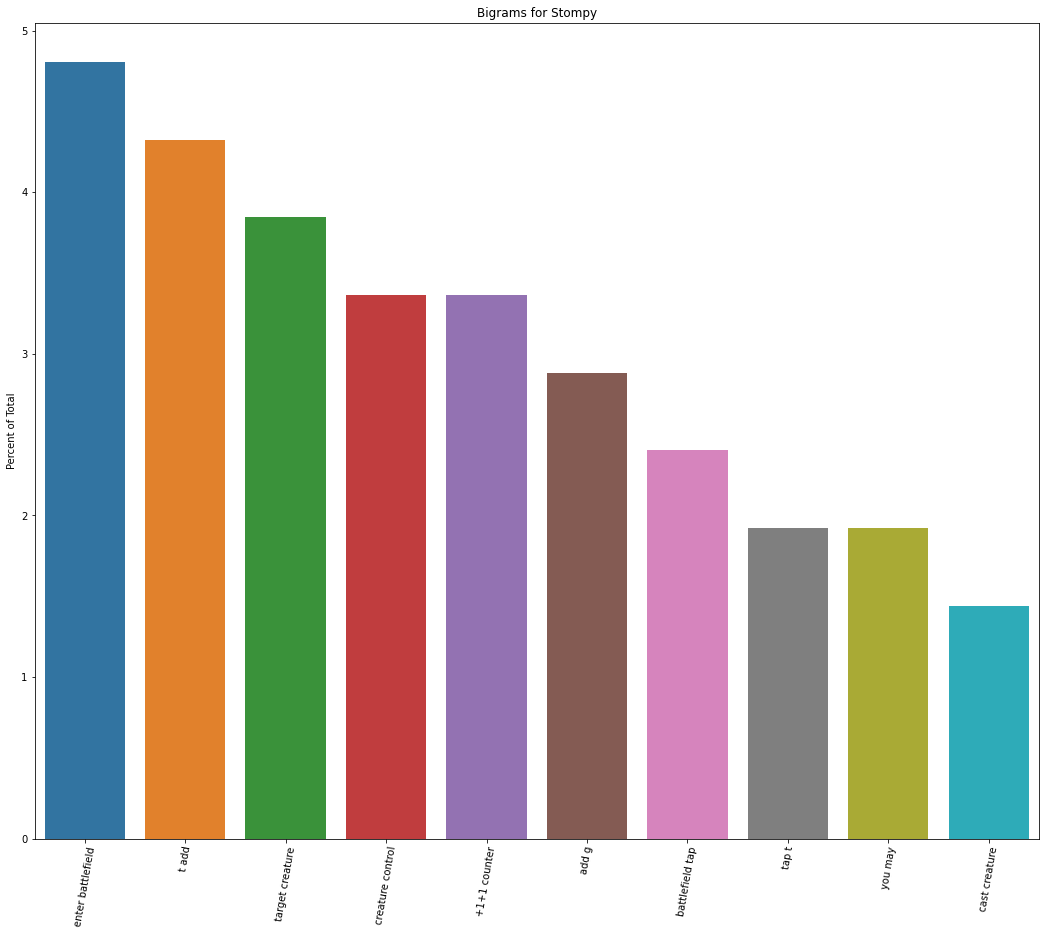

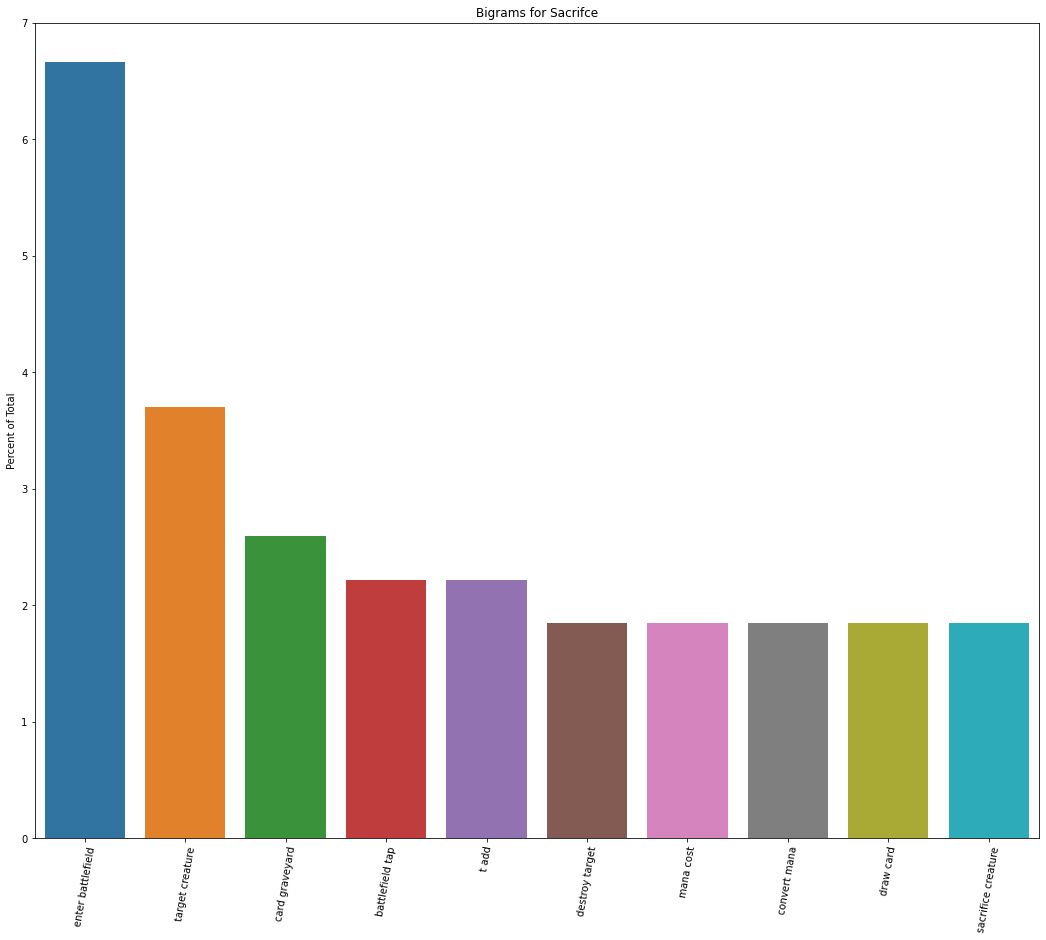

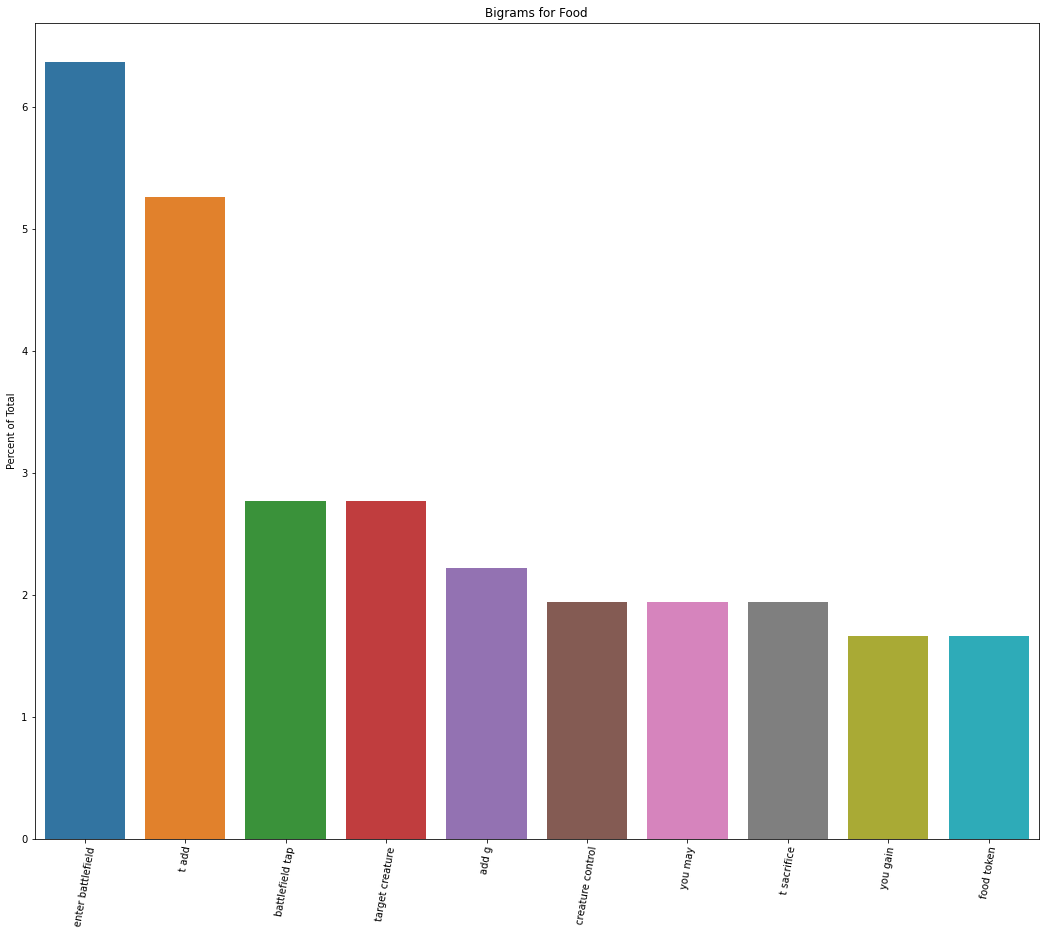

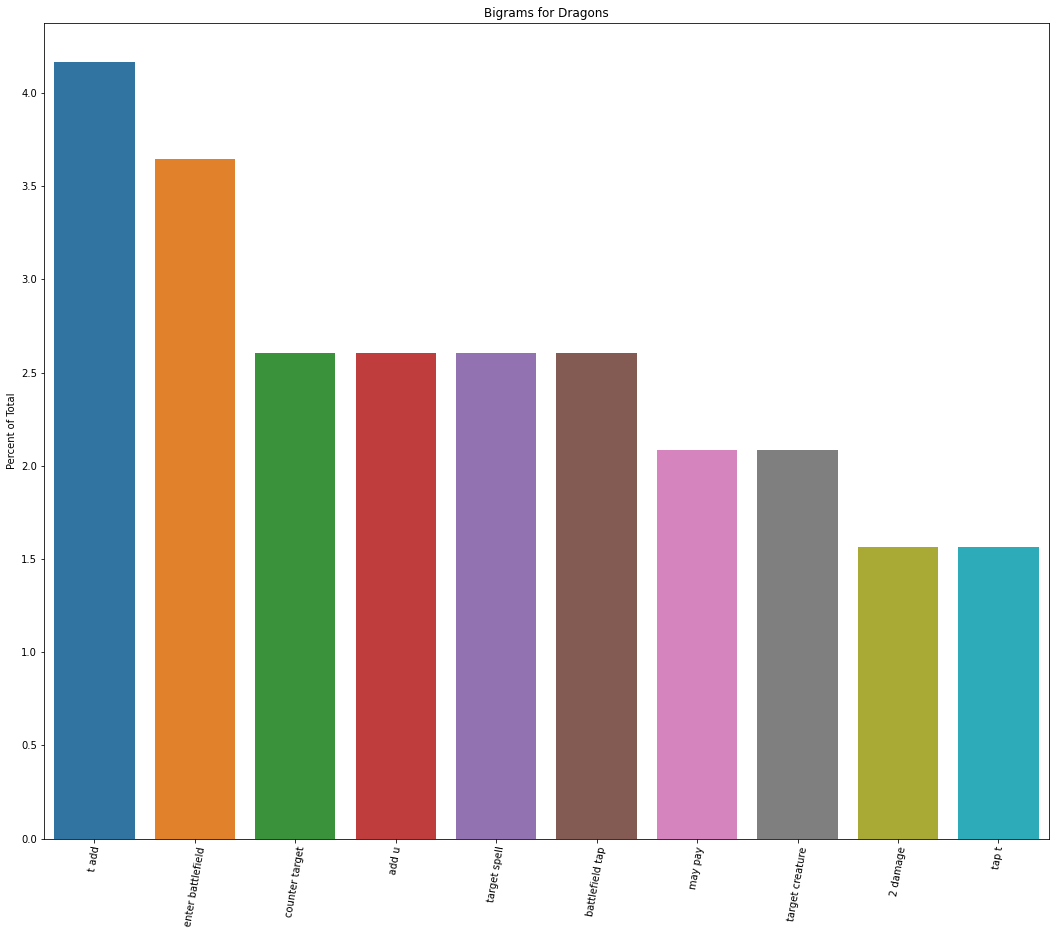

In [99]:
analyze_card_text_by_archetype(main_decks, show=True)

In [100]:
oracle_texts[oracle_texts["oracle_text"].str.contains("\send\s.*\sturn[\s\.]", regex=True, flags=re.I)]

name  \
10        Kazandu Mammoth // Kazandu Valley   
33                      Brushfire Elemental   
52                         Crawling Barrens   
69                             Primal Might   
105          Rimrock Knight // Boulder Rush   
119                             Wicked Wolf   
158                    Kogla, the Titan Ape   
186                         Castle Embereth   
204                        Fervent Champion   
221                          Phoenix of Ash   
242                         Akoum Hellhound   
248                           Dream Trawler   
271                     Claim the Firstborn   
278                      Kargan Intimidator   
293                         Selfless Savior   
342                          Faceless Haven   
345                    Seasoned Hallowblade   
348                         Footfall Crater   
370                  Elspeth, Sun's Nemesis   
383                 Alseid of Life's Bounty   
398                               Soul Sear   
405                       Garruk, Unleashed   
415                    Binding the Old Gods   
473                           Glory Bearers   
478                       Weaselback Redcap   
482                   Erebos's Intervention   
493                     Immersturm Predator   
513                         Felidar Retreat   
521                        The Royal Scions   
523              Kenrith, the Returned King   
529                        Zulaport Duelist   
541                Winota, Joiner of Forces   
544                       Grasp of Darkness   
557                           Massacre Wurm   
578   Faerie Guidemother // Gift of the Fae   
595        Sejiri Shelter // Sejiri Glacier   
622                Nissa of Shadowed Boughs   
630                          Ranger's Guile   
639                               Infuriate   
670            Vito, Thorn of the Dusk Rose   
683                            Fight as One   
688                    Koma, Cosmos Serpent   
701                          Pestilent Haze   
714                             Shadowspear   
730                               Basri Ket   
734    Song-Mad Treachery // Song-Mad Ruins   
756                     Firja's Retribution   
757                          Blizzard Brawl   
758                      Blacklance Paragon   
765                      Archpriest of Iona   
767                         Bronzehide Lion   
784       Makindi Stampede // Makindi Mesas   
788                              Bolt Hound   
789                      Fearless Fledgling   
796                          Snakeskin Veil   
801                            Fearless Pup   
816                        Wildwood Tracker   
819                    Reptilian Reflection   
832                         Arni Brokenbrow   
834                           Crash Through   
850                            Raking Claws   
884             Beyeen Veil // Beyeen Coast   
902                  Watcher of the Spheres   
922                         Master of Winds   
924                      Almighty Brushwagg   
957                          Shadow Stinger   
960                       Sea Gate Banneret   
974                        Stormwing Entity   
979                         Goblin Wizardry   
983                           Canopy Baloth   
990                 Akiri, Fearless Voyager   
992                             Grim Draugr   
994                       Witch's Vengeance   
997                     Heroic Intervention   
1023                        Resolute Strike   
1029                      Masked Blackguard   
1051                          Discontinuity   
1066                             Riddleform   
1071                          Righteousness   
1125                   Tentative Connection   
1141                       Angel of Destiny   
1143                       Traitorous Greed   
1158                  Erebos, Bleak-Hearted   
1165                 Eidolon of Inspiration   
1176                      Nimble Trapfinder 

In [56]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [57]:
full_table_oracle_text

name  \
6                            Forest   
151                        Mountain   
296      Bonecrusher Giant // Stomp   
298             Brushfire Elemental   
300              Edgewall Innkeeper   
...                             ...   
1099085                Shell Shield   
1099086               Wall of Runes   
1099933           Savai Thundermane   
1100439             Port of Karfell   
1100440       King Narfi's Betrayal   

                                                                                                                                                                                                                                                                                                                                                                                        oracle_text  
6                                                                                                                                                                                                                                                                                                                                                                                   ({T}: Add {G}.)  
151                                                                                                                                                                                                                                                                                                                                                                                 ({T}: Add {R}.)  
296                                                                                                                                                                                              Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.  
298                                                                                                                                                                                         Haste\nBrushfire Elemental can't be blocked by creatures with power 2 or less.\nLandfall — Whenever a land enters the battlefield under your control, Brushfire Elemental gets +2/+2 until end of turn.  
300                                                                                                                                                                                                                                                                   Whenever you cast a creature spell that has an Adventure, draw a card. (It doesn't need to have gone on the adventure first.)  
...                                                                                                                                                                                                                                                                                                                                                                                             ...  
1099085                                                                                                        Kicker {1} (You may pay an additional {1} as you cast this spell.)\nTarget creature you control gets +0/+3 until end of turn. If this spell was kicked, that creature also gains hexproof until end of turn. (It can't be the target of spells or abilities your opponents control.)  
1099086                                                                                                                                                                                                     Defender (This creature can't attack.)\nWhen Wall of Runes enters the battlefield, scry 1. (Look at the top card of your library. You may put that card on the bottom of your library.)  
1099933                                             

In [58]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

bigram  freq  pct_total
35       enters battlefield   363   6.815621
115         target creature   256   4.806609
41                 end turn   169   3.173113
83                  you may   153   2.872700
130            +1+1 counter   148   2.778821
49                draw card   145   2.722493
97         creature control   140   2.628614
0                     t add   127   2.384529
124          card graveyard   122   2.290650
63       battlefield tapped   110   2.065340
78           creature token   107   2.009012
801              cast spell    99   1.858806
346               mana cost    95   1.783703
315            card library    77   1.445738
129                put +1+1    72   1.351859
299        opponent control    72   1.351859
84                 may cast    71   1.333083
22            damage target    69   1.295531
345          converted mana    68   1.276756
360            discard card    68   1.276756
353          destroy target    65   1.220428
229            at beginning    64   1.201652
914                two card    62   1.164101
430          counter target    61   1.145325
267   creature planeswalker    56   1.051446
116            creature get    54   1.013894
36      battlefield control    54   1.013894
170                 may pay    52   0.976342
127           creature card    50   0.938791
313                look top    49   0.920015
81               exile card    47   0.882463
349        onto battlefield    47   0.882463
135                  1 life    45   0.844912
393                 may put    44   0.826136
209                you gain    44   0.826136
64                 tapped t    43   0.807360
859             t sacrifice    43   0.807360
211                  2 life    42   0.788584
392             library you    42   0.788584
425               card hand    41   0.769808
9              target spell    41   0.769808
1349      whenever creature    41   0.769808
172                  3 life    40   0.751033
137             control get    40   0.751033
763              choose one    40   0.751033
191                get +1+1    39   0.732257
396          bottom library    39   0.732257
341          search library    38   0.713481
43            whenever cast    37   0.694705
122            exile target    36   0.675929
351         shuffle library    36   0.675929
308             deal damage    36   0.675929
575                put hand    35   0.657154
484           return target    34   0.638378
847           damage player    33   0.619602
354         target artifact    33   0.619602
235               land card    33   0.619602
394                put card    33   0.619602
314                top card    33   0.619602
93            combat damage    33   0.619602
361               card draw    31   0.582050
988         target opponent    31   0.582050
44            cast creature    31   0.582050
1626             owner hand    30   0.563275
134                  gain 1    30   0.563275
250              three card    30   0.563275
178              this spell    30   0.563275
128                card put    30   0.563275
142              one target    28   0.525723
864           target player    28   0.525723
2250                  pay 2    28   0.525723
1979        instant sorcery    28   0.525723
1341      nonhuman creature    28   0.525723
1044                 gain 3    27   0.506947
256               cast card    27   0.506947
1485     enchanted creature    27   0.506947
169         battlefield may    27   0.506947
1                     add g    26   0.488171
255           graveyard you    26   0.488171
74                create 11    26   0.488171
818                1 damage    26   0.488171
82                 card you    26   0.488171
616       nonland permanent    26   0.488171
941      sacrifice creature    25   0.469395
1016             put target    25   0.469395
817                  deal 1    25   0.469395
13                 2 damage    25   0.469395
12                   deal 2    25   0.469395
144            d

In [59]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [60]:
all_card_bigrams

bigram  freq  pct_total
3      enters battlefield  2997   5.607109
82        target creature  2732   5.111319
173              end turn  2373   4.439663
558                 t add  1725   3.227315
277      creature control  1449   2.710945
77           +1+1 counter  1308   2.447147
223             draw card  1172   2.192703
13                you may  1125   2.104771
34           creature get  1100   2.057998
154        creature token   990   1.852198
238        card graveyard   944   1.766137
72             cast spell   938   1.754911
225          at beginning   801   1.498597
302         damage target   773   1.446211
208             mana cost   753   1.408793
33     enchanted creature   696   1.302152
35               get +1+1   673   1.259121
662          discard card   648   1.212348
11           card library   630   1.178672
2053   battlefield tapped   628   1.174930
808         creature card   620   1.159963
346              put +1+1   603   1.128157
195        destroy target   595   1.113190
44          this creature   581   1.086997
87               may cast   559   1.045837
635         combat damage   550   1.028999
31       enchant creature   549   1.027128
46           cant blocked   523   0.978485
205      opponent control   522   0.976614
385        counter target   505   0.944808
554         target player   499   0.933583
144           control get   495   0.926099
45          creature cant   491   0.918616
281                1 life   483   0.903648
1054       search library   476   0.890552
226      beginning upkeep   471   0.881197
4     battlefield control   455   0.851263
1057      shuffle library   441   0.825070
207        converted mana   437   0.817587
1601              may pay   434   0.811974
1380     onto battlefield   421   0.787652
146         whenever cast   418   0.782039
810     whenever creature   416   0.778297
501             card hand   412   0.770814
865         damage player   408   0.763330
301           deal damage   405   0.757717
465              two card   397   0.742750
324            owner hand   394   0.737138
359          first strike   380   0.710945
321         return target   376   0.703461
397     artifact creature   370   0.692236
1023             1 damage   368   0.688494
32     creature enchanted   360   0.673527
8                look top   349   0.652947
407       creature flying   347   0.649205
634           deal combat   341   0.637979
378       target artifact   336   0.628625
431          target spell   336   0.628625
614              put card   335   0.626754
1011             card put   335   0.626754
354              get +2+2   328   0.613658
612              top card   327   0.611787
1035      battlefield may   319   0.596819
1022               deal 1   317   0.593078
103           t sacrifice   317   0.593078
770        graveyard hand   311   0.581852
335     equipped creature   309   0.578110
819                2 life   307   0.574369
1755                add g   307   0.574369
1038             2 damage   302   0.565014
613               may put   301   0.563143
782              get +1+0   295   0.551918
636       damage creature   295   0.551918
106              you gain   294   0.550047
23               put hand   293   0.548176
1461             one mana   292   0.546305
27         bottom library   292   0.546305
388             create 11   289   0.540692
822      activate ability   287   0.536950
1378            land card   285   0.533209
841       target opponent   285   0.533209
2065                add r   280   0.523854
1037               deal 2   277   0.518241
2085                add b   270   0.505145
134              end step   269   0.503274
367              +1+1 end   269   0.503274
559                 add u   267   0.499532
280                gain 1   265   0.495790
451             cast card   260   0.486436
2057                add w   260   0.486436
203          exile target   257   0.480823
854    sacrifice creature   254   0.475210
702           flying

In [61]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [62]:
pval

7.140166226256405e-114

In [124]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        top10_colors_archetypes(first_place_decks, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        top_10_archetypes(main_decks, pdf=pdf)
        plt.close("all")
        
        top_15_categories(main_decks, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        analyze_card_text_by_archetype(main_decks, pdf=pdf)
        plt.close("all")

In [125]:
save_to_pdf()